## This notebook contains routines to analyze the electric load profiles from PG&E office building
#### Brief description of this workflow:
1. Pre-processing (skip this step your if you have cleaned data)
    - Extract data for a building type (e.g. office building in our case)
    - Remove empty and problematic data
    - Convert data into dataframes ([example](../data_example/1004541105.csv))
    - Get typical building load profiles
        - Create annual heatmaps
        - Use pre-trained CNN model and k-means clustering to distinguish typical building loads (high-load during daytime) and non-typical loads (e.g., high-load during night time)
2. Conduct Frequency-Domain analysis
    - Annual analysis (not granular enough)
        - Create bins to group high, medium, and low frequency features
    - Daily analysis
        - How

### Setup the path and import utility libraries (Needed for first-time run)

In [1]:
%pwd
%cd ..

# Import utility functions
# Change directory to the EULP root path, use %cd path_to_EULP
import os
from lib import data_exploration_utils as ex
from lib import frequency_domain_utils as fd
from pathlib import Path
import numpy as np
dir_root = '/Users/jgonzal2/EULP' #%pwd
dir_data = os.path.join(dir_root, "data_files/data/raw_data_freq")
'/Users/jgonzal2/EULP/result'
dir_fig  = os.path.join(dir_root, "result/frequency_domain")

folders = ['by_building_type']#, 'by_utility', 'by_utility_and_building_type']

/Users/jgonzal2/EULP/EULP


### Step 1. Pre-processing (optional)
Previously, we found some load profiles have high-peak during the night time.
- Example 1: [exterior lighting](../data_example/11262200205.png)
- Example 1: [typical load profile](../data_example/1302702505.png)

We want to explore how those load profile look like and whether we should separate them from typical load profiles.

#### Generate heatmaps and time-series line plot for visualization

In [2]:
v_valid_ts_CSVs = []
for folder in folders:
    for subfolder in os.listdir(os.path.join(dir_data,folder)):
        if subfolder == '.DS_Store' or subfolder == 'by_building_type':
            continue

        data_folder = f'{dir_data}/{folder}/{subfolder}'
        v_ts_CSVs = ex.get_all_file_paths(data_folder, 'parquet')
        
        if len(v_ts_CSVs)==0:
            continue

        # Create these paths if not exist
        results_folder = f'{dir_fig}/{folder}/{subfolder}/ts_heatmaps'
        if not os.path.exists(results_folder):
          os.makedirs(results_folder)
        
        results_folder = f'{dir_fig}/{folder}/{subfolder}/ts_lines'
        if not os.path.exists(results_folder):
          os.makedirs(results_folder)
        
        results_folder = f'{dir_fig}/{folder}/{subfolder}'
        dir_heatmaps = os.path.join(results_folder, "ts_heatmaps")
        dir_lines    = os.path.join(results_folder, "ts_lines")

        for i, ts_csv in enumerate(v_ts_CSVs):
            print(ts_csv)
            names = ts_csv.split('/')
            names = names[-1]
            names = names.split('-')
            utility   = names[0]
            bldg_id   = names[1]
            bldy_type = names[2]

            sp_id = os.path.basename(ts_csv).split('.')[0]
            df_t = ex.clean_pge_df_ts(ts_csv)
            
            if df_t[1]:
                continue

            df_t = df_t[0]
            df_t = df_t['total_kWh_excluding_blanks']#.squeeze()
            
            if df_t.sum() < 10.0: # arbitrarily low value
                continue

            dir_heatmap = os.path.join(dir_heatmaps, f"{sp_id}.png")

            try:
                if not os.path.exists(dir_heatmap):
                    ex.generate_heatmap(df_t, dir_heatmap)
                else:
                    print(f'{dir_heatmap} exists')
                
                if not os.path.exists(f"{dir_lines}/{sp_id}.html"):    
                    ex.generate_ts_html(df_t, sp_id, dir_lines)
                else:
                    print(f'{dir_lines}/{sp_id}.html exists')
                
                v_valid_ts_CSVs.append(ts_csv)

            except:
                pass

/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/maine-UID354-supermarket.parquet
/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/supermarket/ts_heatmaps/maine-UID354-supermarket.png exists
/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/supermarket/ts_lines/maine-UID354-supermarket.html exists
/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/veic-UID1439-supermarket.parquet
/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/supermarket/ts_heatmaps/veic-UID1439-supermarket.png exists
/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/supermarket/ts_lines/veic-UID1439-supermarket.html exists
/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/veic-RID401-supermarket.parquet
/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/supermarket/ts_heatmaps/veic-RID401-supermarket.png exists
/Users/jgonzal2/EULP/result/frequency_domain/by_building_

#### Apply k-means clustering with features generated from pre-trained CNN model

In [7]:
# Get conv base features
dir_fig  = os.path.join(dir_root, "result/frequency_domain/by_building_type")

f_1 = lambda x: x.replace('.parquet', '')
f_2 = lambda x: x.split('/')[-1]
buildings = list(map(f_1,v_valid_ts_CSVs))
buildings = list(map(f_2, buildings))

all_files = []
for path, subdirs, files in os.walk(dir_fig):
    for name in files:
        if name.replace('.png', '') in buildings:
            all_files.append(os.path.join(path, name))

v_heatmaps = list(filter(lambda x: x.endswith('.png'), all_files))
model_conv_base = ex.model_vgg16_conv_base()
v_conv_base_features = [ex.get_conv_base_features(img, model_conv_base).flatten() for img in v_heatmaps]

In [9]:
len(v_valid_ts_CSVs)
len(all_files)

543

In [10]:
len(v_heatmaps)
# len(kmeans_labels_step_1)

543

In [11]:
# Clustering (k=2 because we already know there are two distinct patterns) 
from sklearn.cluster import KMeans
kmeans_step_1 = KMeans(n_clusters=2, random_state=0).fit(v_conv_base_features)

In [12]:
# Copy heatmaps to corresponding cluster folder for comparison
import shutil
kmeans_labels_step_1 = kmeans_step_1.labels_
step_1_out_dir = os.path.join(dir_fig, 'step_1')
if not os.path.exists(step_1_out_dir):
        os.mkdir(step_1_out_dir)

for i, label in enumerate(kmeans_labels_step_1):
    cluster_dir = os.path.join(step_1_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    shutil.copy(v_heatmaps[i], cluster_dir)

In [ ]:
len(kmeans_labels_step_1)

In [13]:
# Get the "typical" load profiles
import numpy as np
v_typical_ts_CSVs = list(np.take(v_valid_ts_CSVs, np.where(kmeans_labels_step_1==1))[0]) # Caution: cluster label might be 0 for typical load profiles
v_typical_heatmaps = list(np.take(v_heatmaps, np.where(kmeans_labels_step_1==1))[0])

### Step 2. Frequency-domain analysis

#### Get frequency-domain features at daily window level.

The Dicrete Fourier Transform (DFT) of a daily load profile (15-min interval, 96 timestamps in total) may yield a spectrum with the frequency ranging from 0.5 hour to 12 hour. However, different load profiles may have different peaks in the spectrums. Creating bins of frequencies allows us to group various spectrum peaks. First, we're going to explore the load profiles' variations within each day. We do the following for each building:
1. Run DFT for each day
2. Group the frequency spectrum features into hour-interval bins, sum the amplitudes in each bin. 
3. Explore the distributions of the amplitude sums in each bin

In this case, we define the following hour interval bins.

In [14]:
hour_interval_bins = [
    [0.5, 0.75],
    [0.75, 1],
    [1, 1.25],
    [1.25, 1.5],
    [1.5, 1.75],
    [1.75, 2],
    [2, 4],
    [4, 8],
    [8, 12]
]

# fd.print_hour_interval_bin_info(hour_interval_bins)
fd.print_hour_interval_bin_info(hour_interval_bins)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Bin 1: 0.5 Hz to 0.75 Hour --- 0.00037 Hz to 0.00056 Hz
Bin 2: 0.75 Hz to 1 Hour --- 0.00028 Hz to 0.00037 Hz
Bin 3: 1 Hz to 1.25 Hour --- 0.00022 Hz to 0.00028 Hz
Bin 4: 1.25 Hz to 1.5 Hour --- 0.00019 Hz to 0.00022 Hz
Bin 5: 1.5 Hz to 1.75 Hour --- 0.00016 Hz to 0.00019 Hz
Bin 6: 1.75 Hz to 2 Hour --- 0.00014 Hz to 0.00016 Hz
Bin 7: 2 Hz to 4 Hour --- 7e-05 Hz to 0.00014 Hz
Bin 8: 4 Hz to 8 Hour --- 3e-05 Hz to 7e-05 Hz
Bin 9: 8 Hz to 12 Hour --- 2e-05 Hz to 3e-05 Hz
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Prepare the data. An example normalized load profile look like below.

In [15]:
import pandas as pd

dir_typical_ts_CSVs = '/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/data_all/valid_CSVs'
dir_daily_window_dft_out = step_1_out_dir = os.path.join(dir_fig, 'step_2')
#dir_daily_window_dft_out = '/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/fig/step_2'

#v_typical_ts_CSVs = ex.get_all_file_paths(dir_typical_ts_CSVs, 'csv')

csv_in = v_typical_ts_CSVs[1]
df_ts = ex.clean_pge_df_ts(ts_csv)[0]
df_ts

total_kWh_excluding_blanks        date
Timestamp                                                        
2016-01-01 00:00:00+00:00                         0.0  2016-01-01
2016-01-01 00:15:00+00:00                         0.0  2016-01-01
2016-01-01 00:30:00+00:00                         0.0  2016-01-01
2016-01-01 00:45:00+00:00                         0.0  2016-01-01
2016-01-01 01:00:00+00:00                         0.0  2016-01-01
...                                               ...         ...
2016-12-31 23:00:00+00:00                         0.0  2016-12-31
2016-12-31 23:15:00+00:00                         0.0  2016-12-31
2016-12-31 23:30:00+00:00                         0.0  2016-12-31
2016-12-31 23:45:00+00:00                         0.0  2016-12-31
2017-01-01 00:00:00+00:00                         0.0  2017-01-01

[35137 rows x 2 columns]

Below is an frequency spectrum bins example for one building.

0.5hr ~ 0.75hr  0.75hr ~ 1hr  1hr ~ 1.25hr  1.25hr ~ 1.5hr  \
count           367.0         367.0         367.0           367.0   
mean              0.0           0.0           0.0             0.0   
std               0.0           0.0           0.0             0.0   
min               0.0           0.0           0.0             0.0   
25%               0.0           0.0           0.0             0.0   
50%               0.0           0.0           0.0             0.0   
75%               0.0           0.0           0.0             0.0   
max               0.0           0.0           0.0             0.0   

       1.5hr ~ 1.75hr  1.75hr ~ 2hr  2hr ~ 4hr  4hr ~ 8hr  8hr ~ 12hr  
count           367.0         367.0      367.0      367.0       367.0  
mean              0.0           0.0        0.0        0.0         0.0  
std               0.0           0.0        0.0        0.0         0.0  
min               0.0           0.0        0.0        0.0         0.0  
25%               0.0           0.0        0.0        0.0         0.0  
50%               0.0           0.0        0.0        0.0         0.0  
75%               0.0           0.0        0.0        0.0         0.0  
max               0.0           0.0        0.0        0.0         0.0

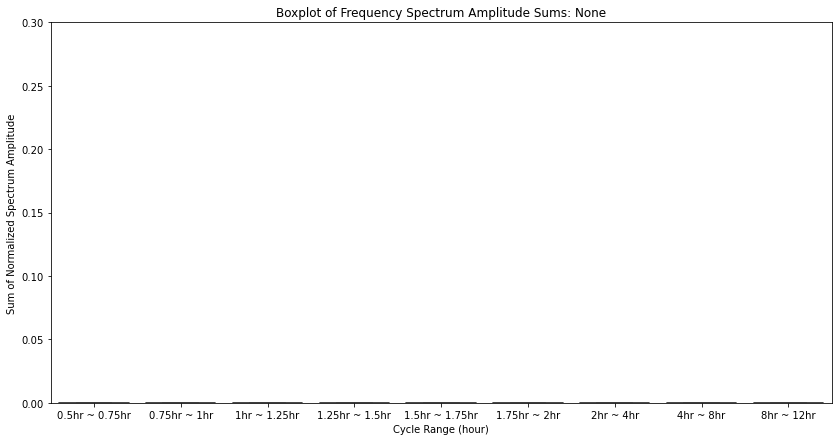

In [16]:
df = fd.get_daily_fft_sum_bins(df_ts, hour_interval_bins)
fd.daily_fft_sum_bins_boxplot(df)
df.describe()

Generate the frequency sprectrum bins for each building, save the boxplot.

In [19]:
v_typical_ts_CSVs
'/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/maine-UID354-supermarket.parquet'


['/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/maine-UID354-supermarket.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/veic-UID1439-supermarket.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/supermarket/veic-UID748-supermarket.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/car_wash/maine-UID403-car_wash.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/quick_service_restaurant/veic-UID1449-quick_service_restaurant.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/quick_service_restaurant/veic-UID703-quick_service_restaurant.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/quick_service_restaurant/veic-UID1494-quick_service_restaurant.parquet',
 '/Users/jgonzal2/EULP/data_files/data/raw_data_freq/by_building_type/quick_service_restaurant/veic-UID706-quic

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


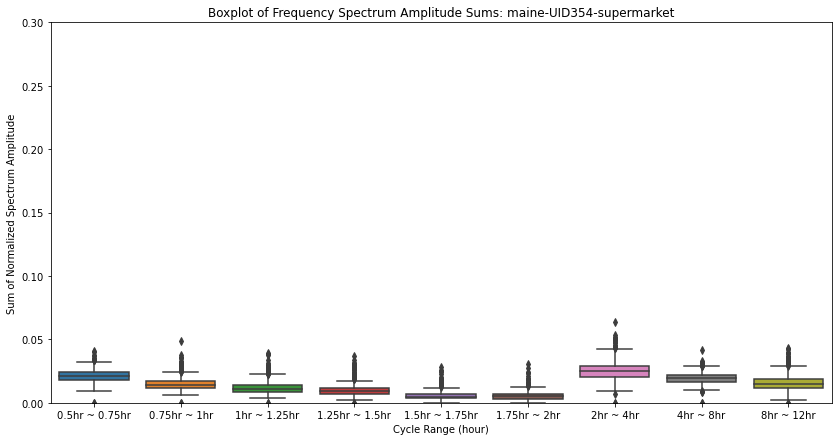

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


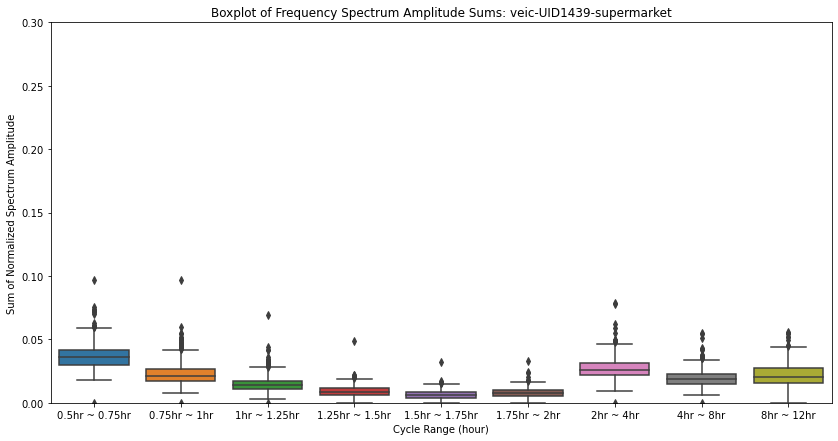

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


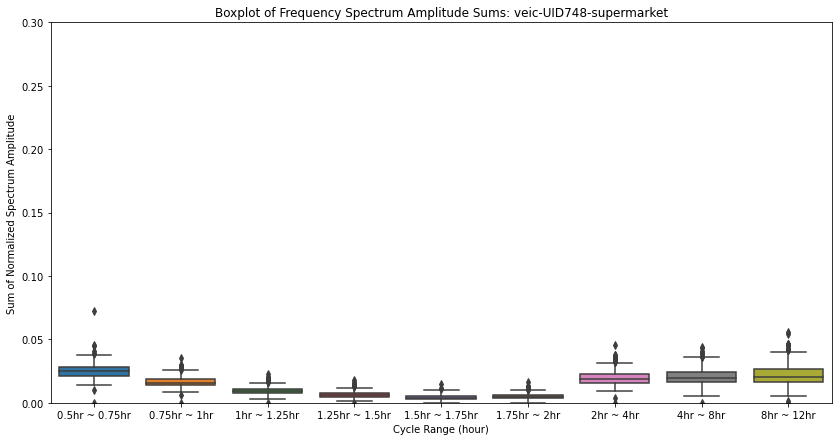

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


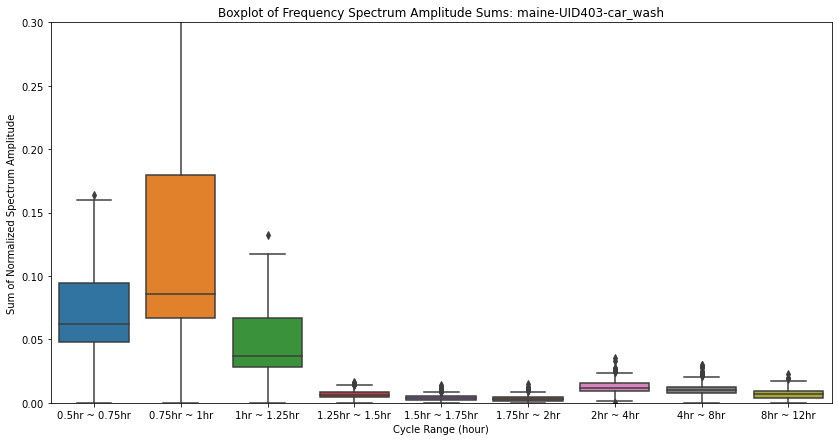

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


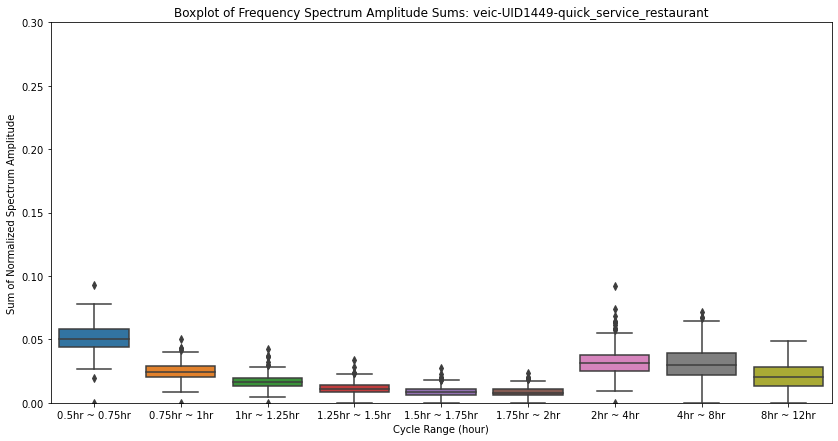

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


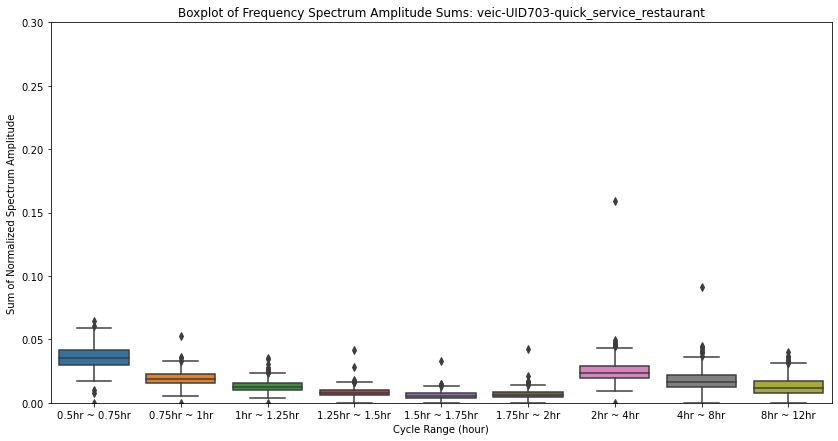

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


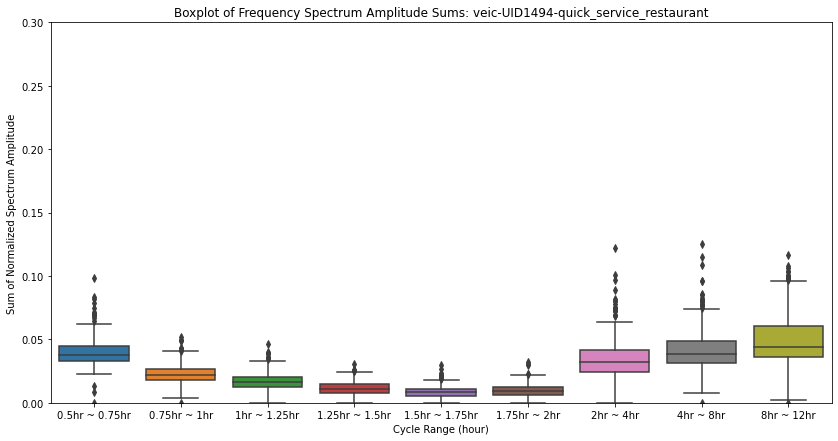

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


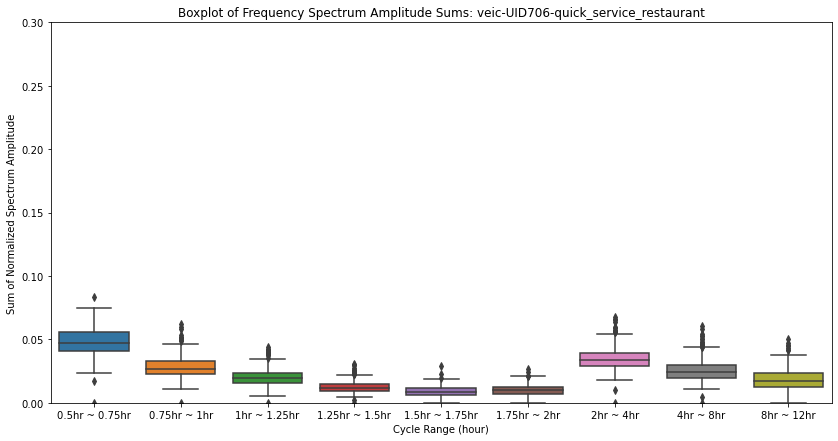

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


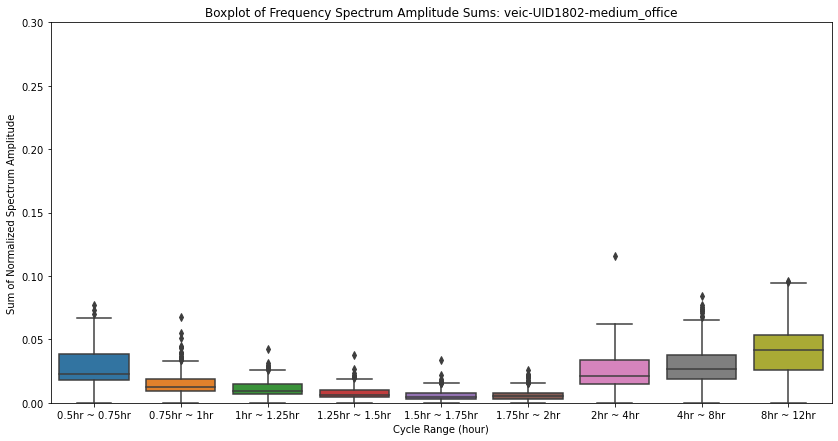

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


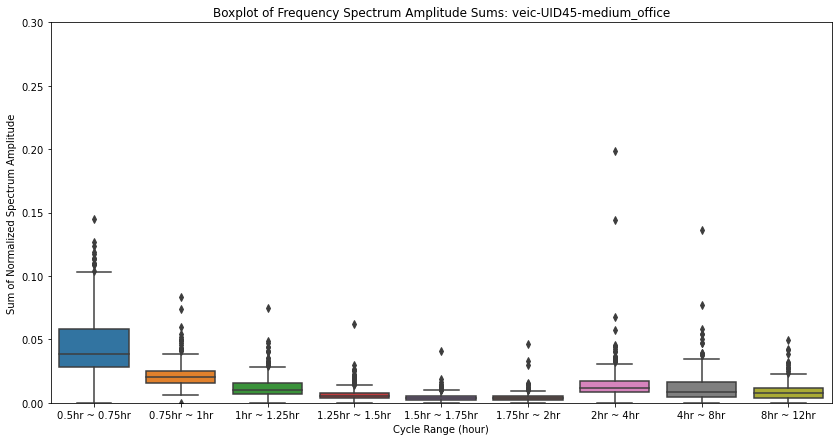

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


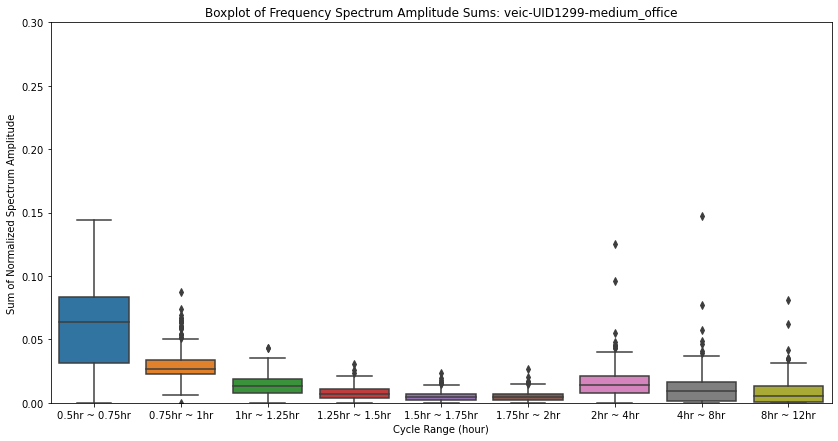

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


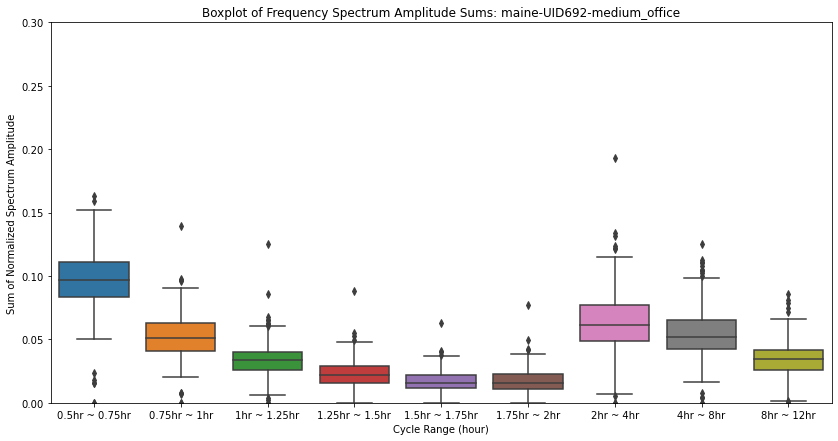

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


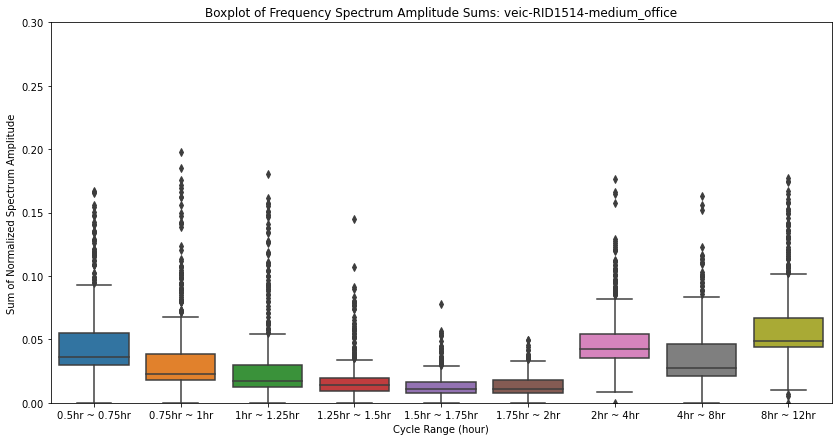

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


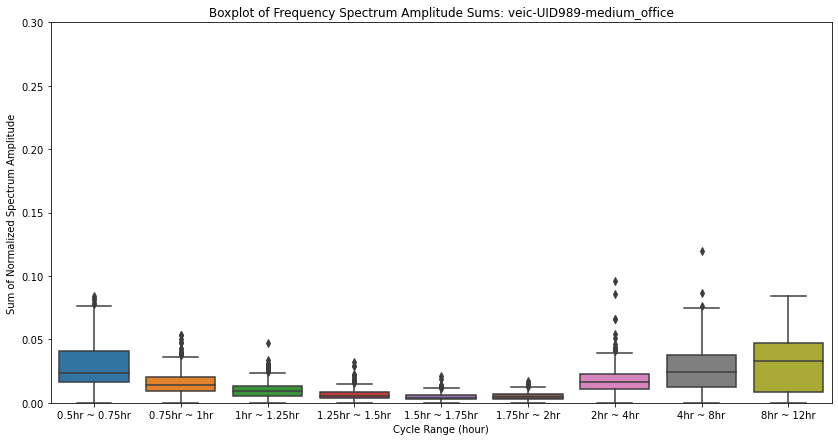

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


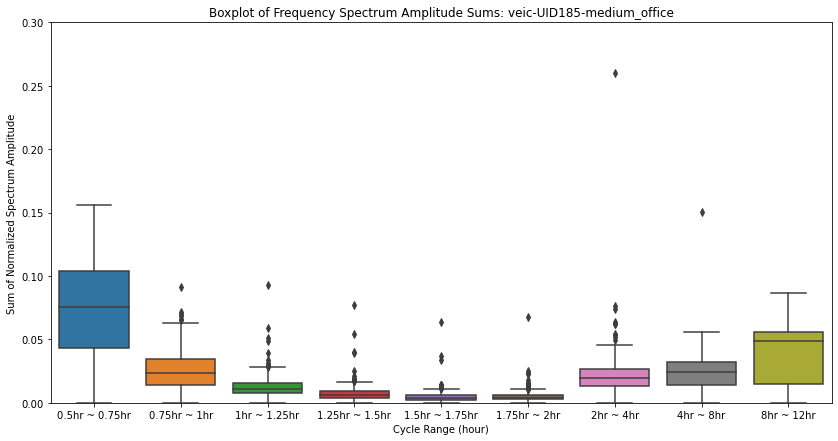

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


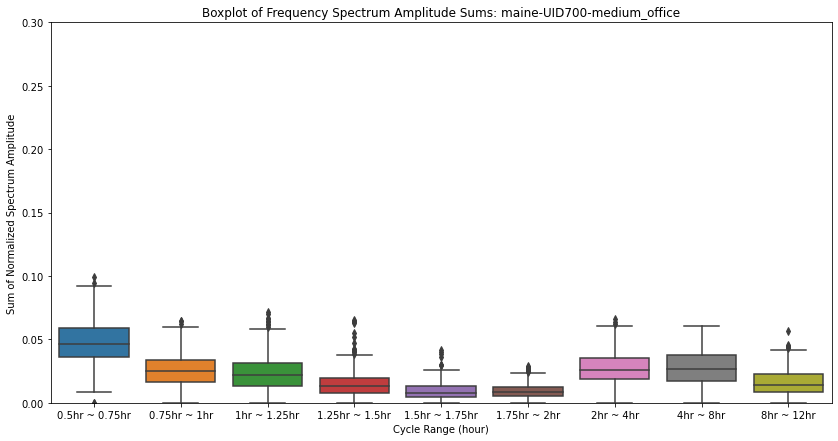

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


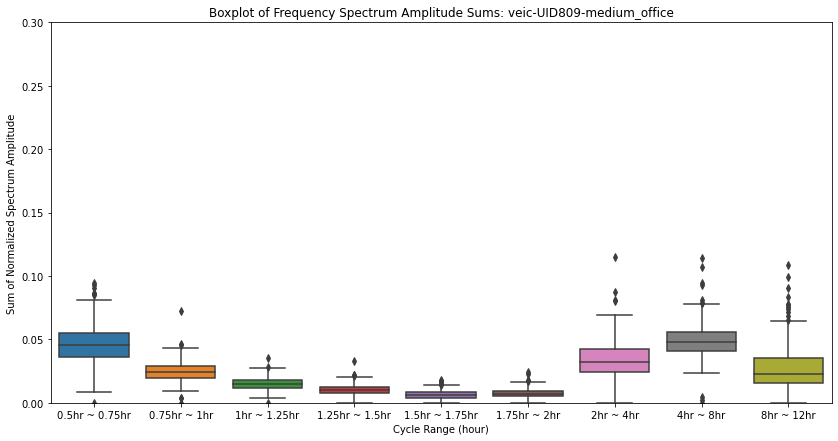

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


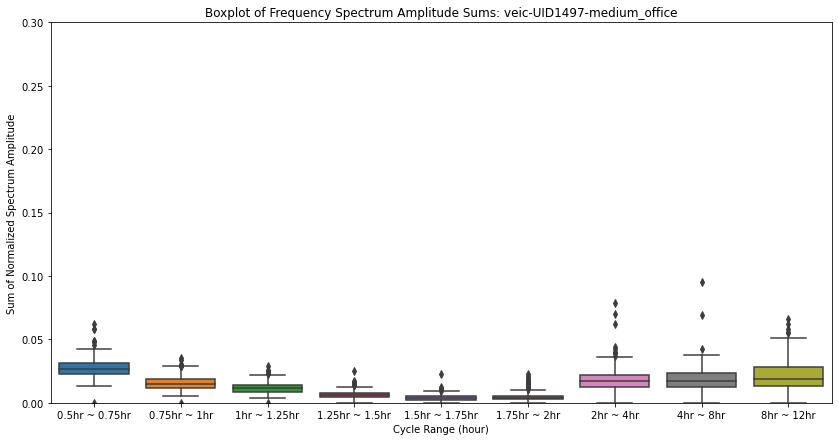

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


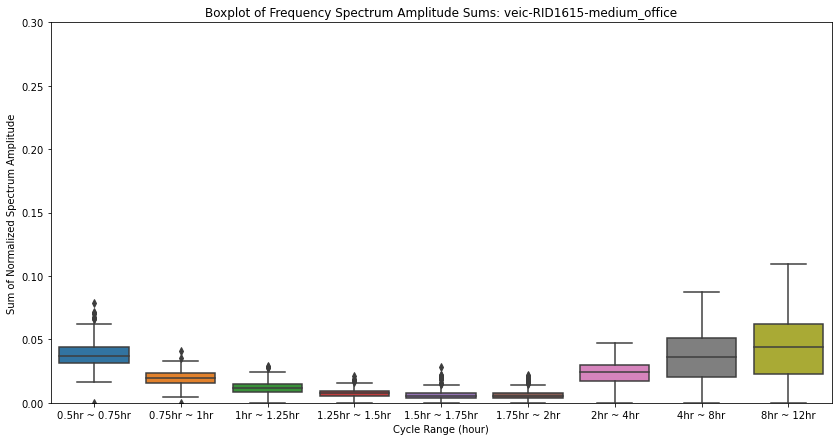

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


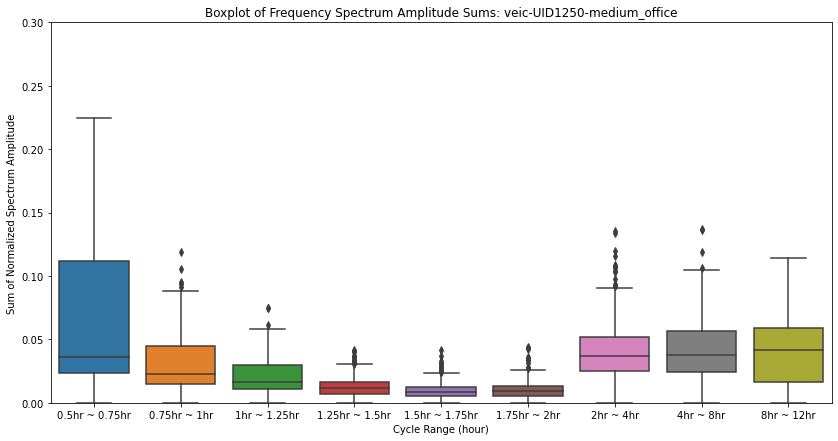

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


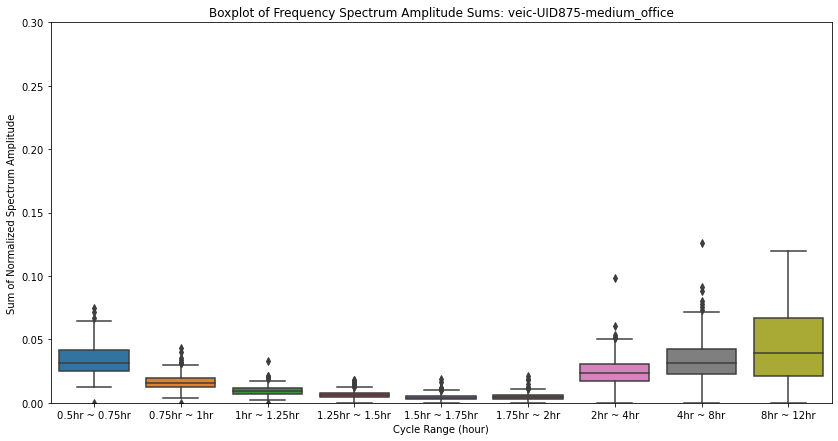

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


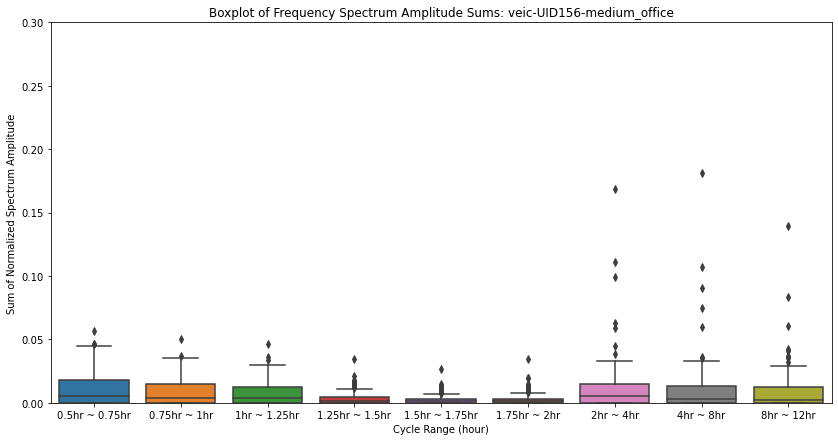

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


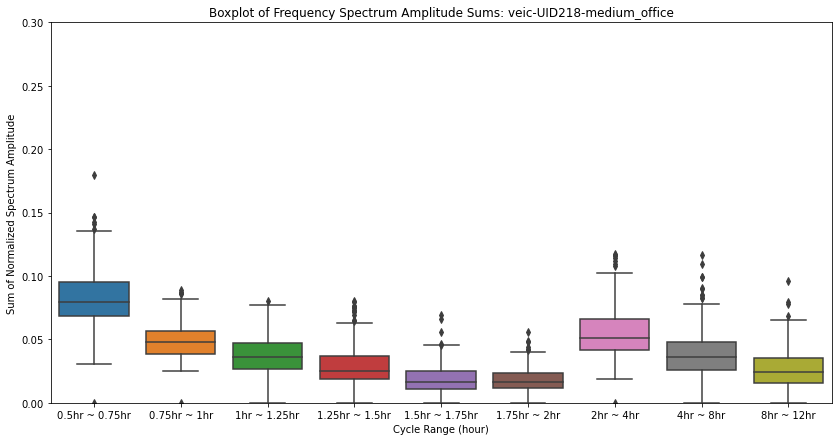

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


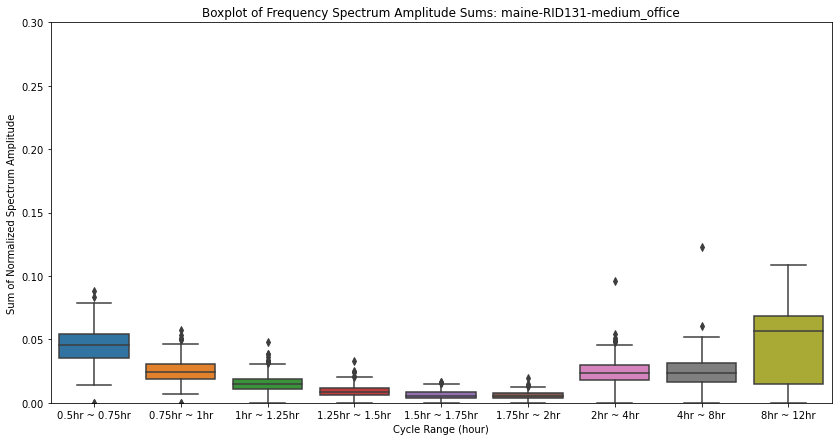

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


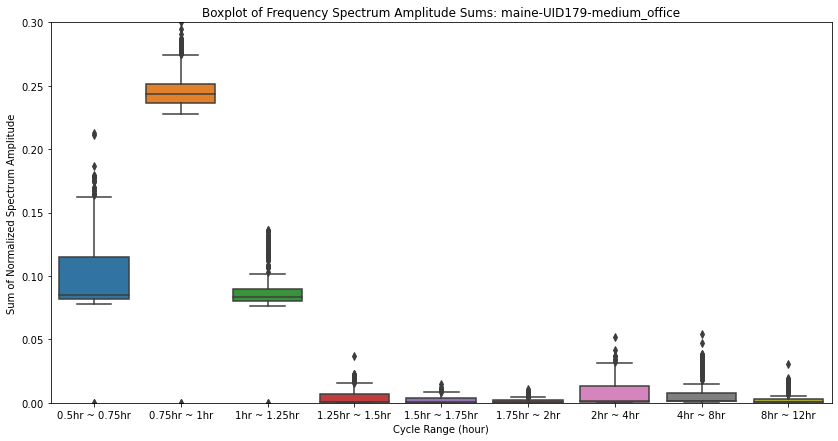

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


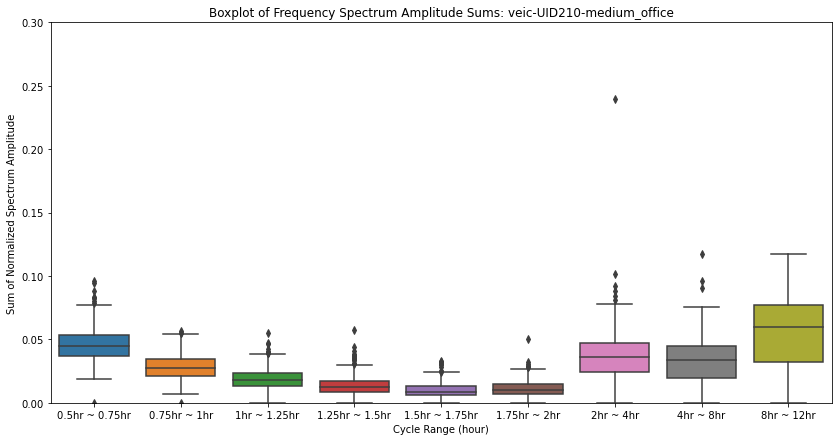

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


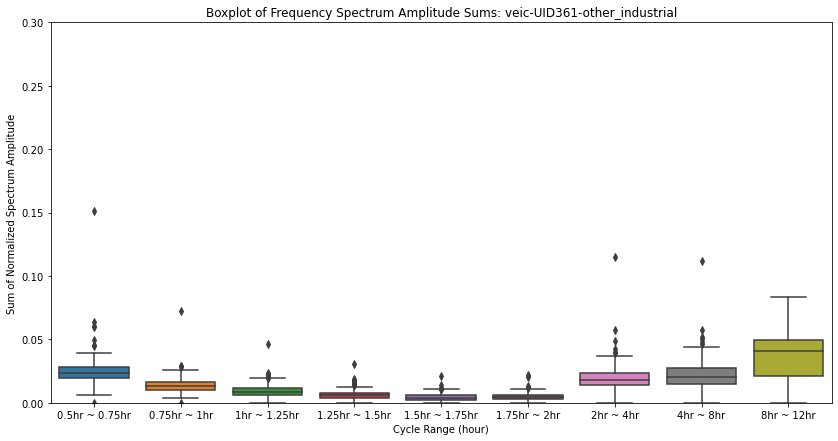

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


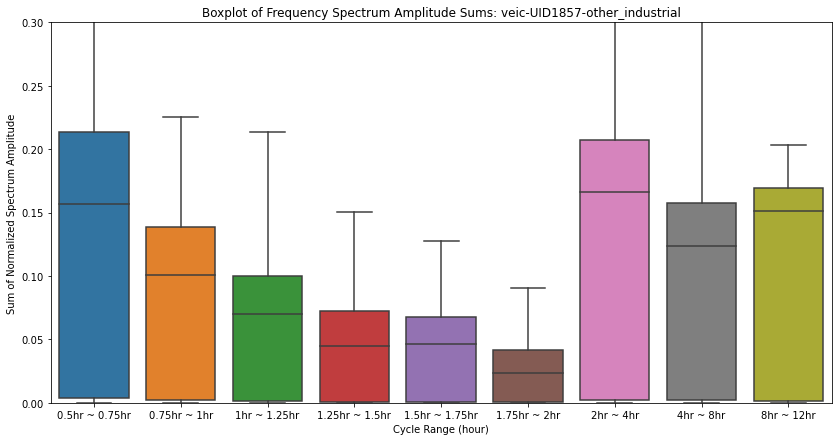

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


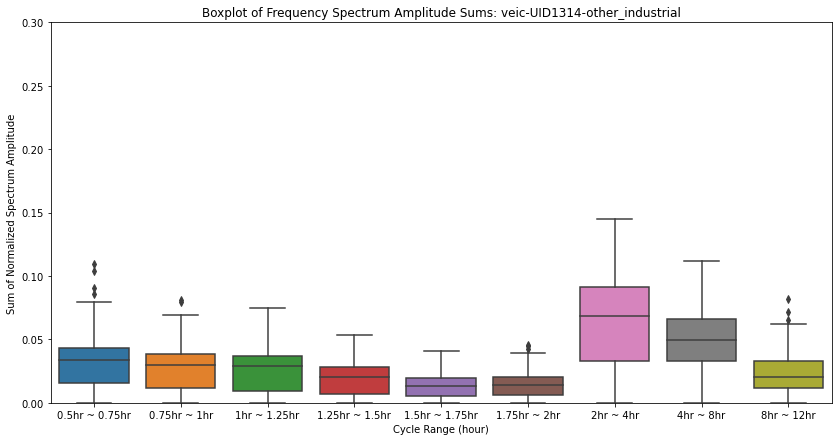

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


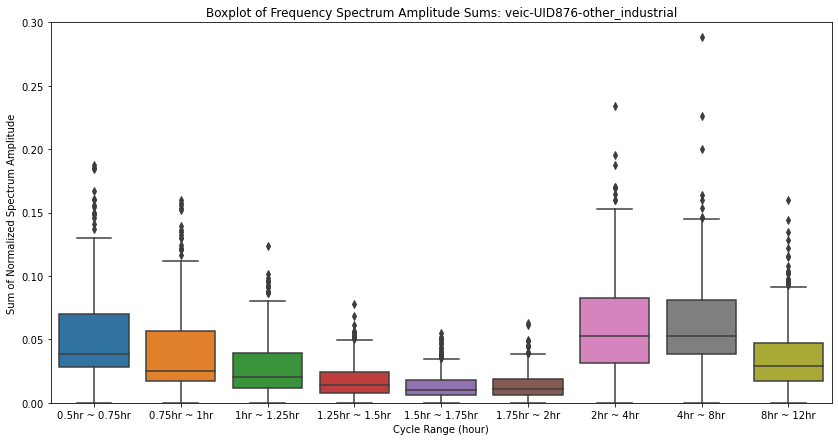

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


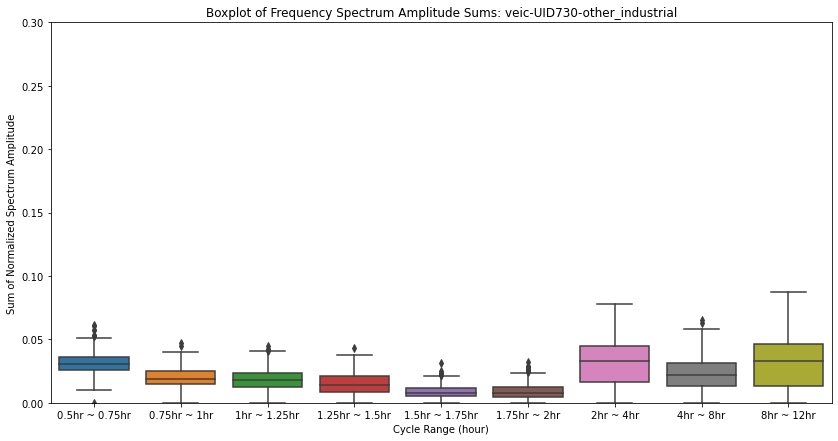

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


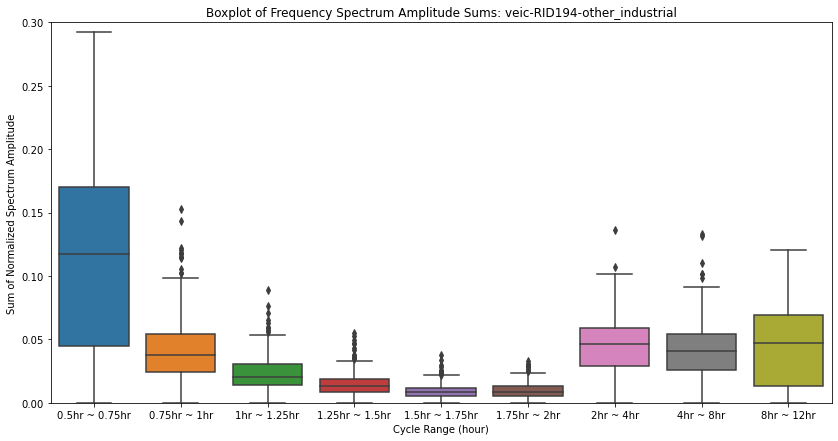

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


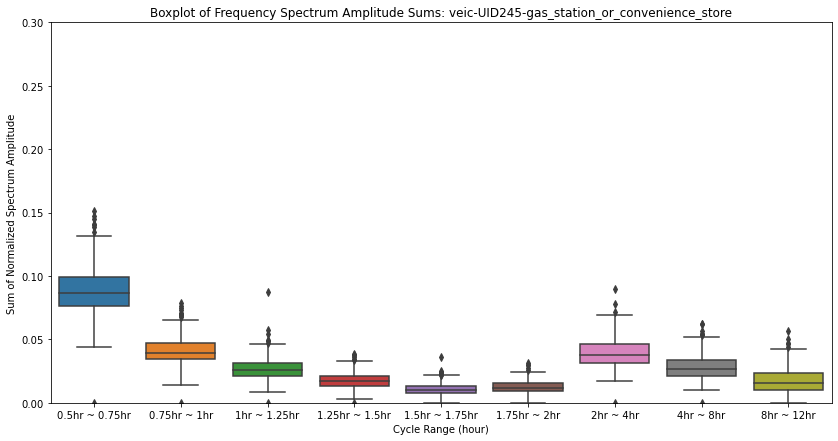

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


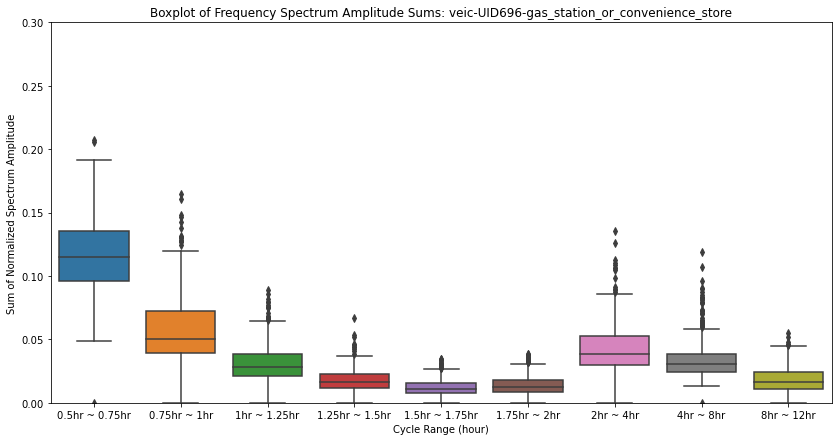

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


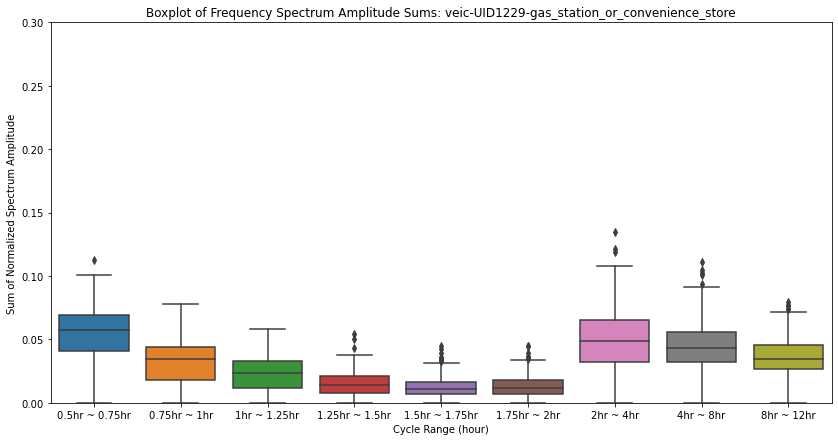

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


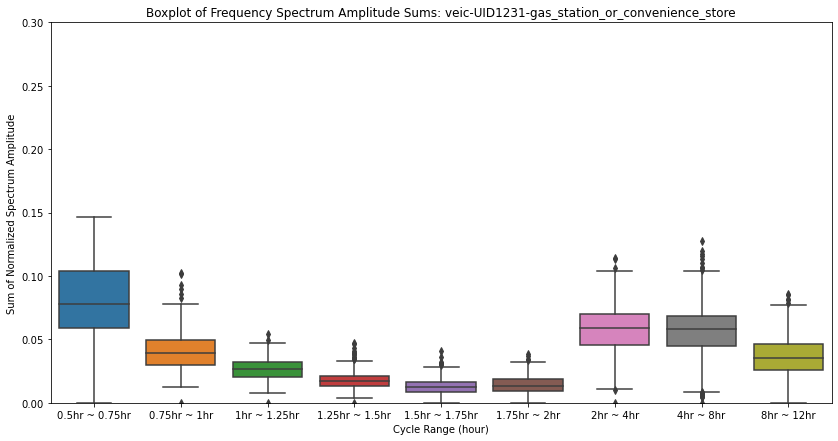

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


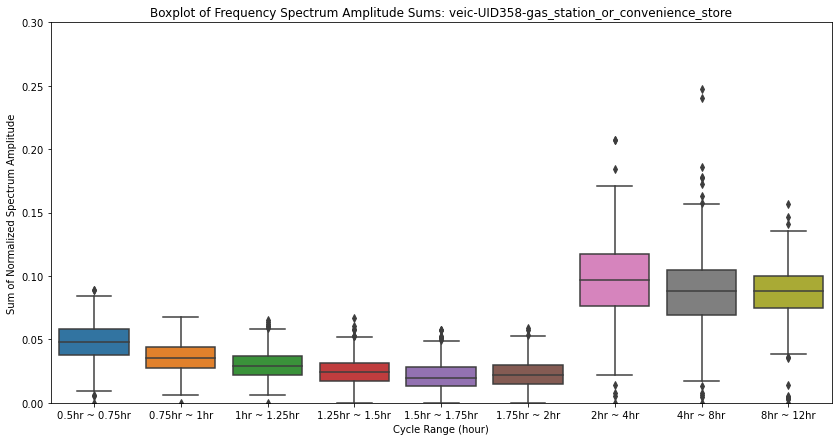

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


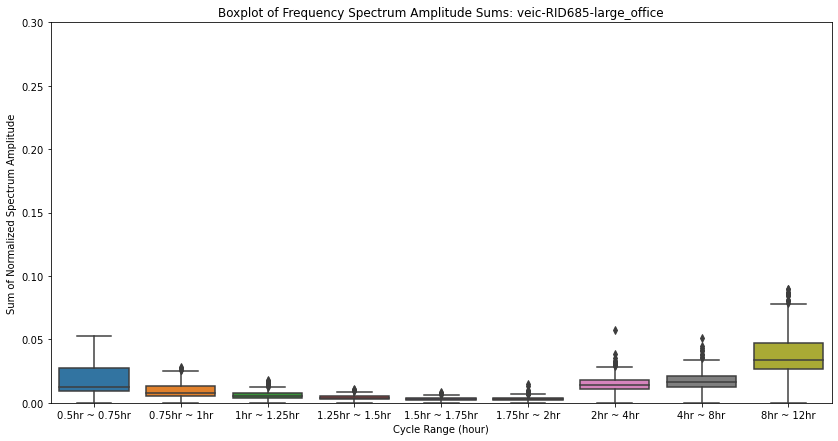

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


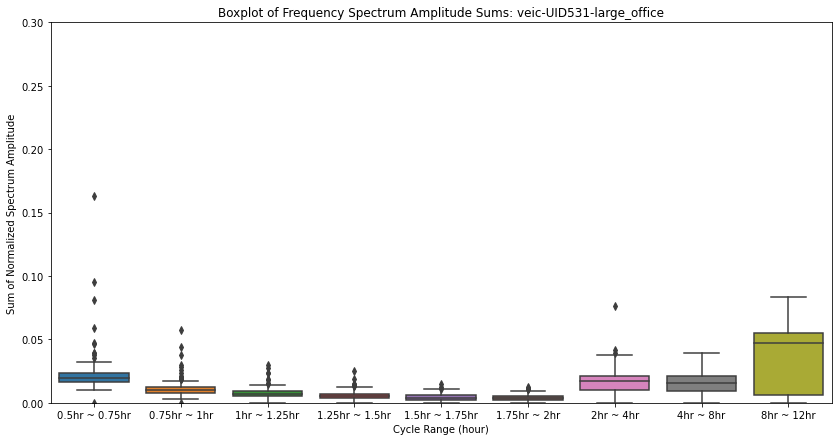

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


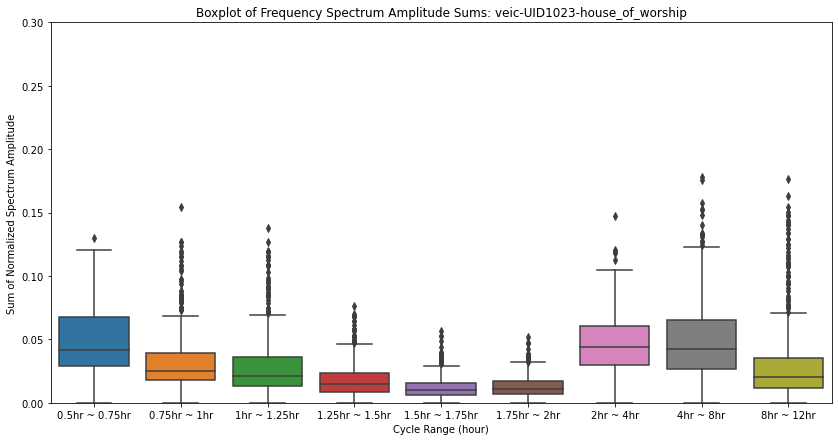

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


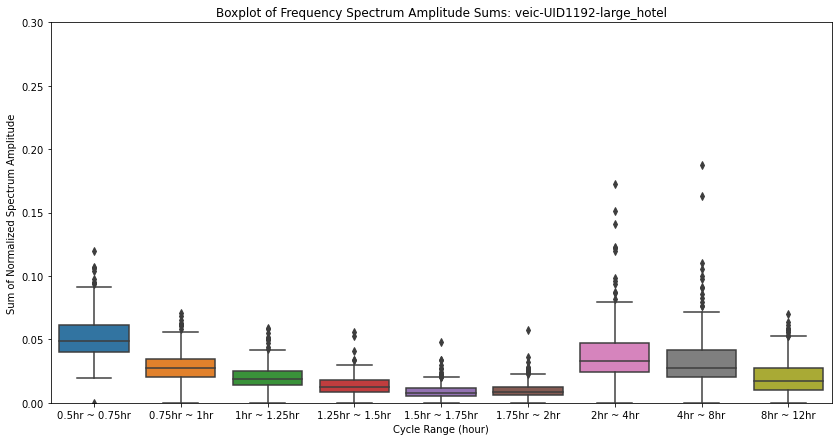

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


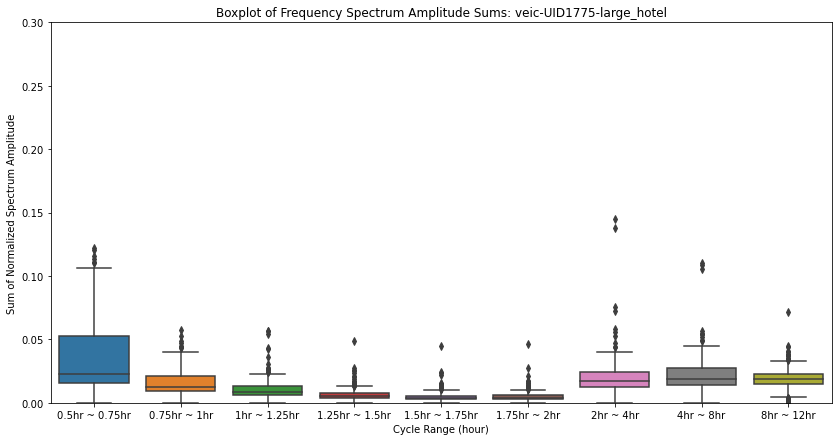

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


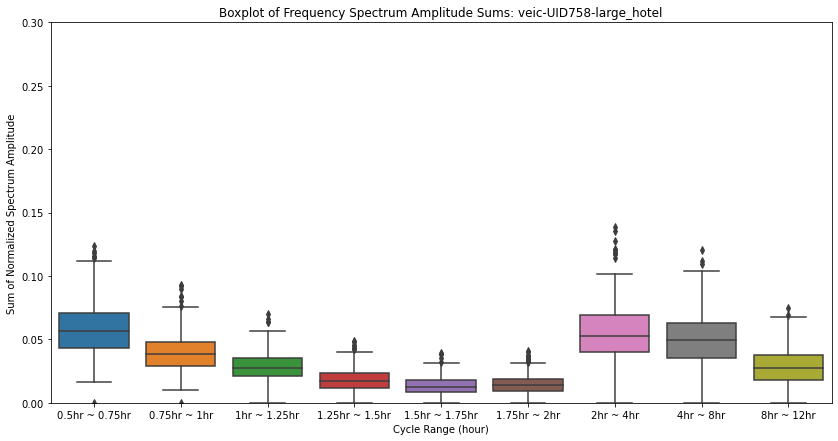

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


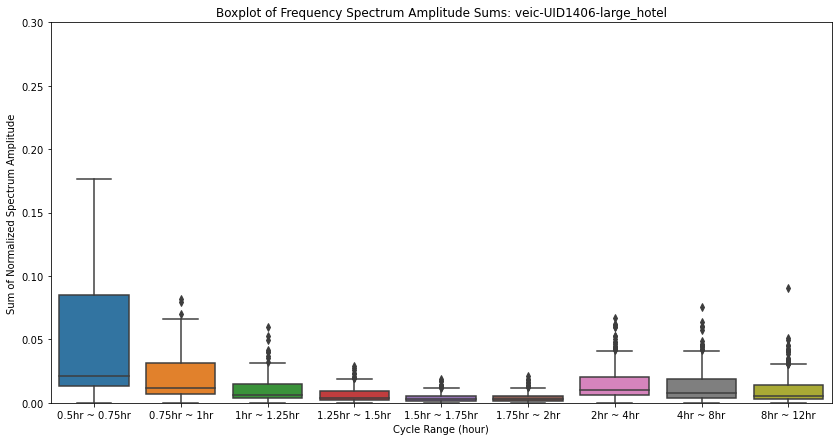

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


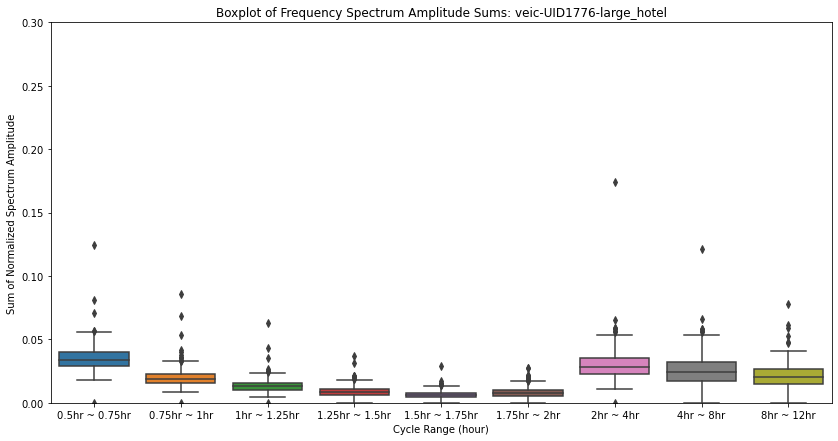

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


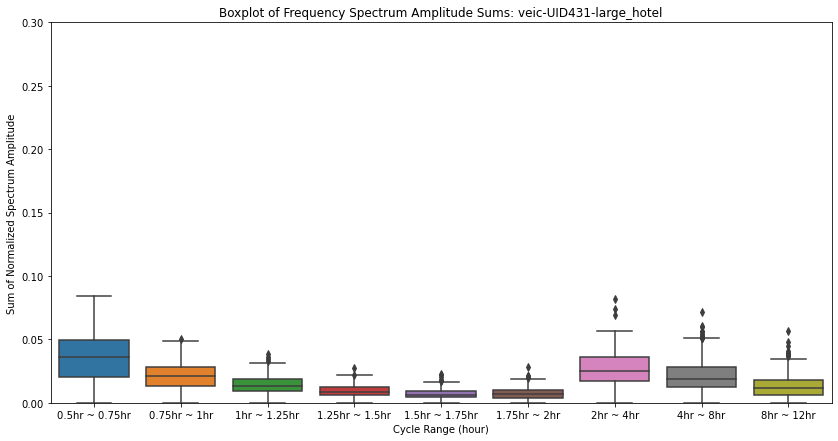

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


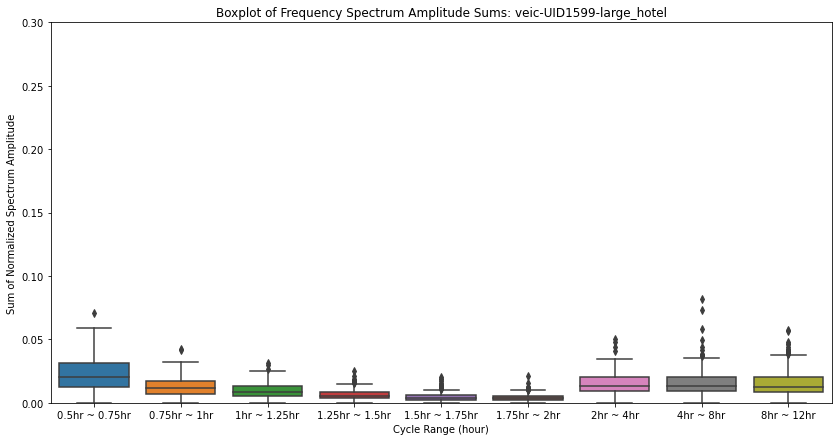

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


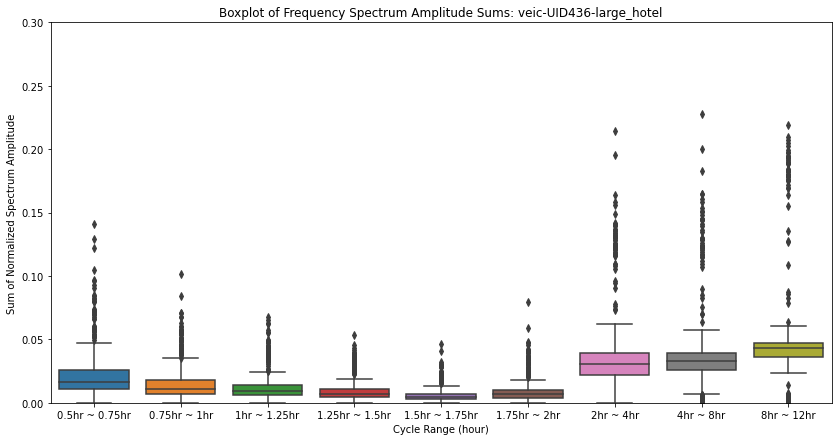

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


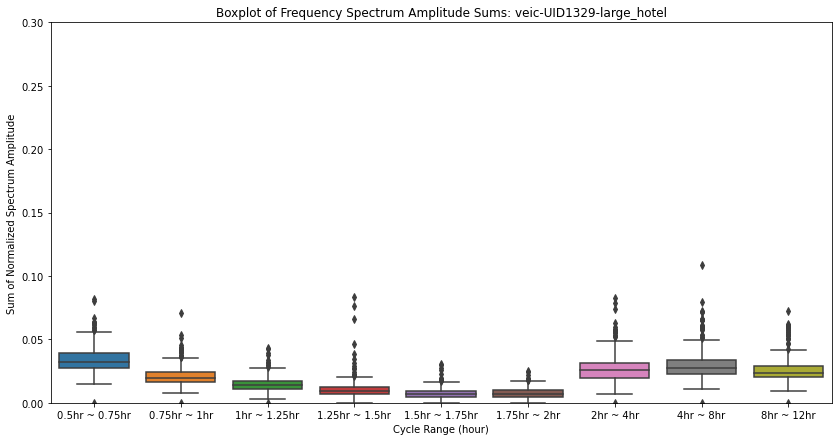

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


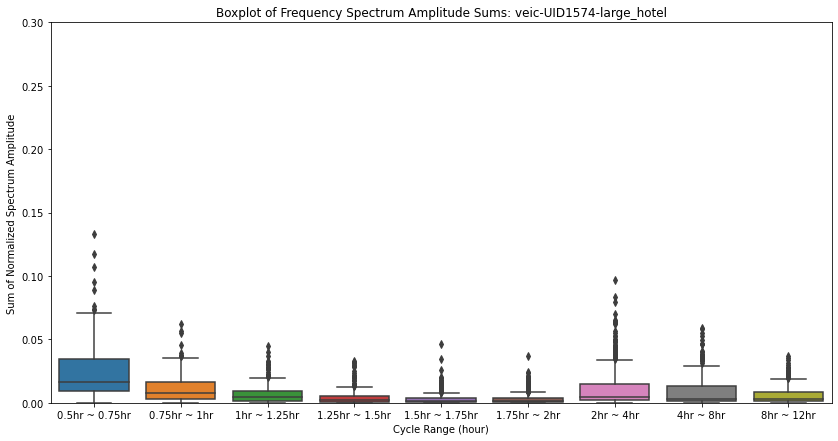

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


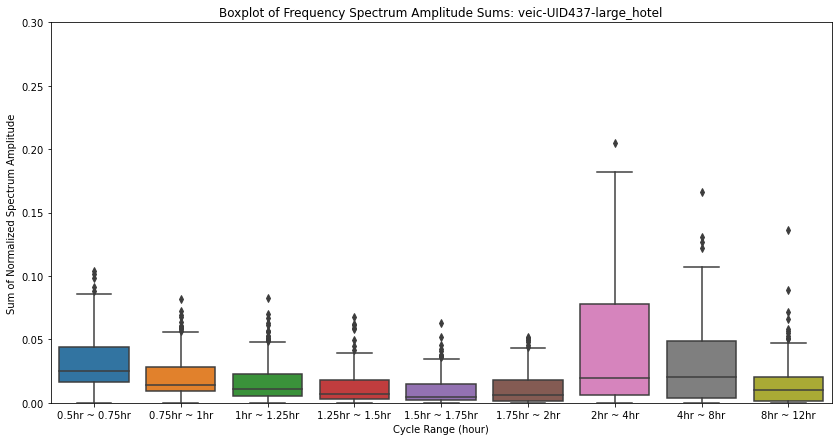

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


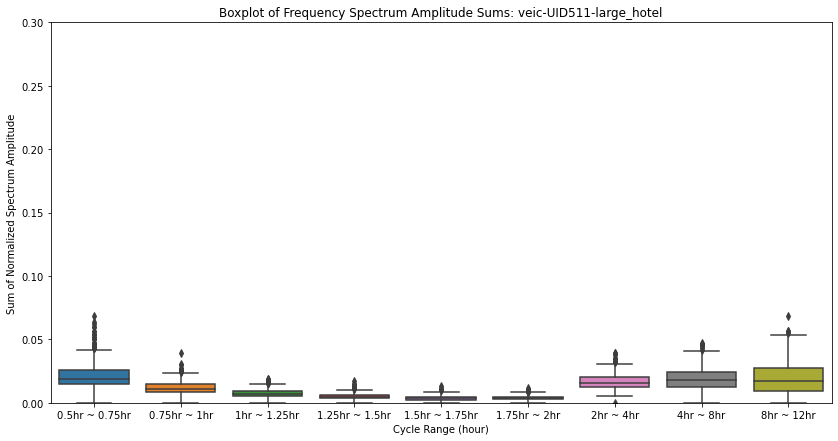

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


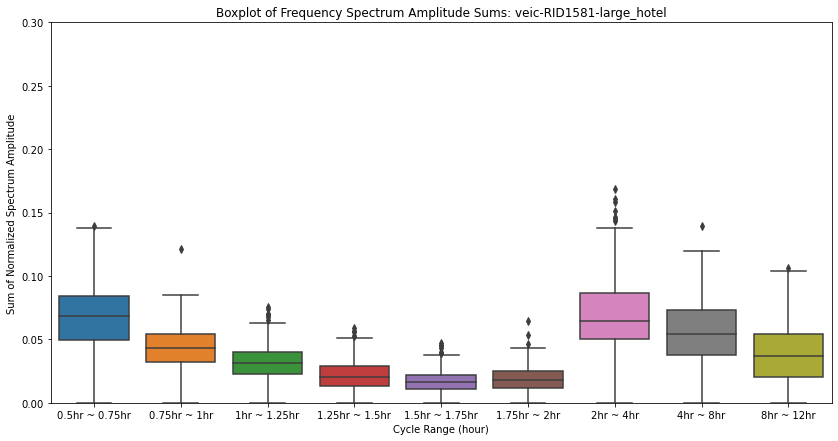

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


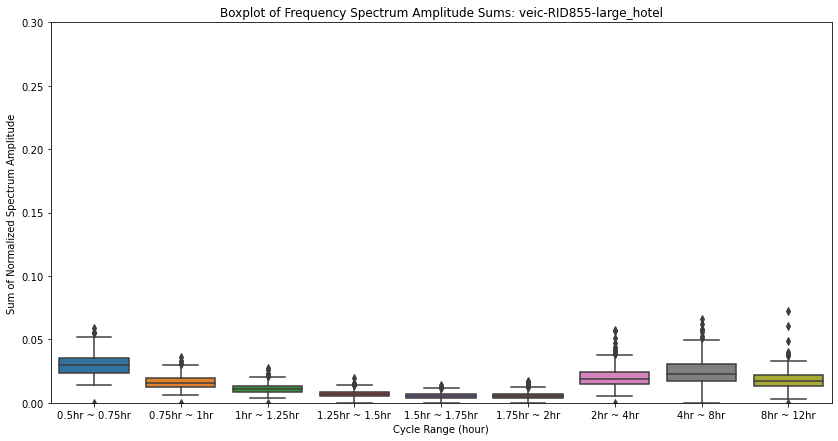

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


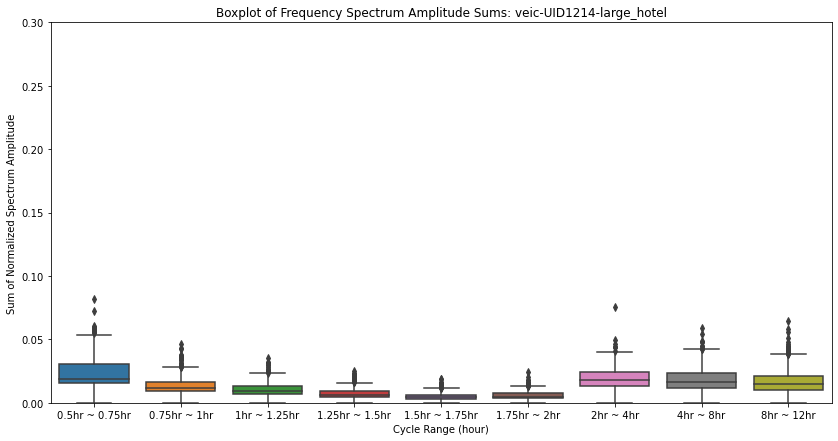

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


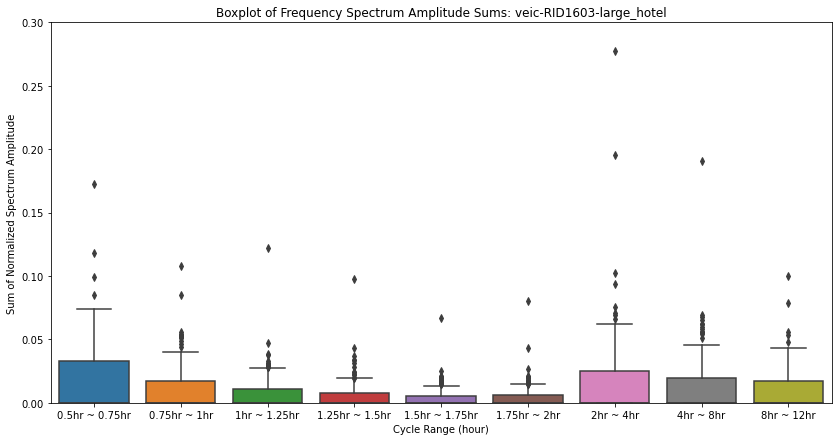

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


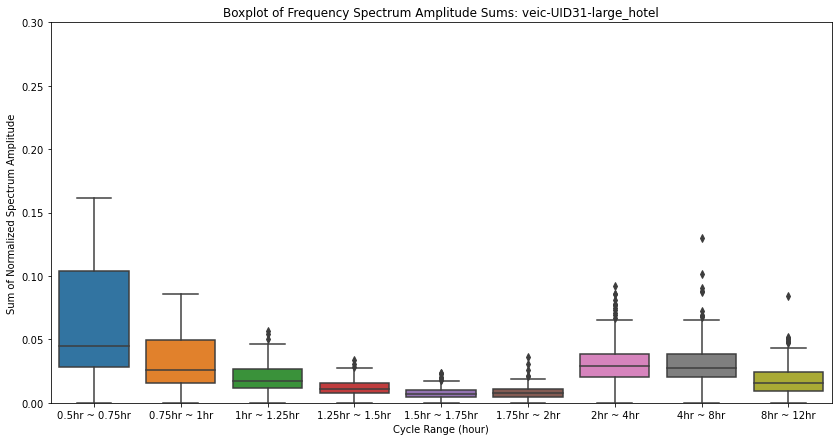

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


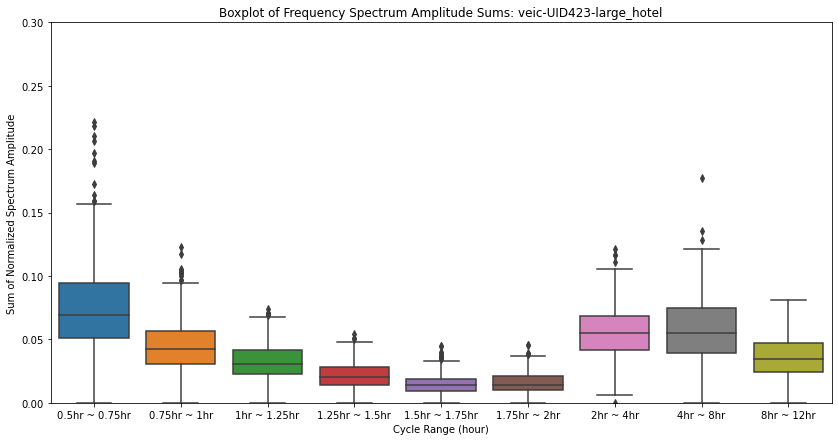

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


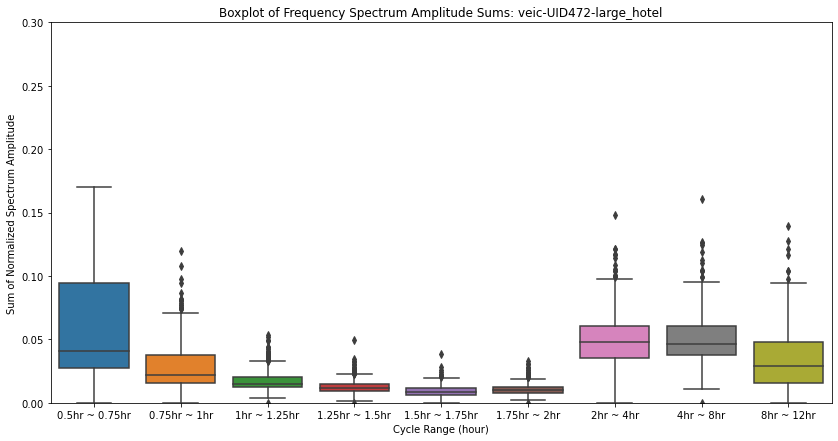

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


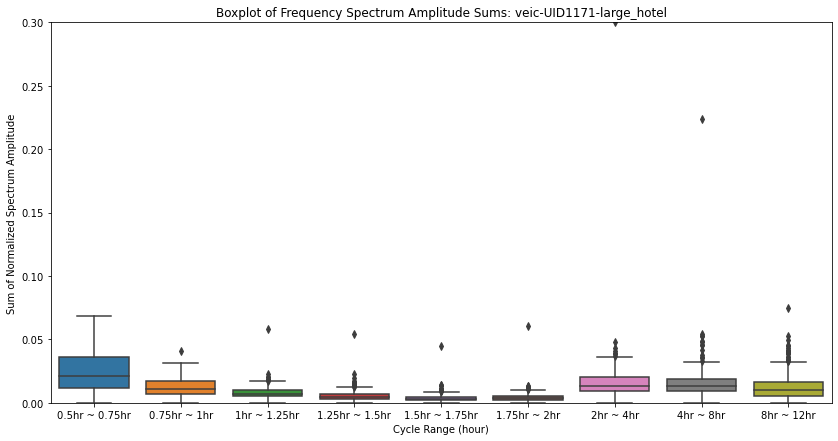

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


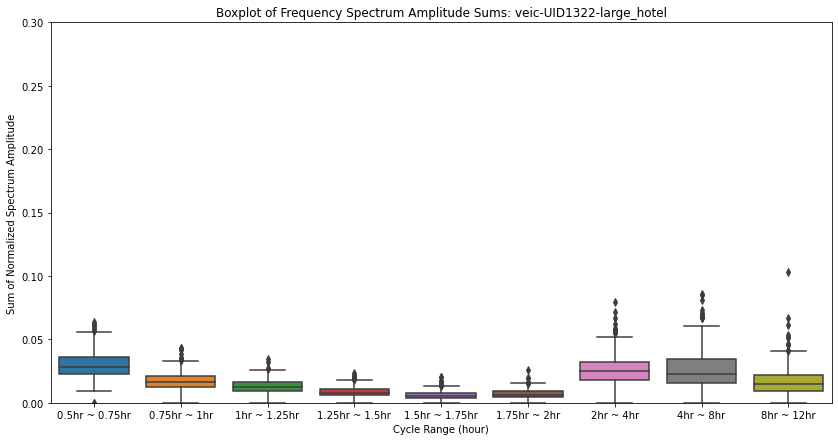

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


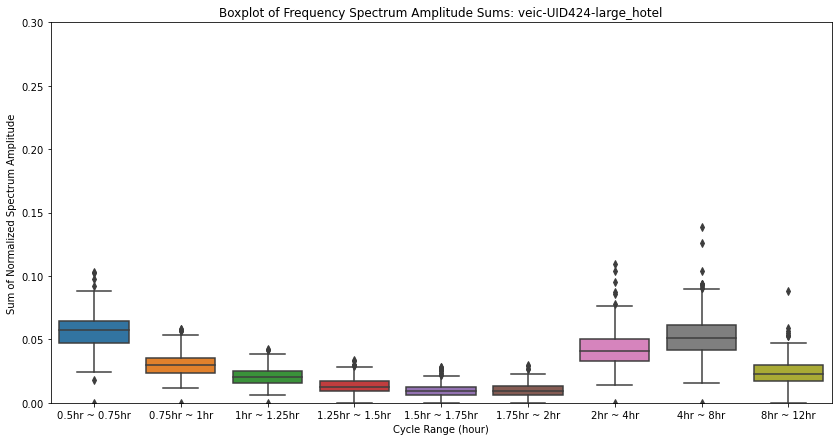

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


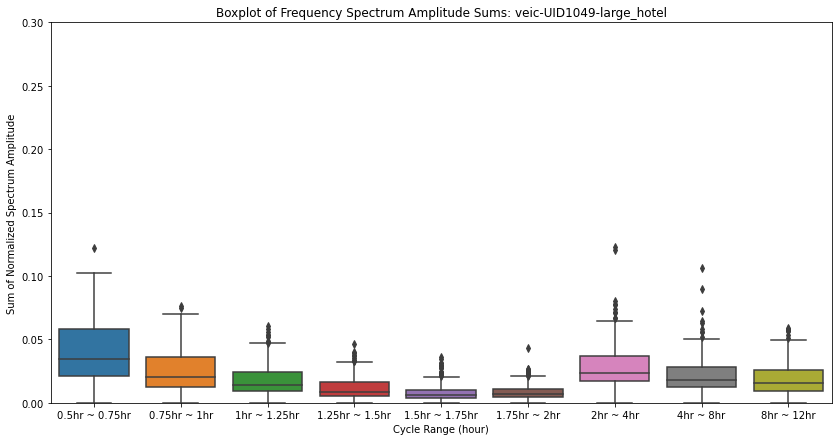

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


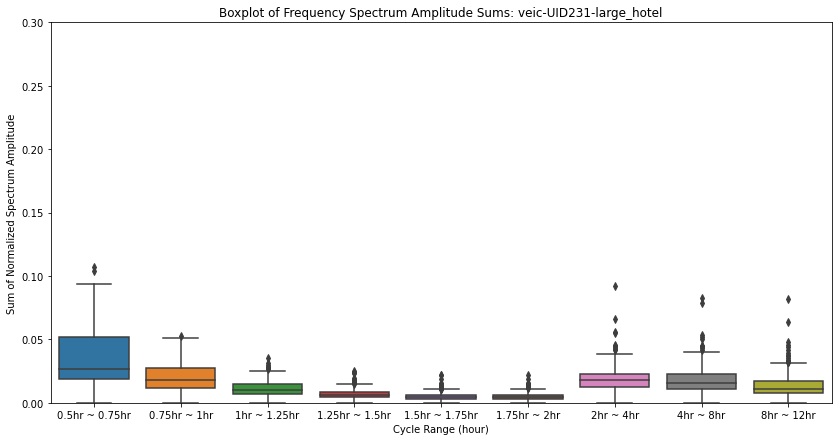

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


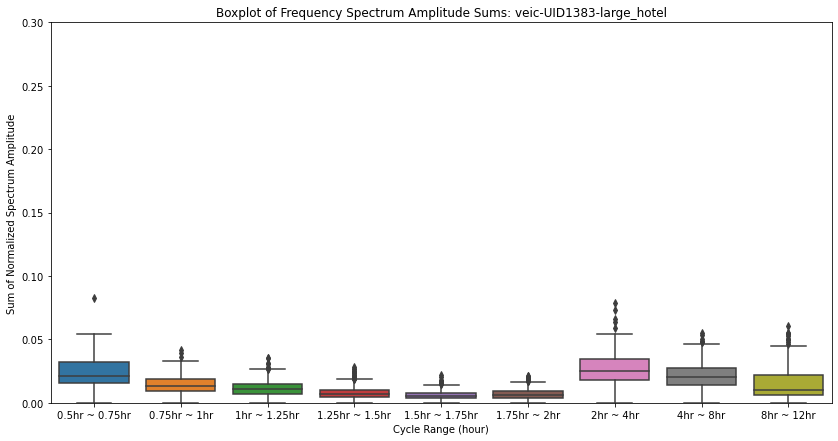

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


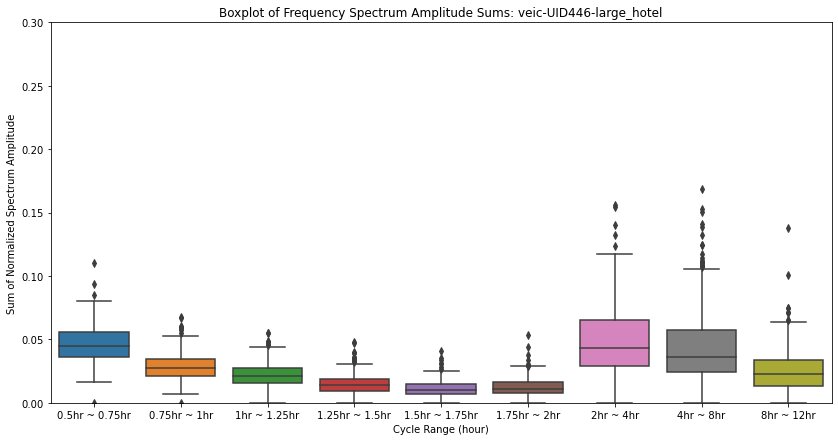

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


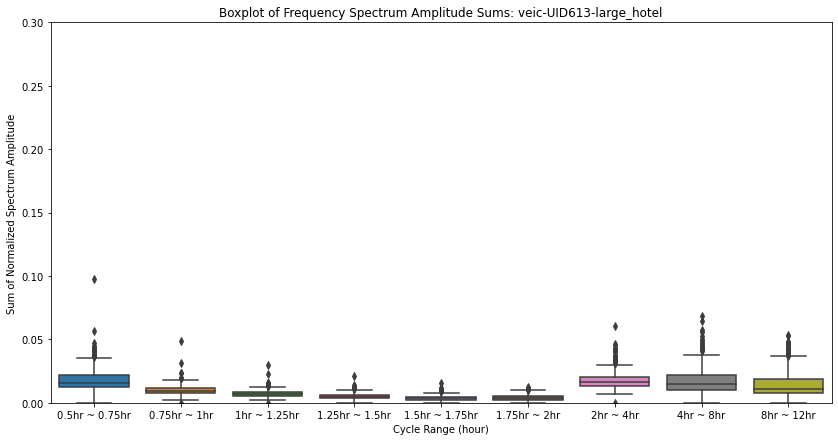

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


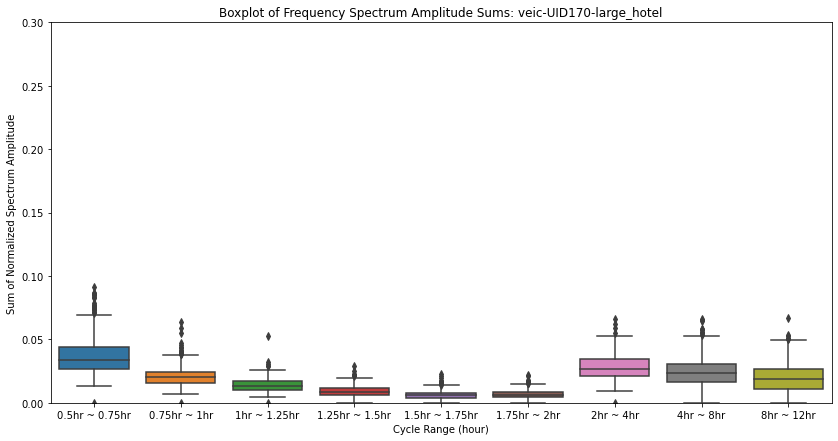

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


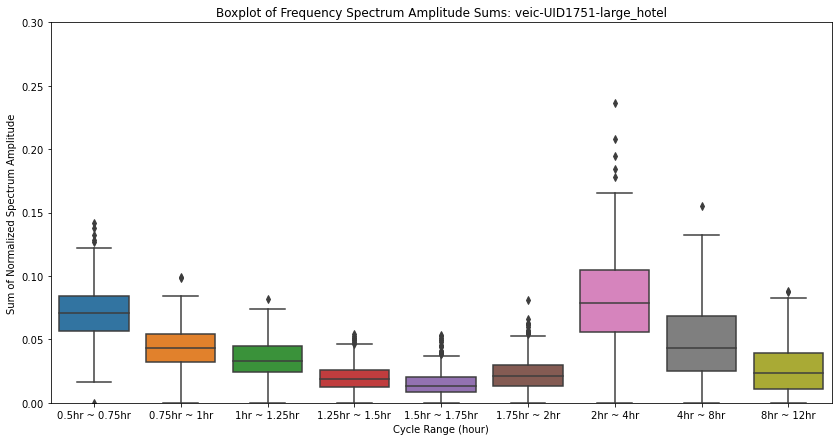

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


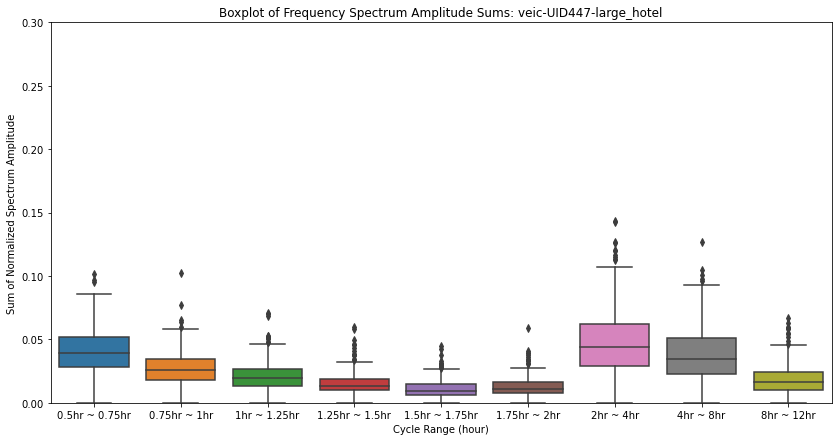

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


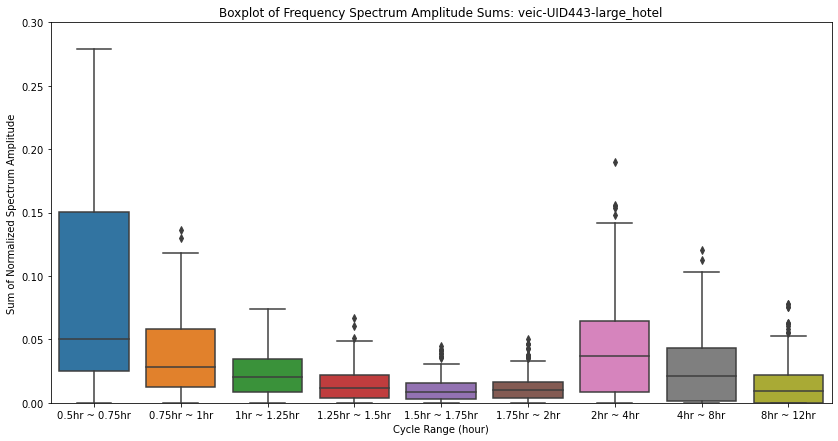

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


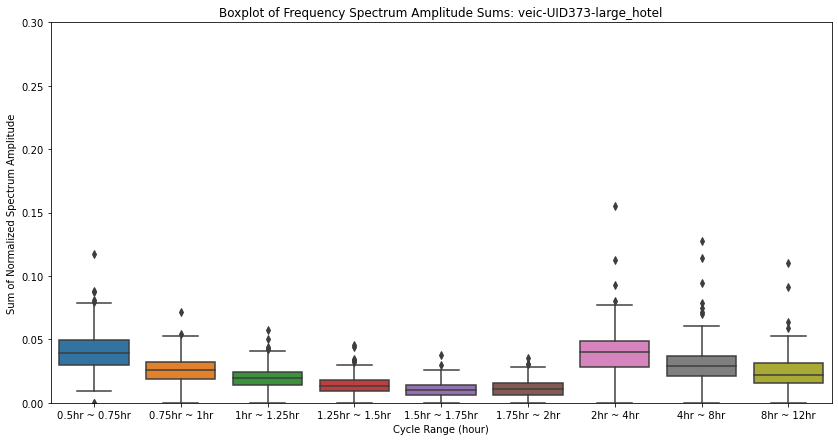

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


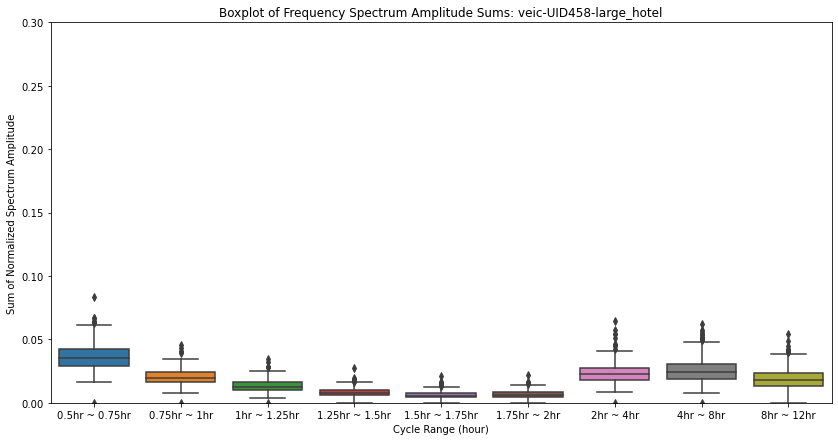

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


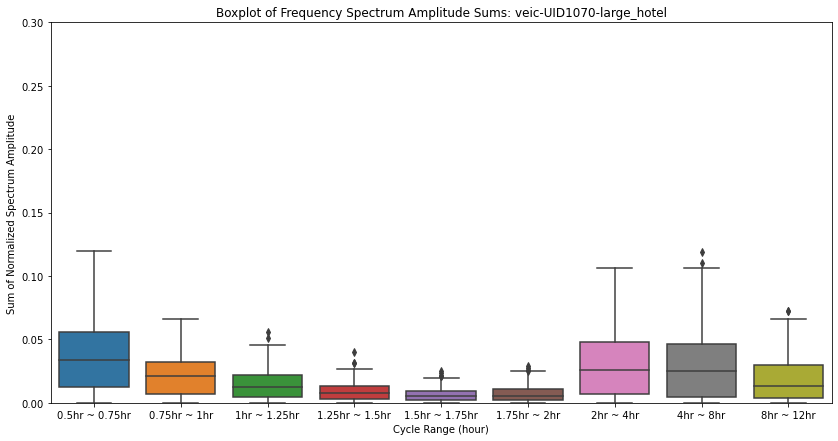

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


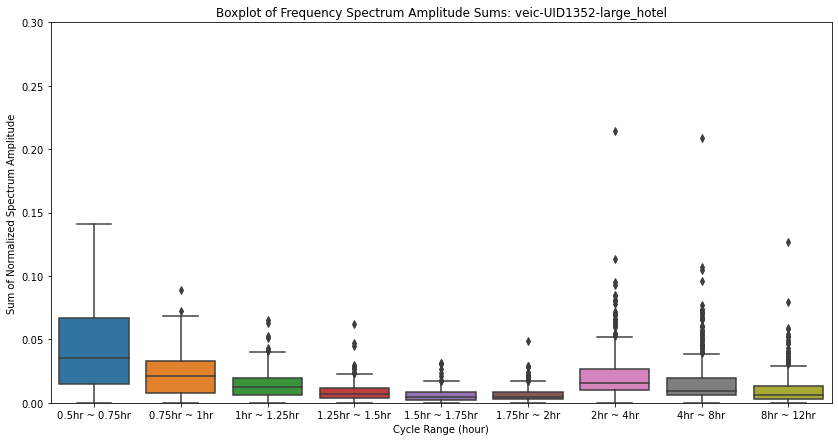

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


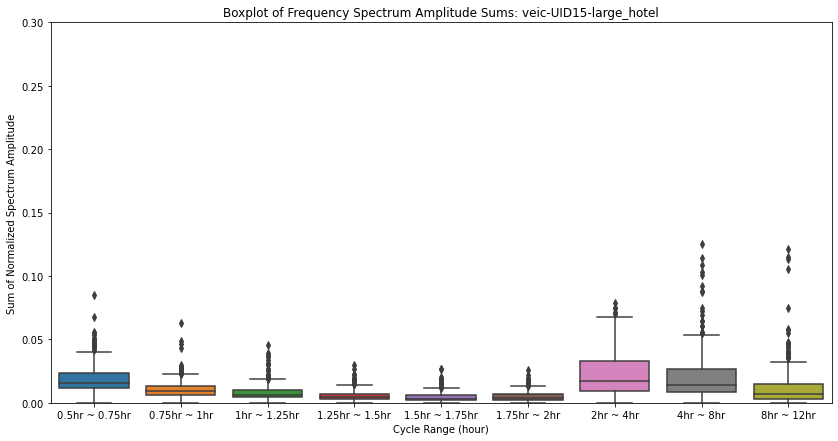

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


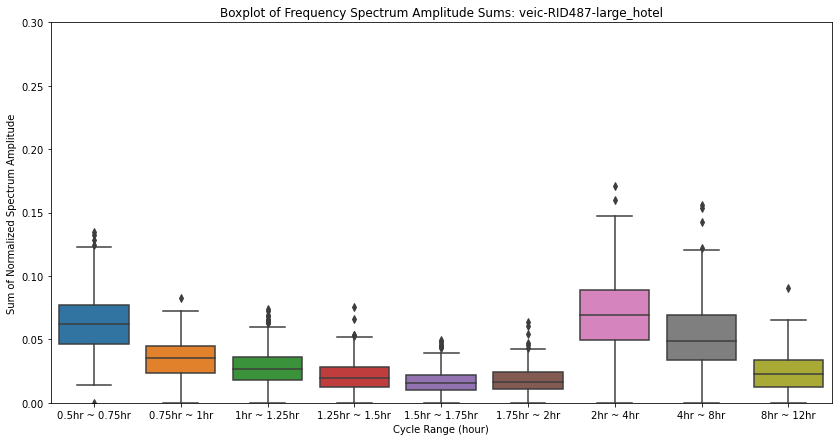

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


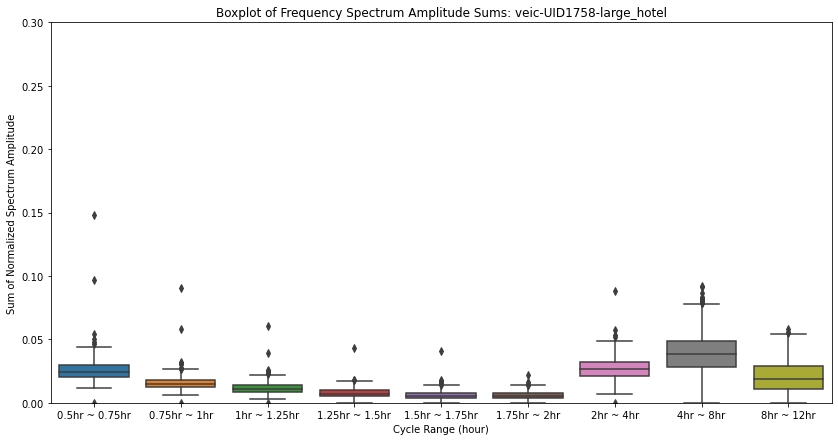

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


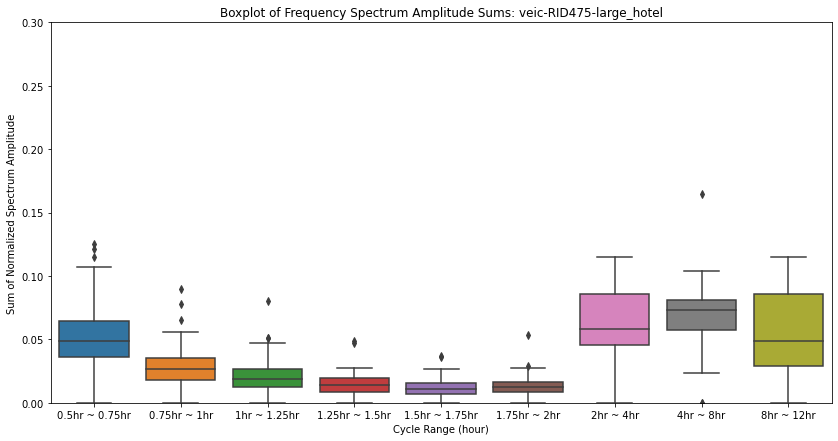

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


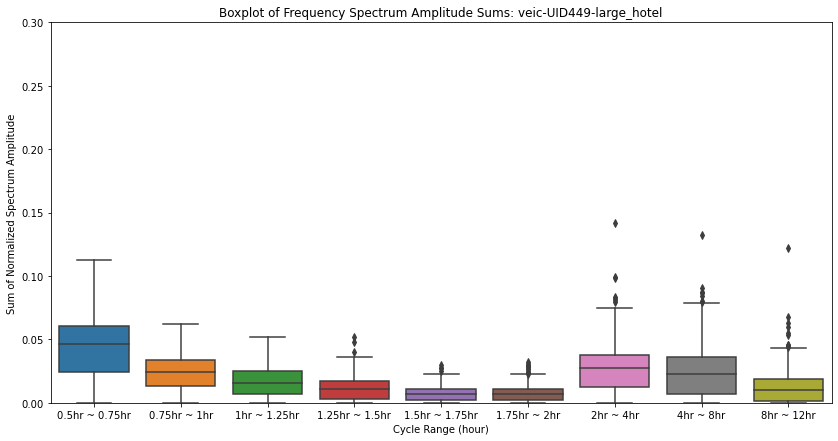

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


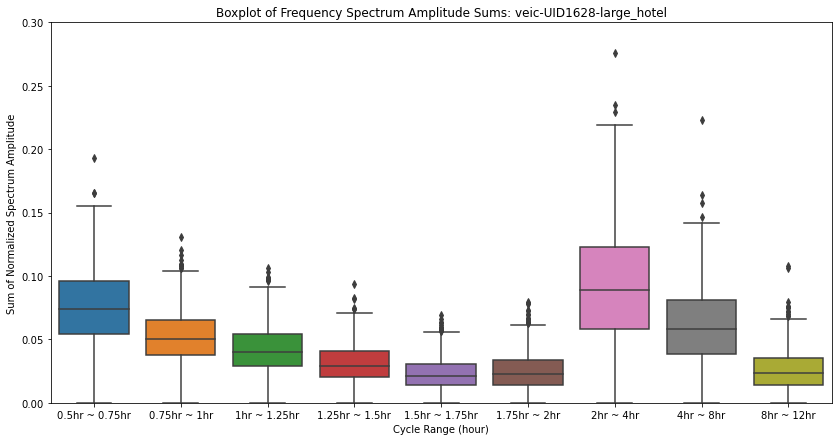

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


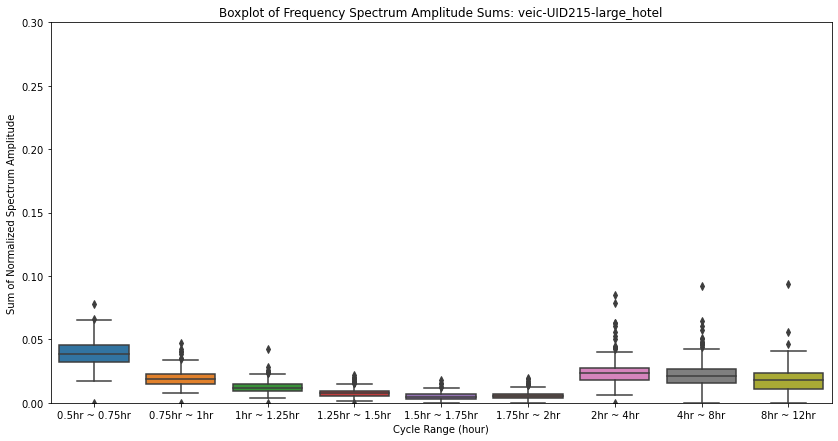

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


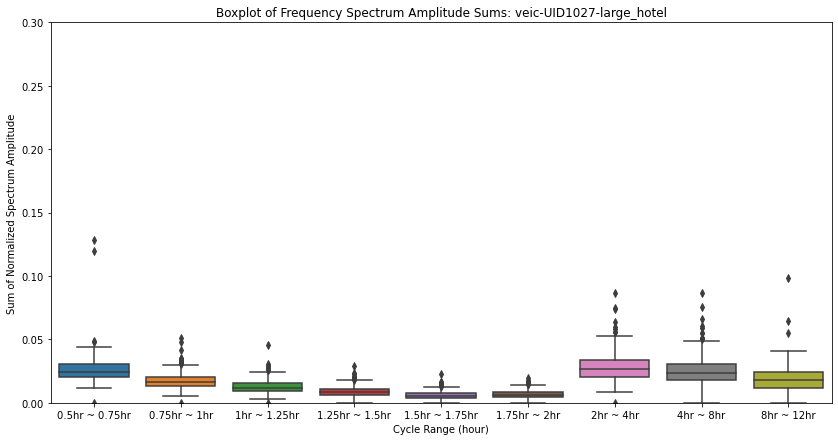

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


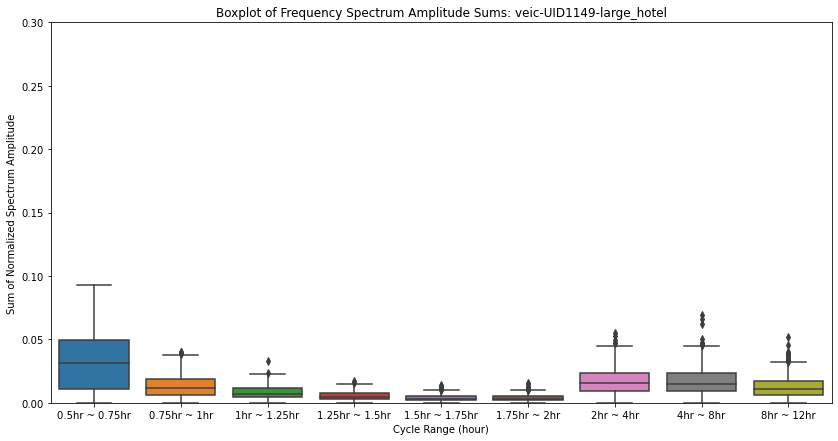

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


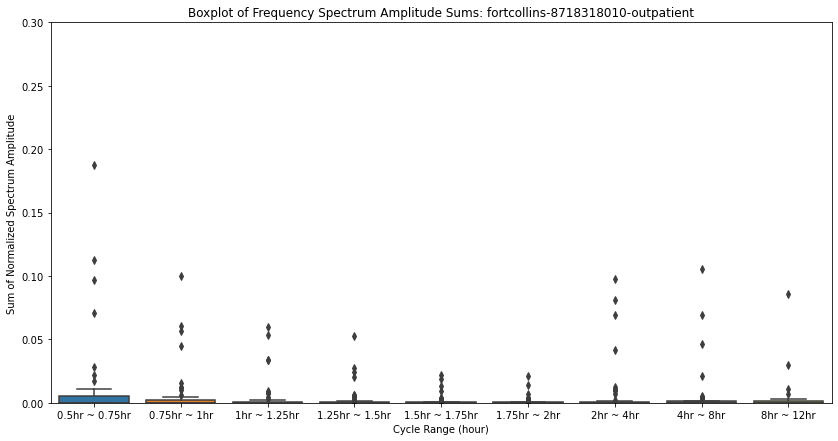

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


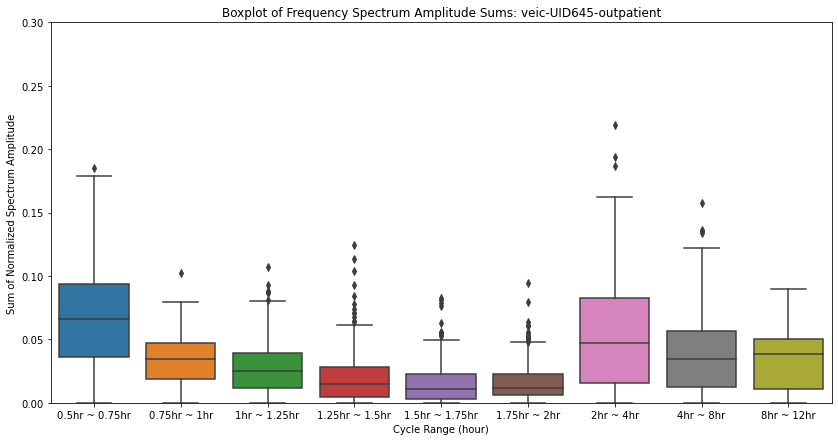

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


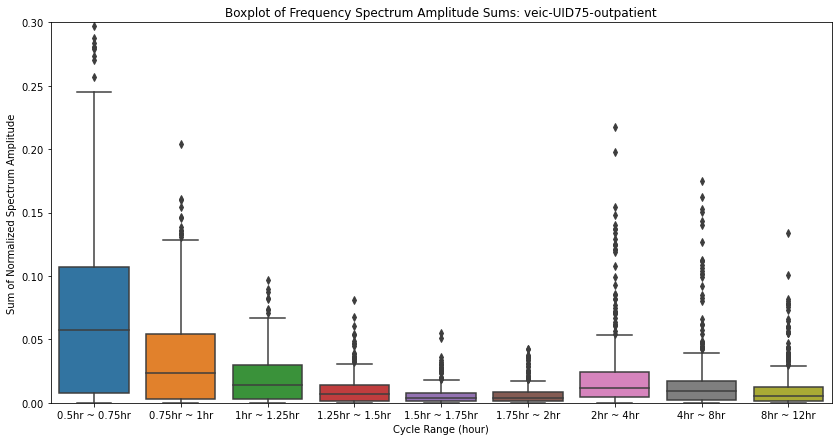

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


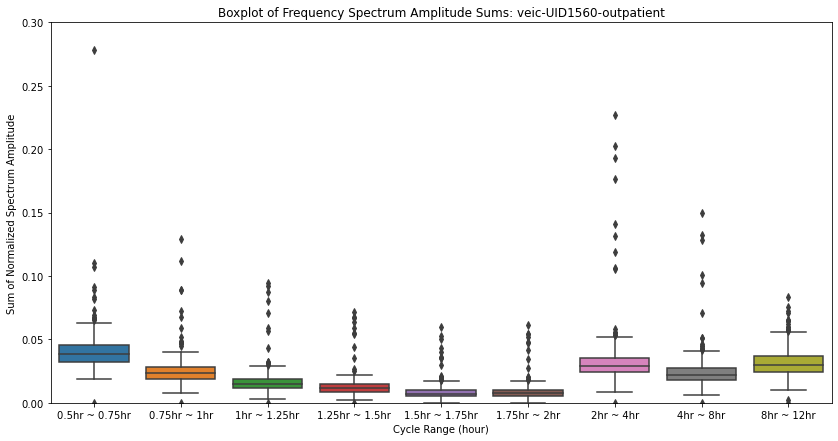

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


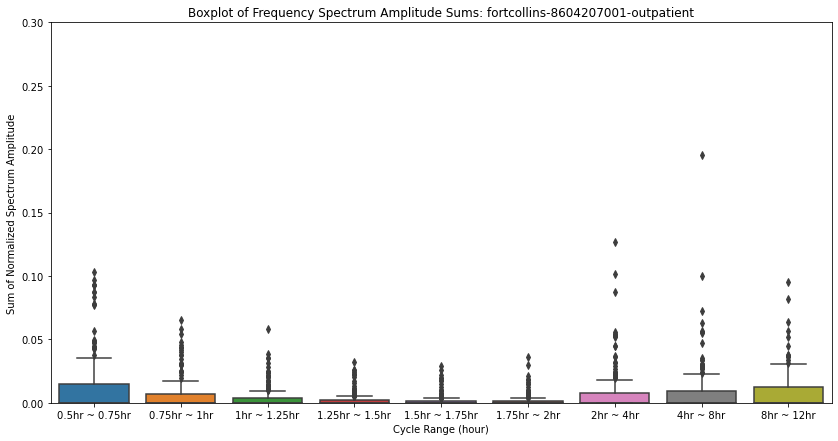

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


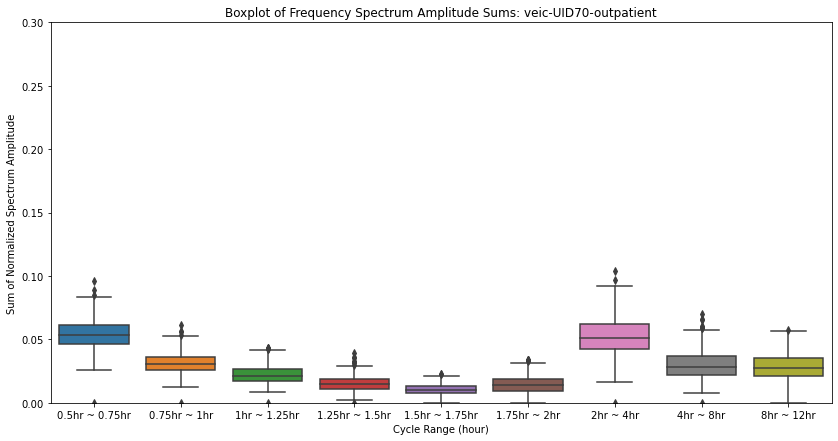

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


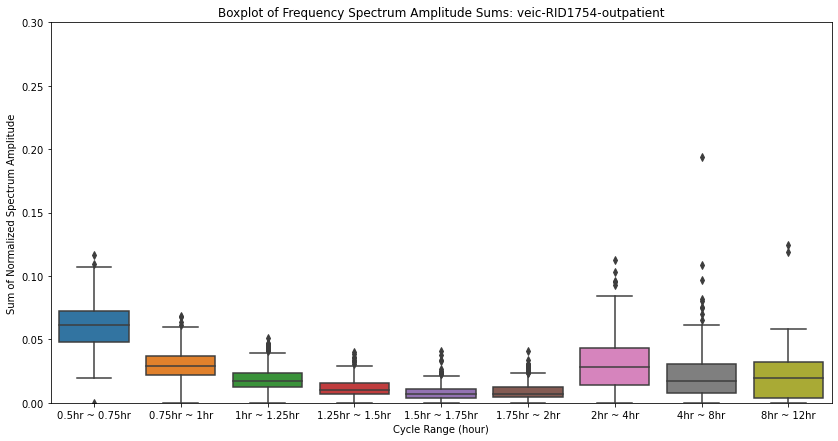

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


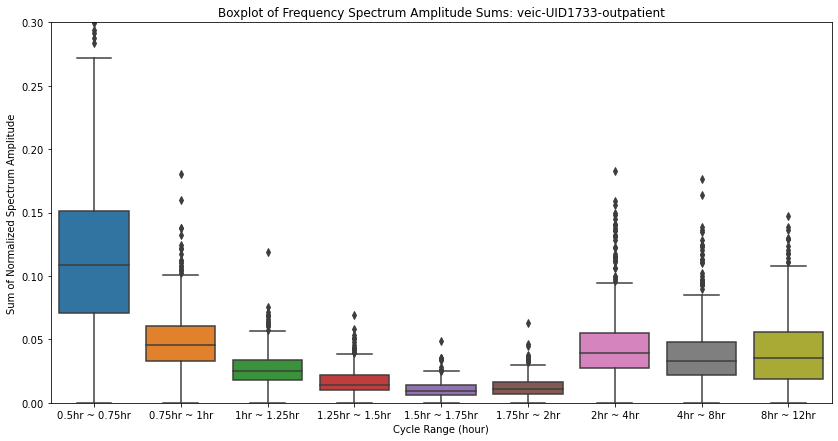

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


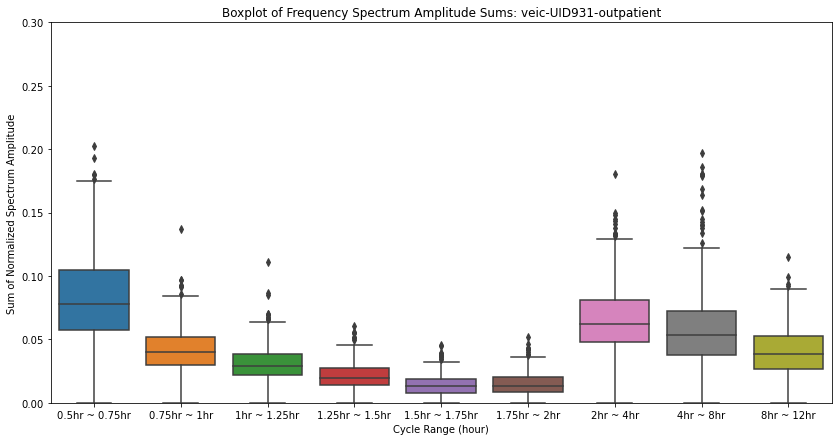

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


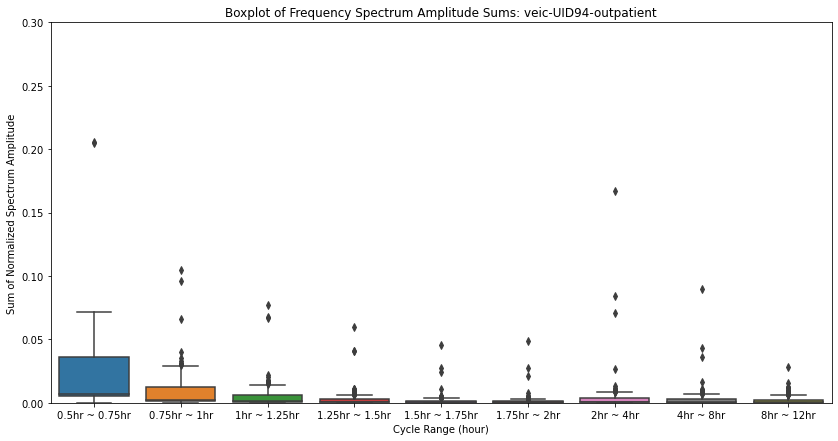

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


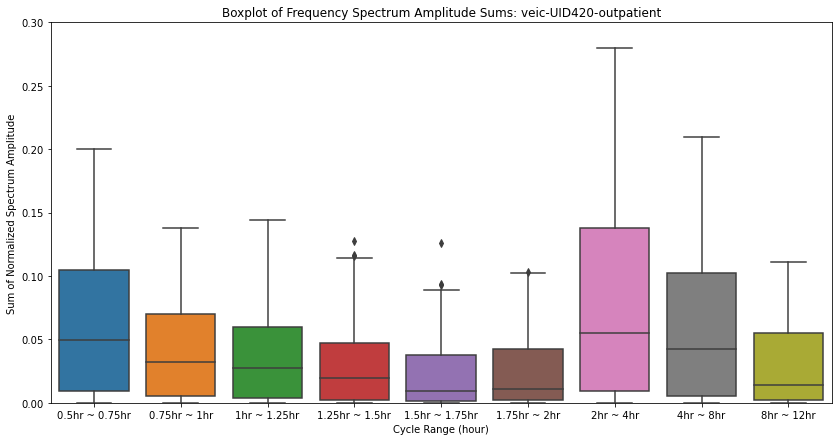

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


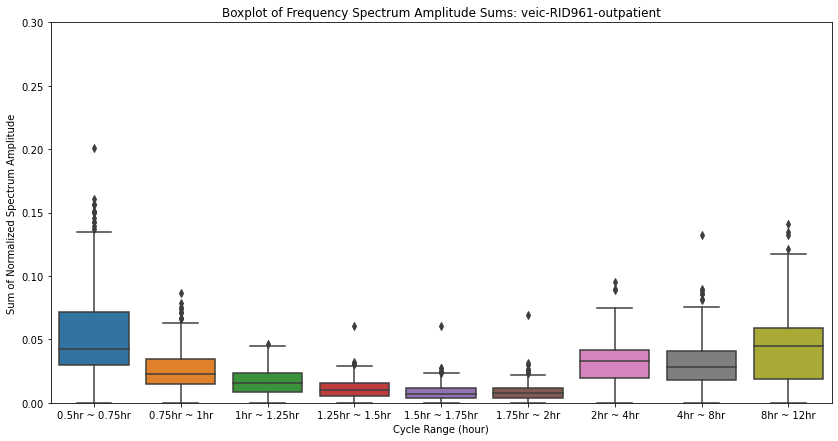

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


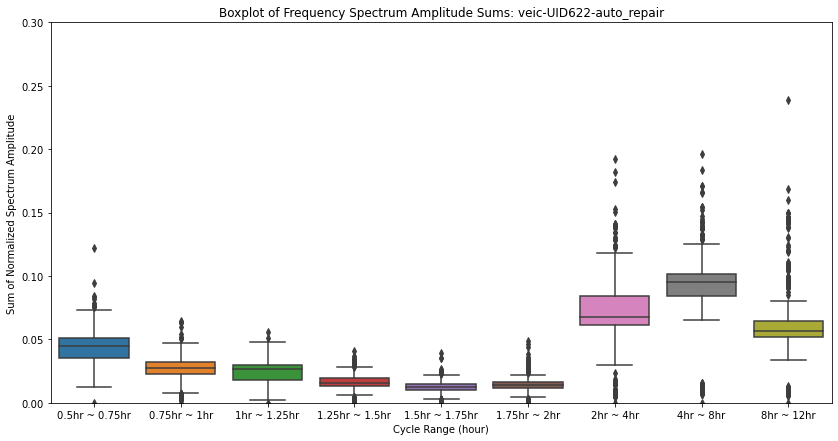

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


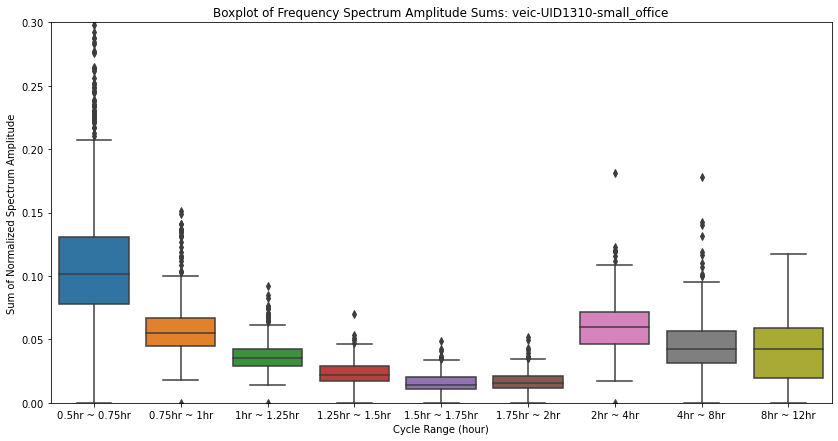

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


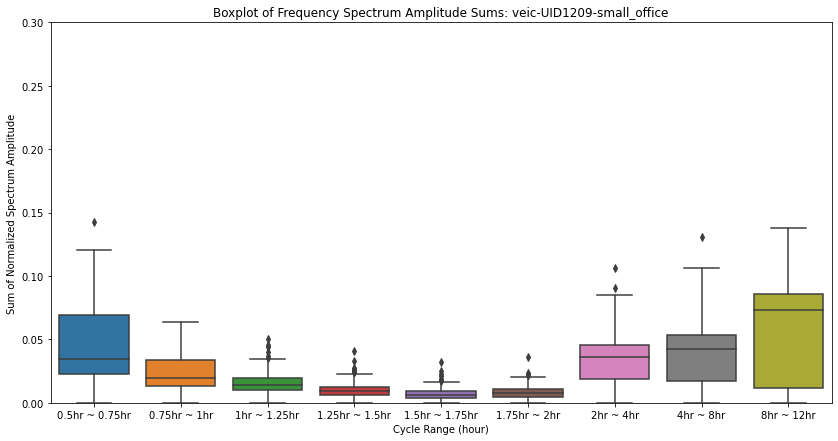

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


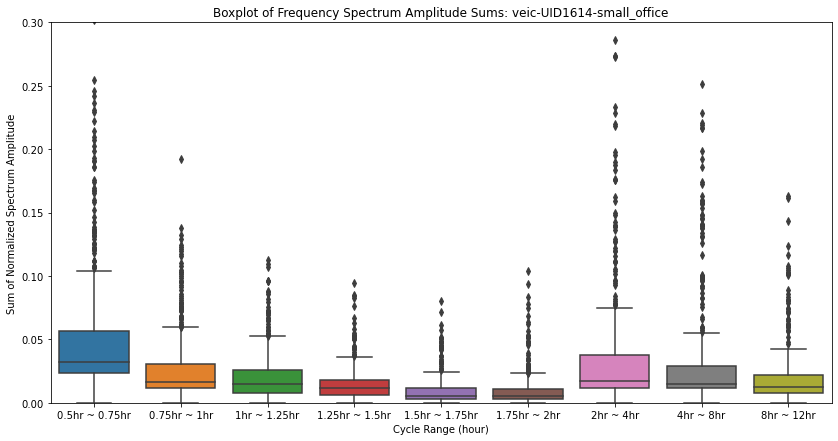

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


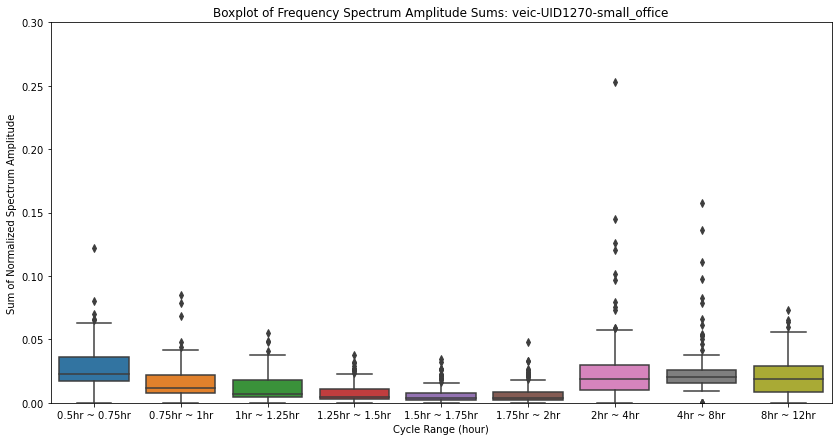

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


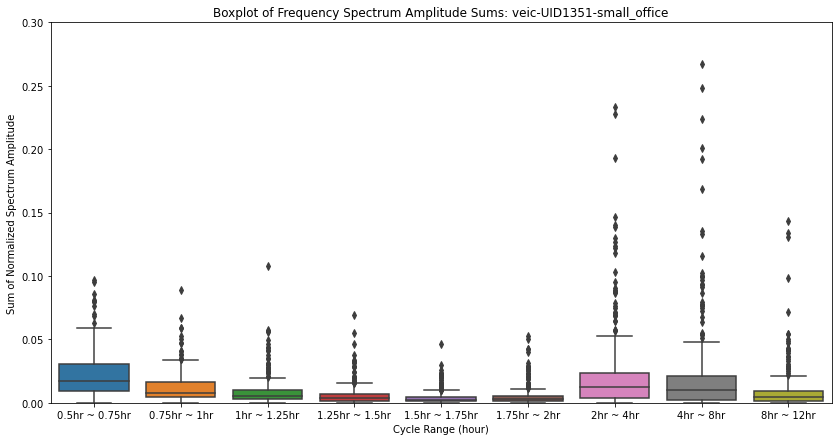

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


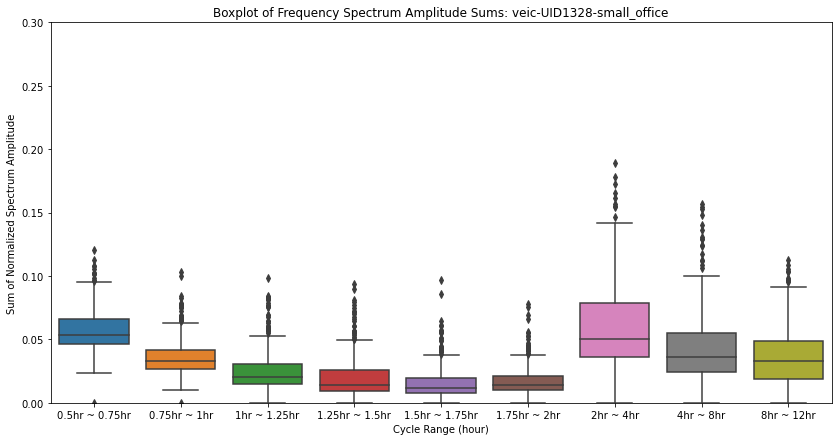

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


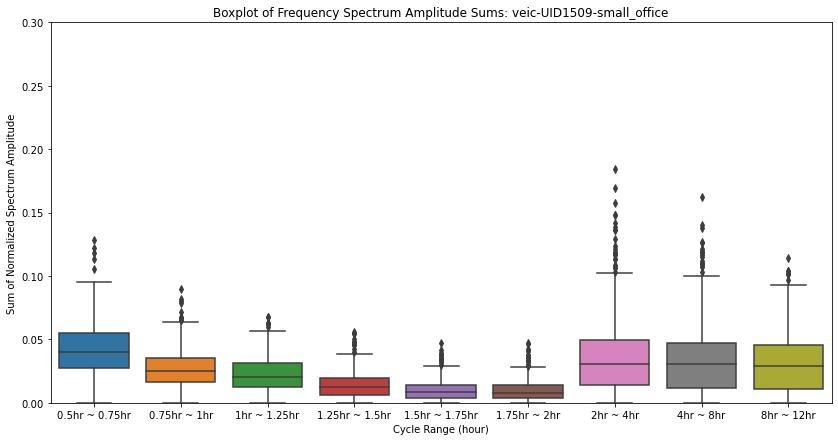

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


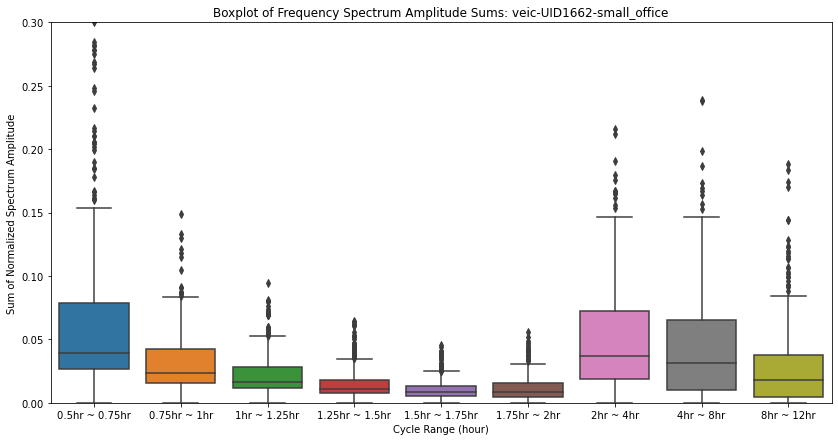

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


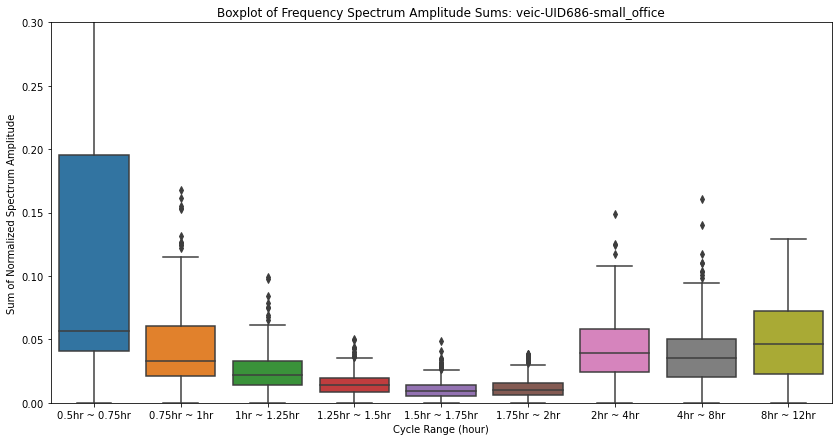

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


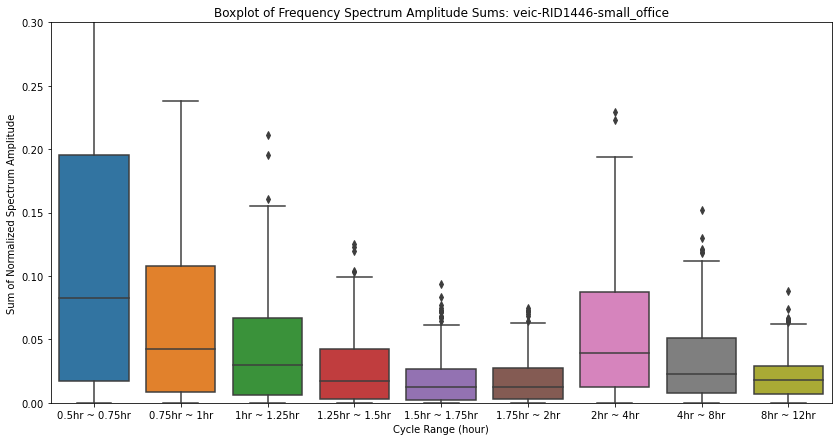

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


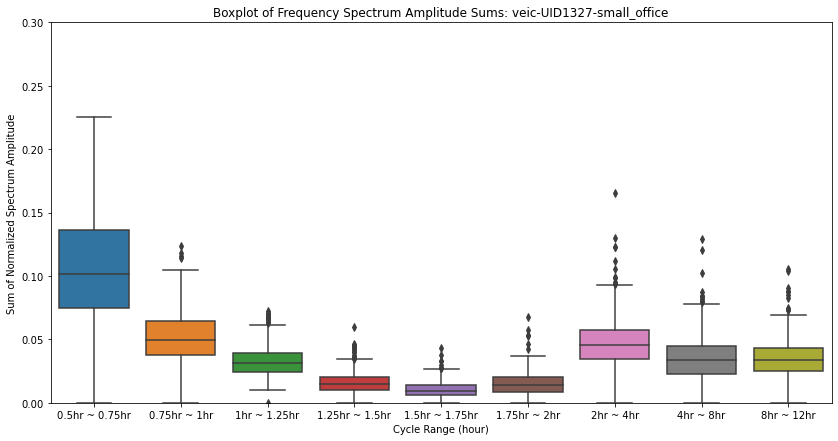

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


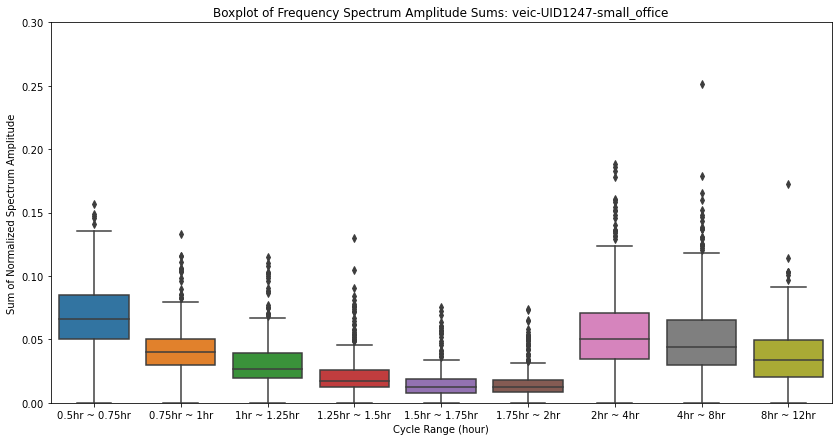

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


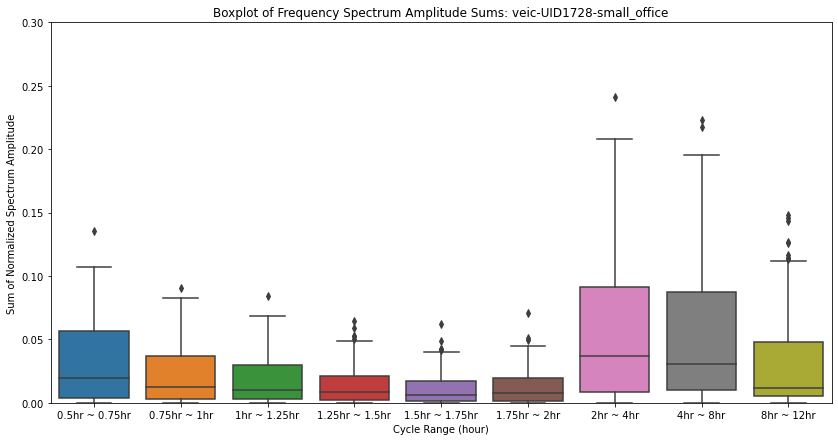

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


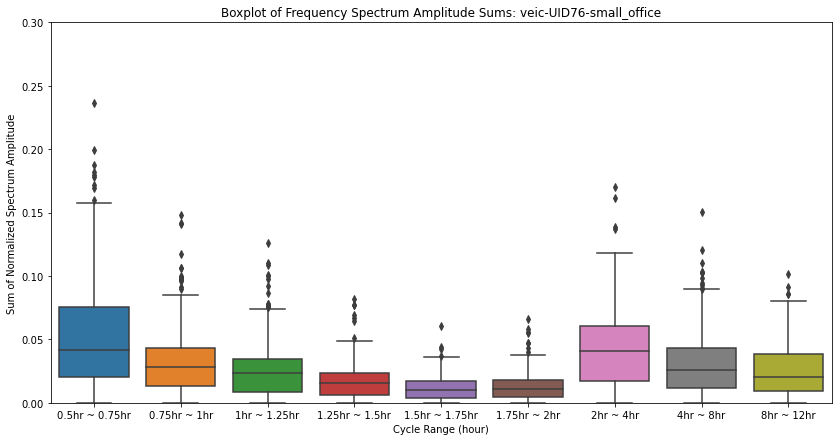

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


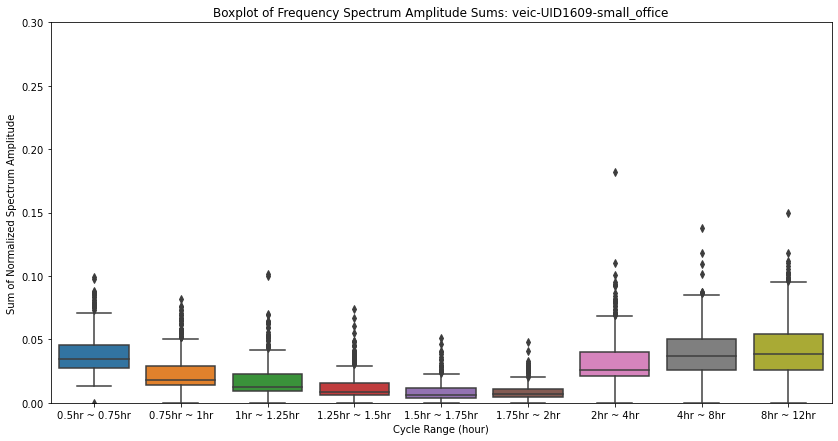

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


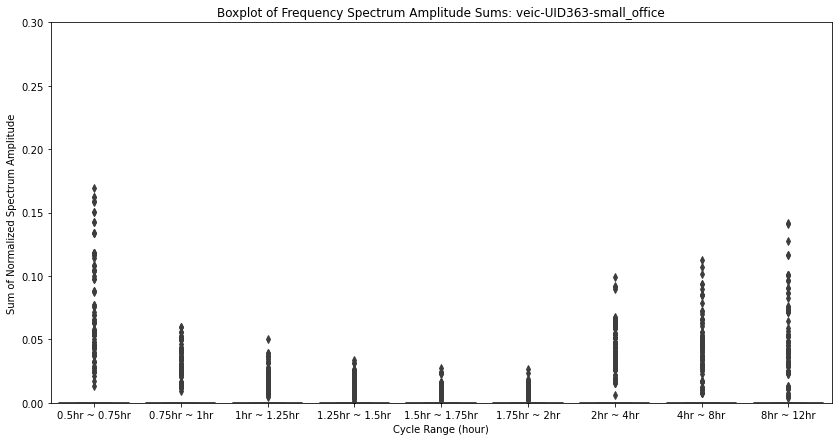

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


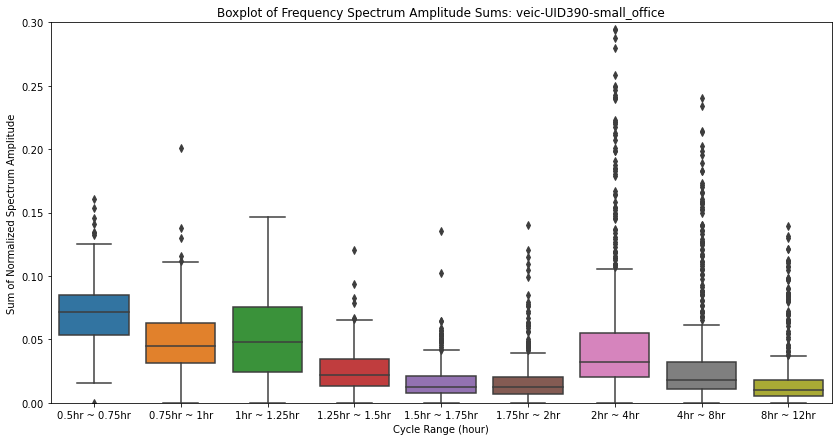

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


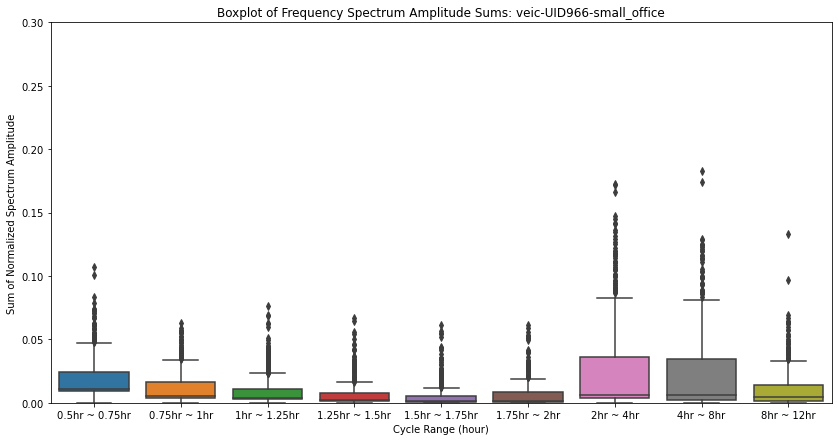

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


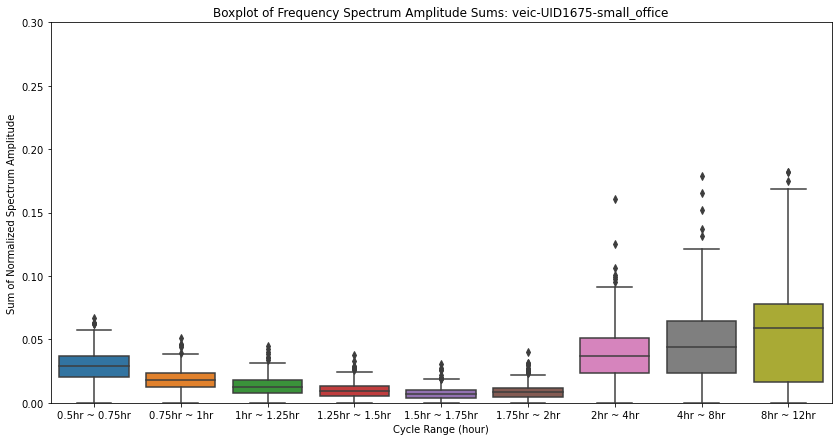

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


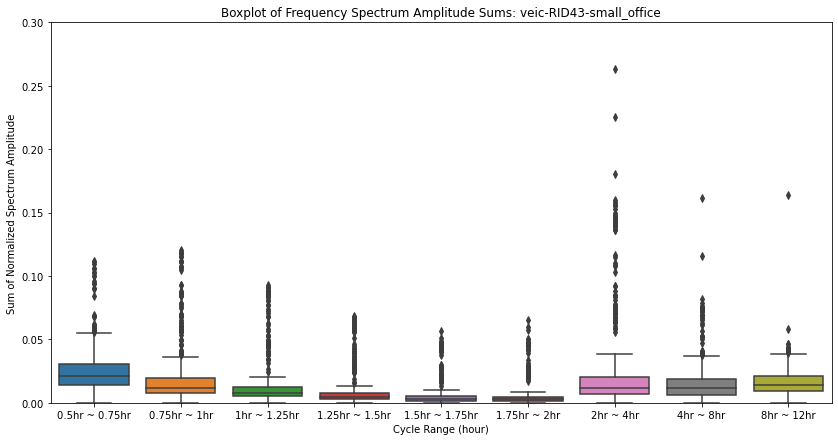

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


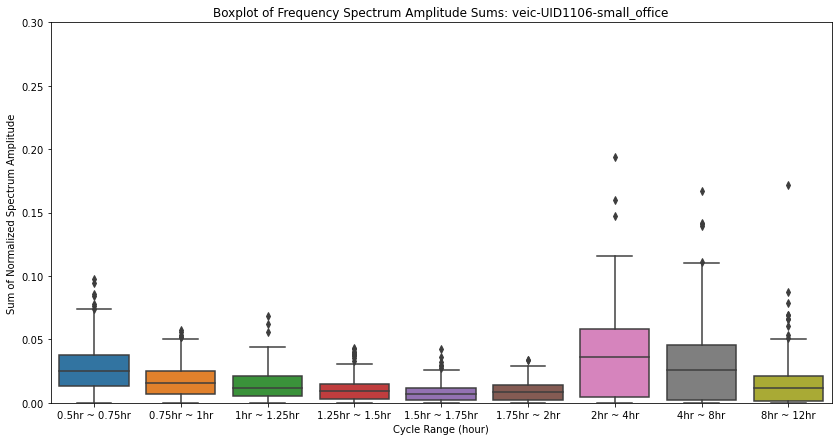

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


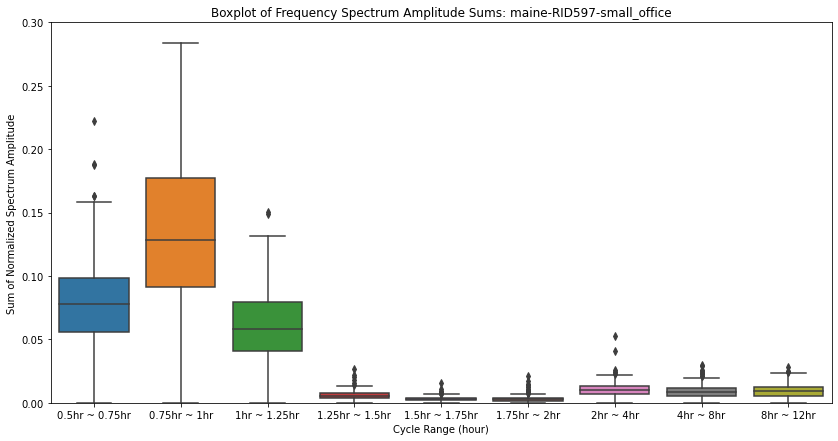

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


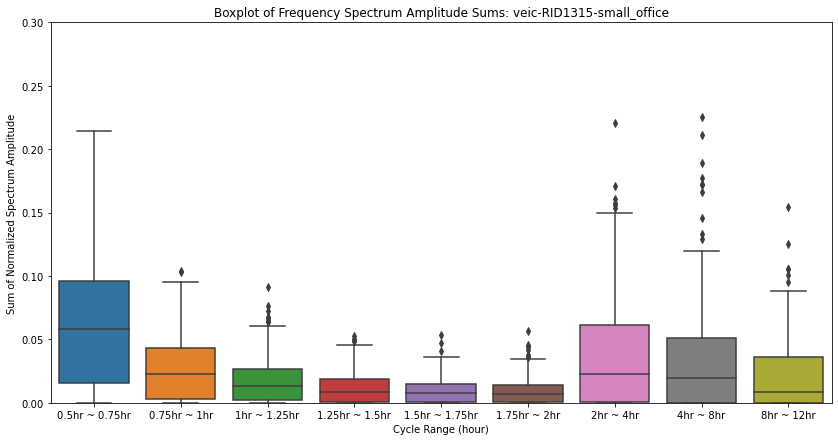

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


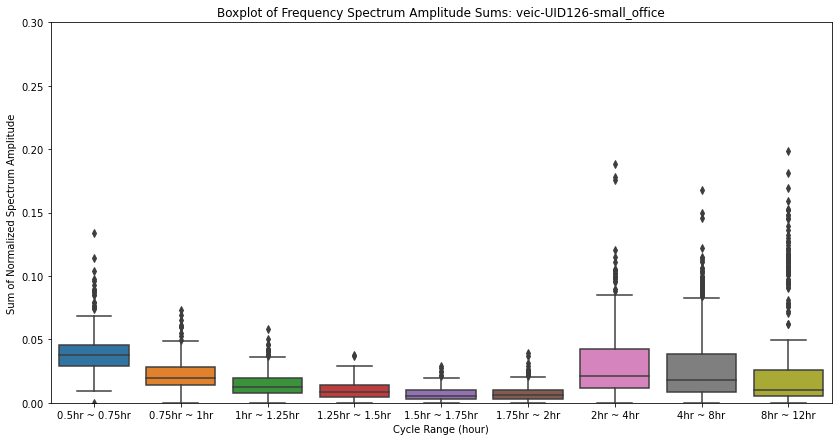

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


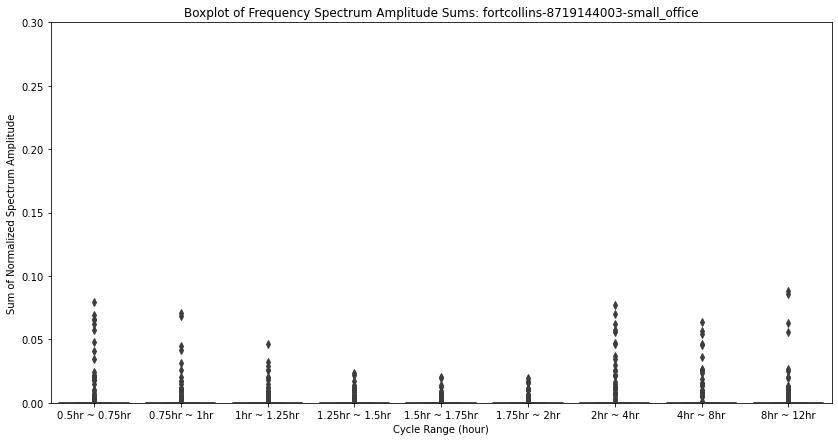

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


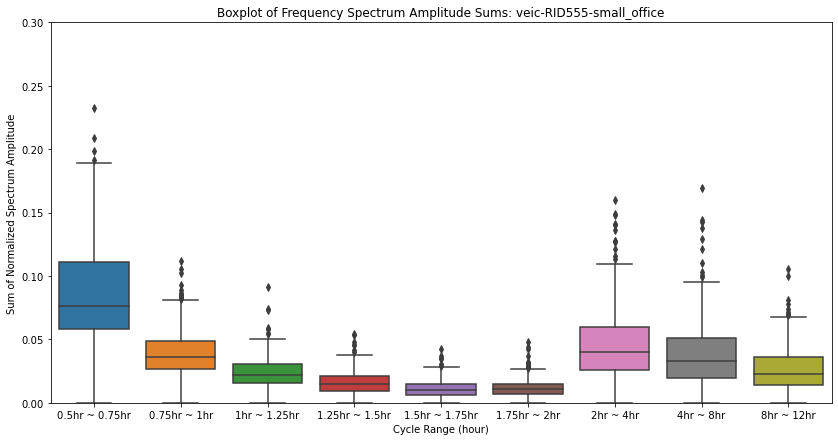

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


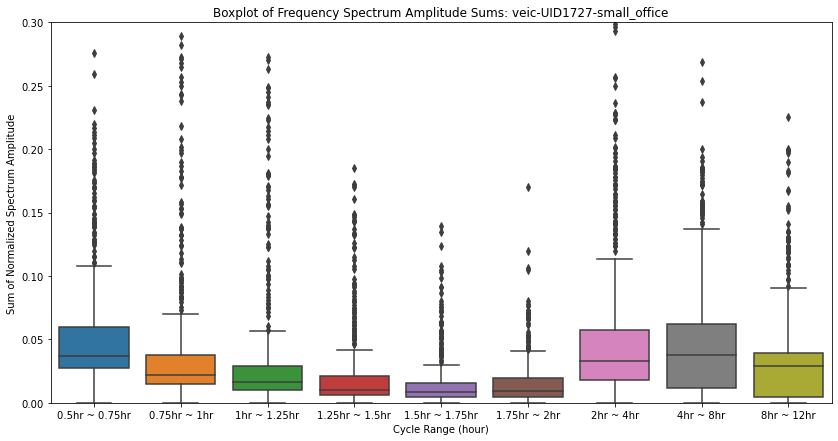

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


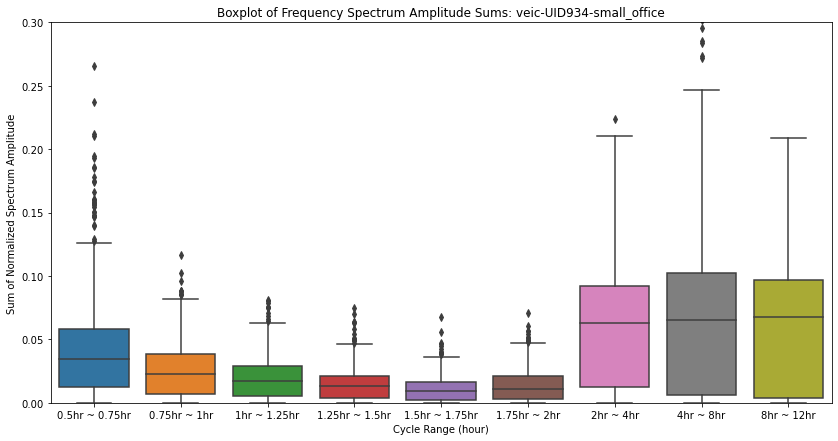

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


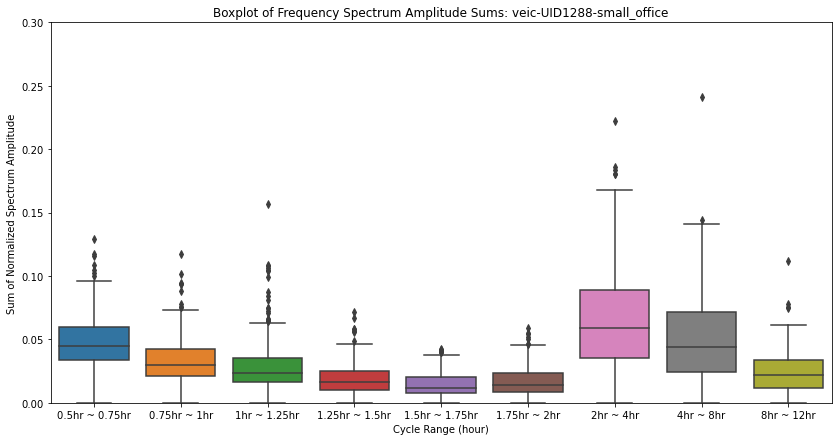

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


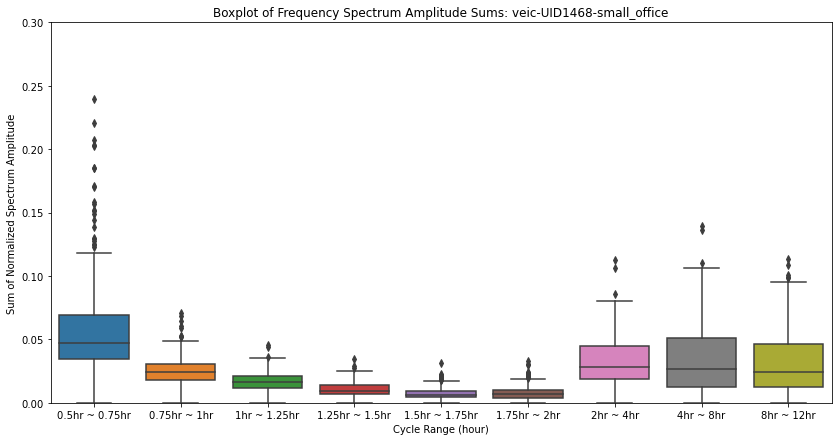

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


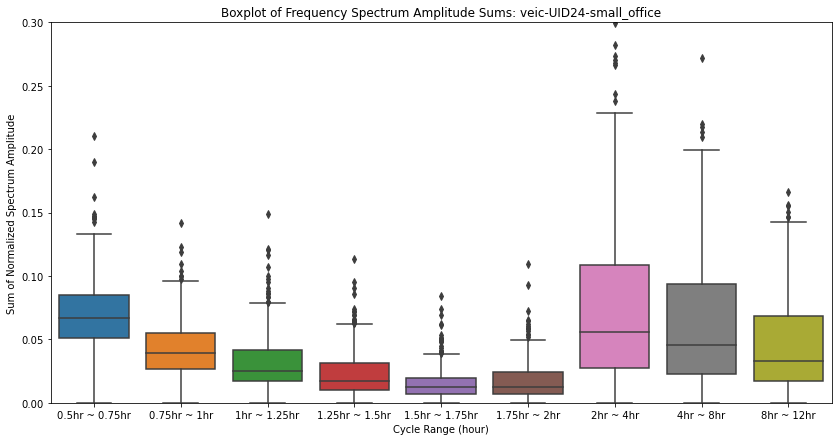

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


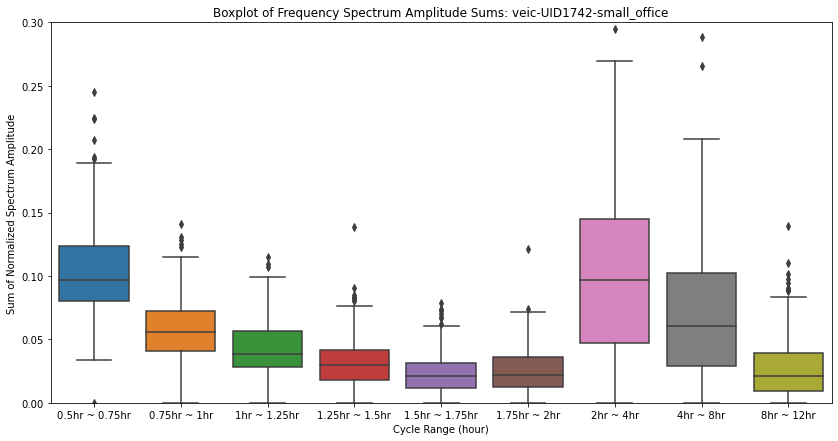

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


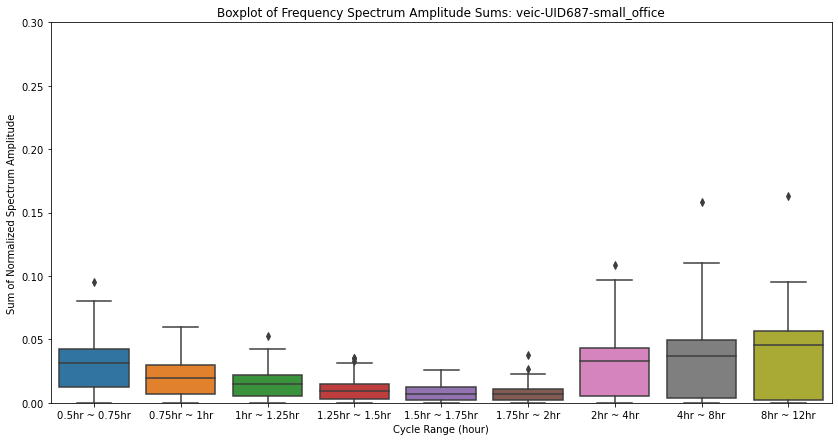

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


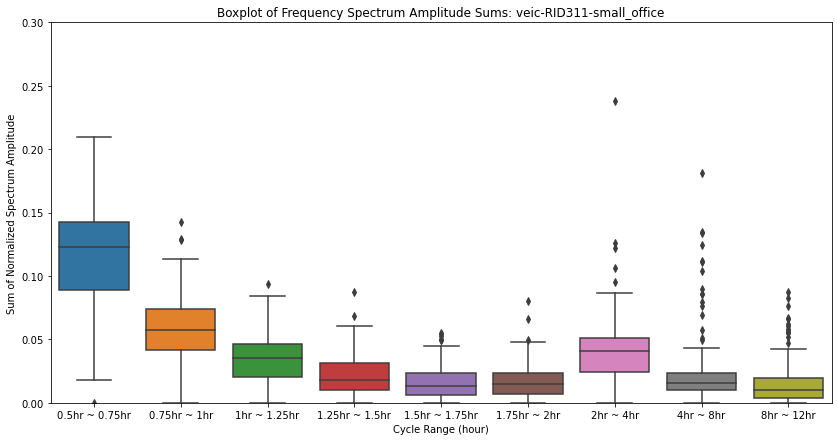

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


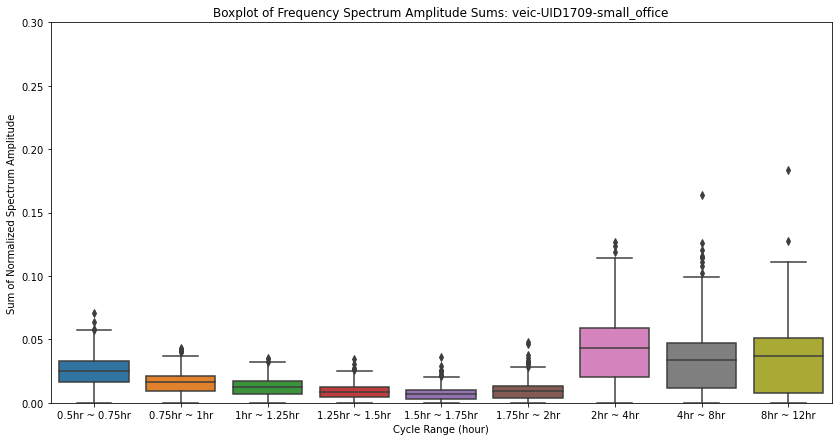

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


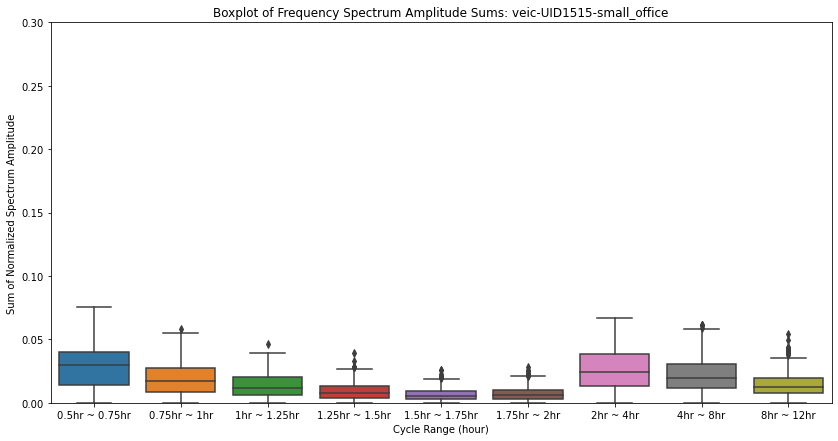

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


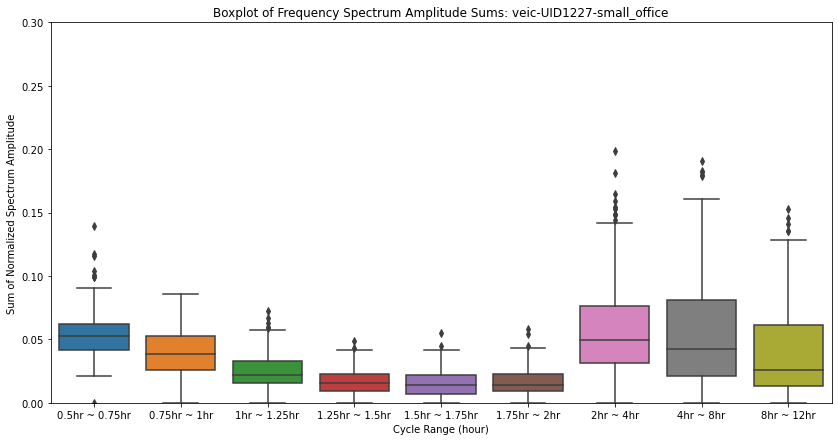

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


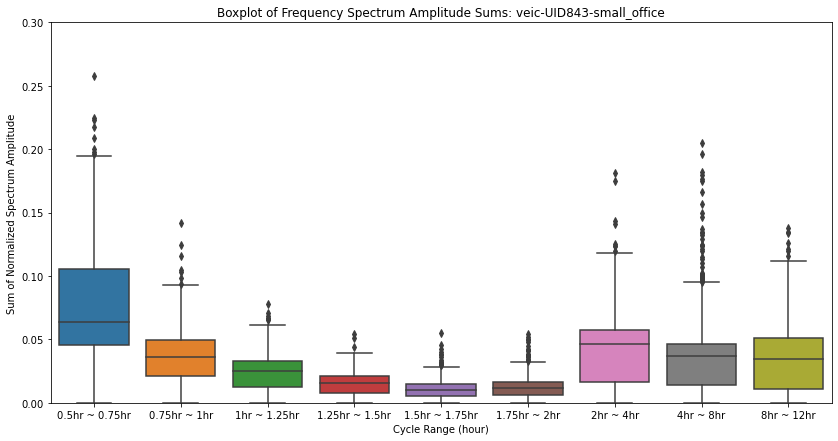

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


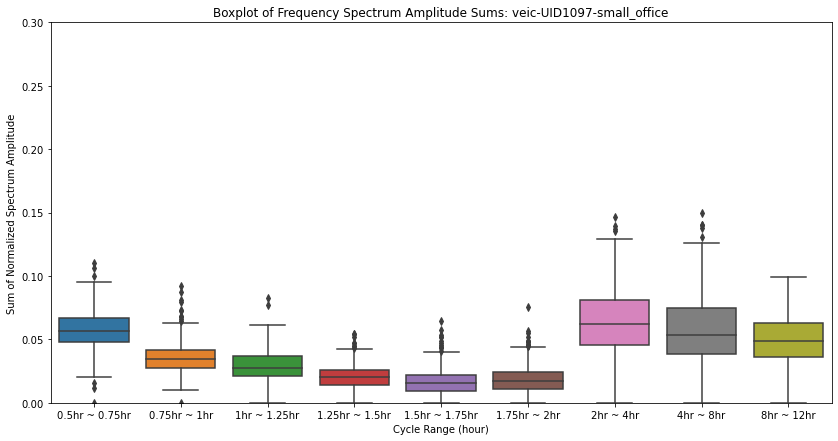

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


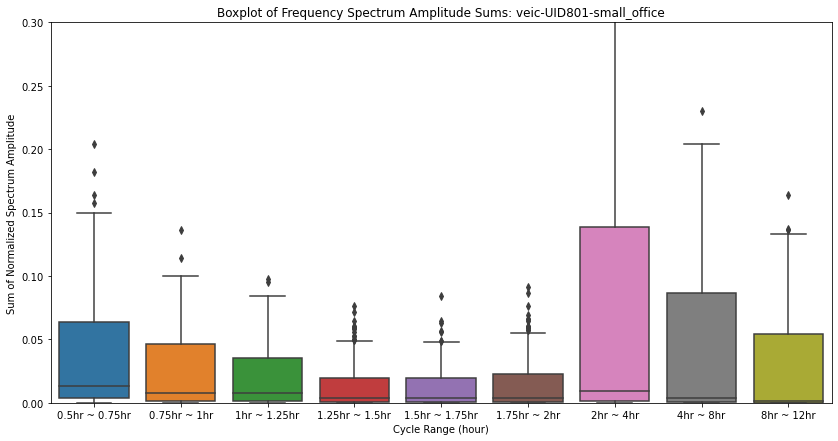

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


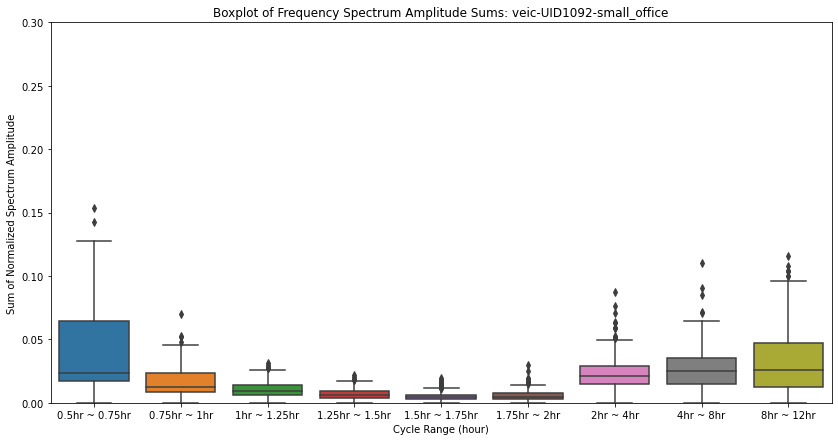

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


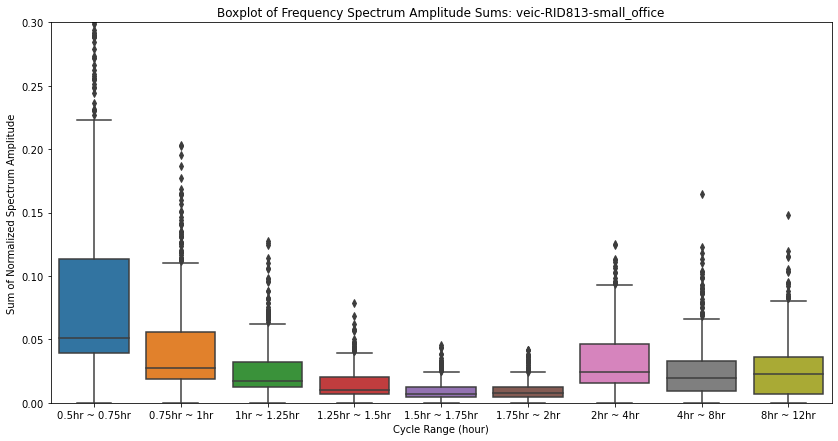

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


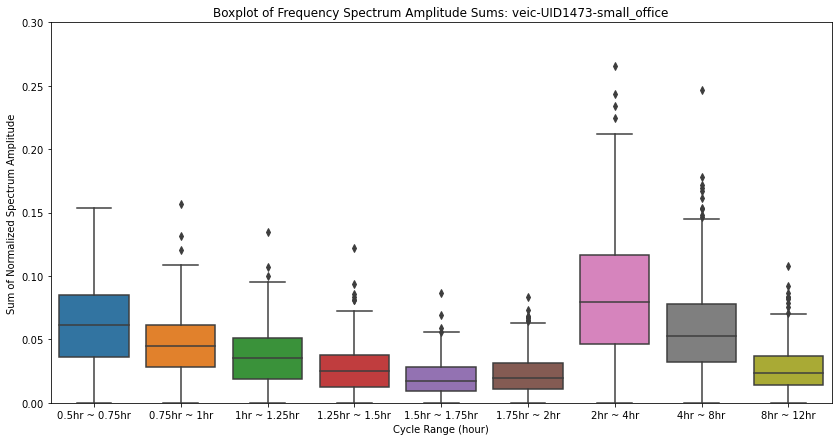

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


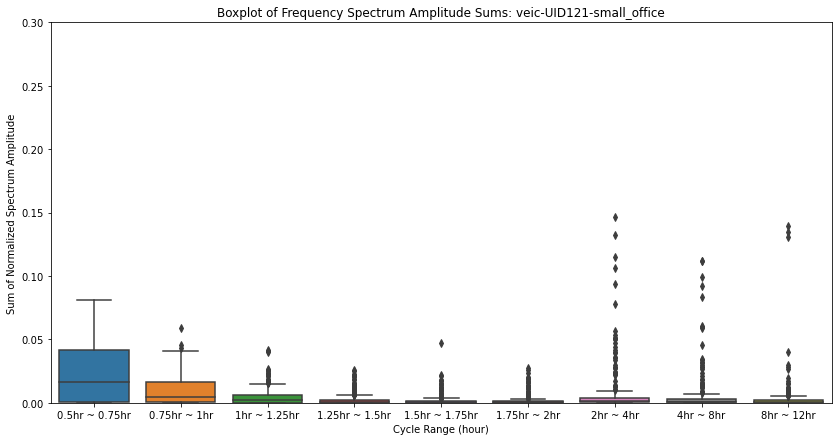

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


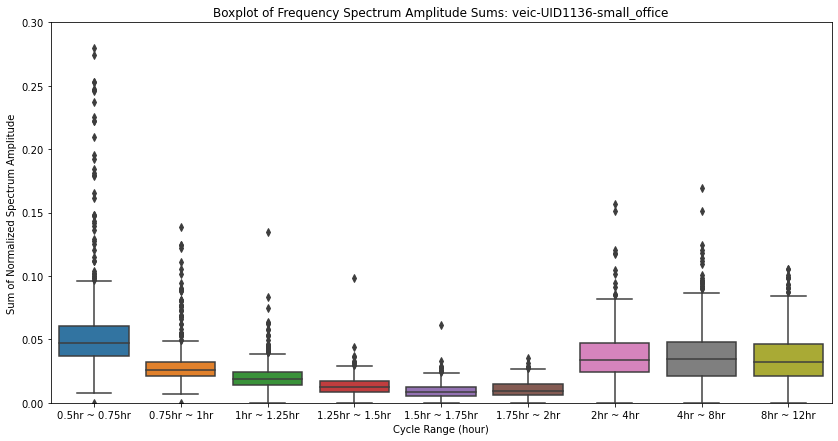

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


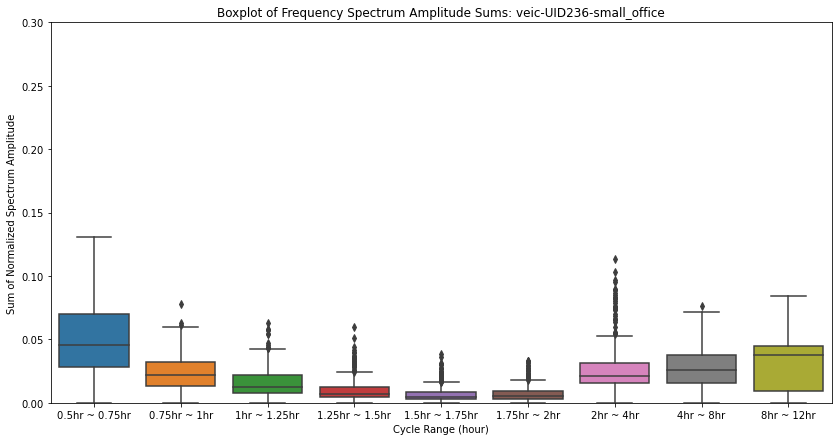

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


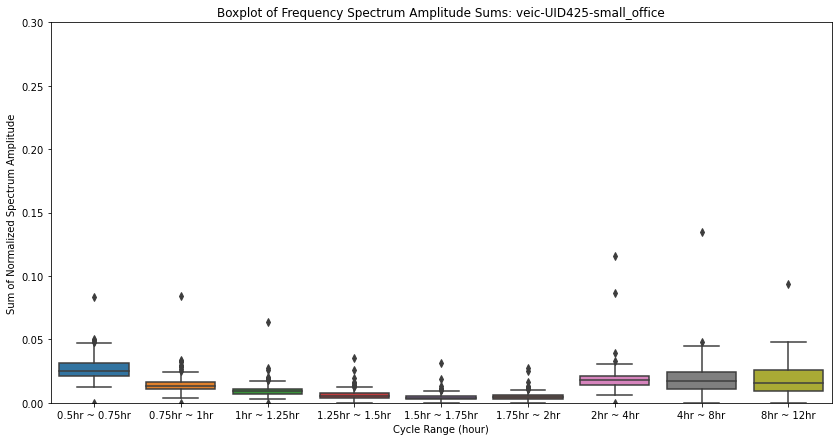

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


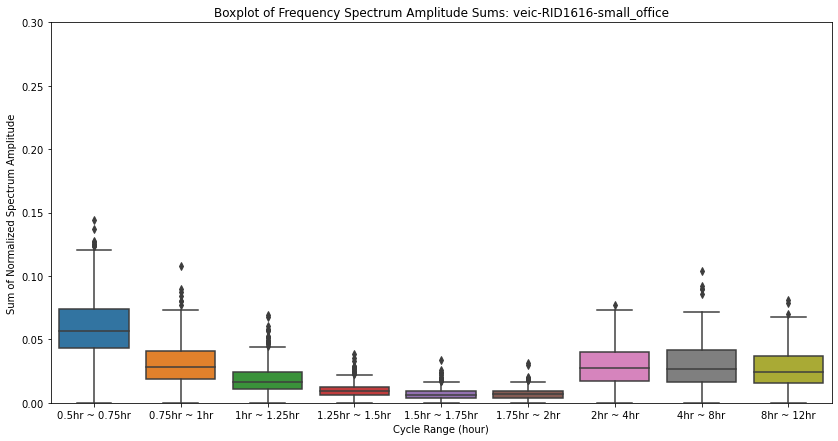

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


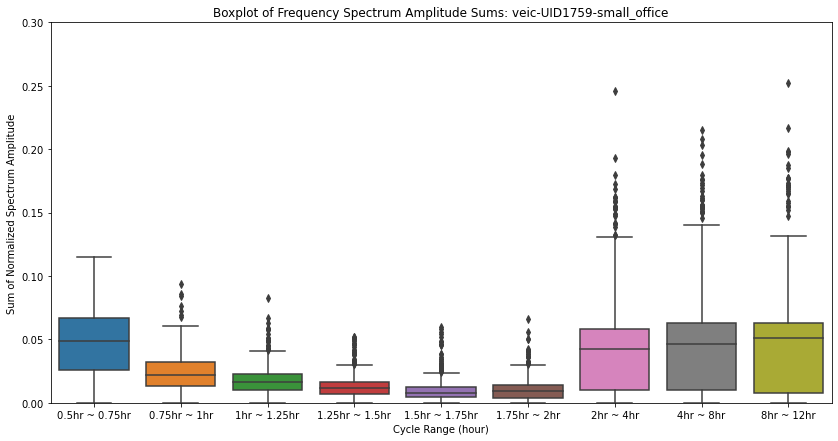

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


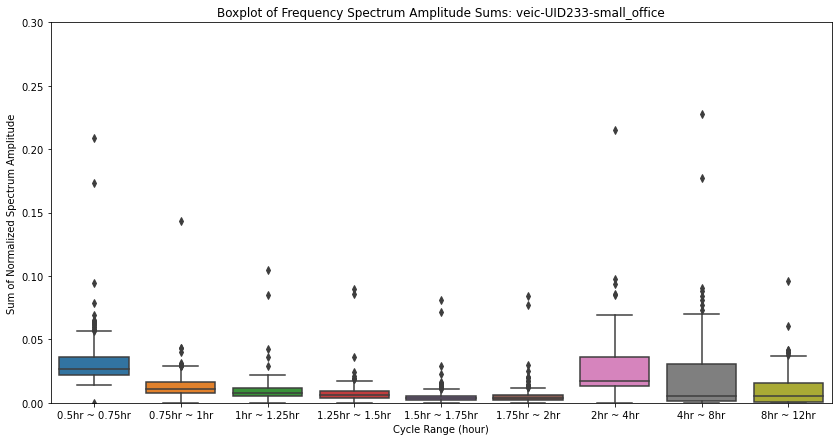

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


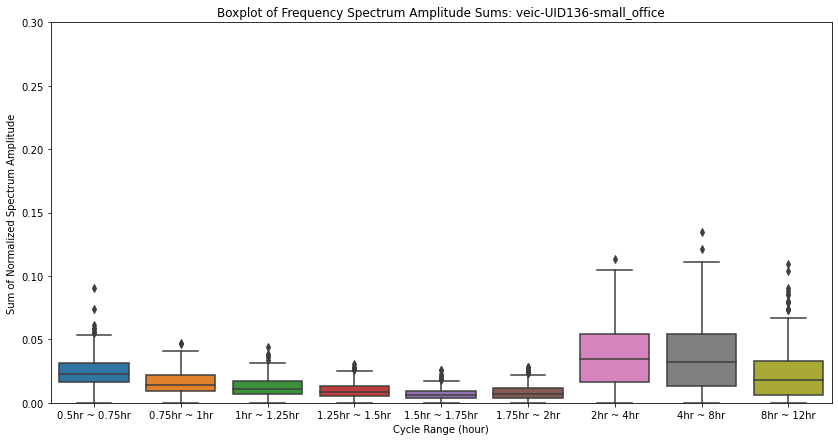

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


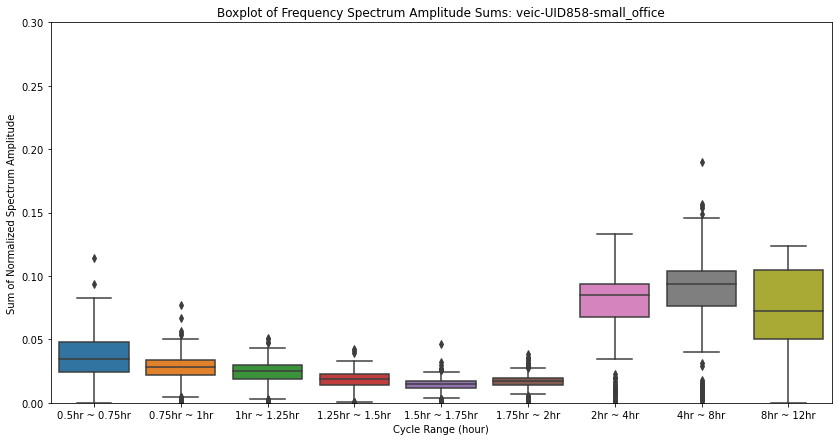

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


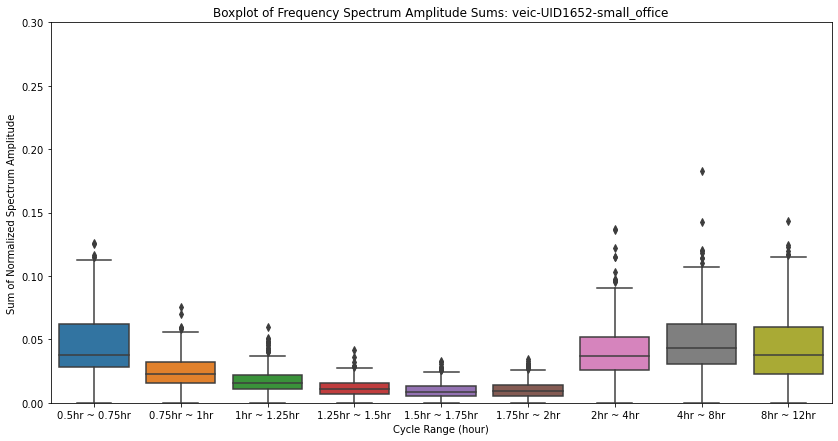

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


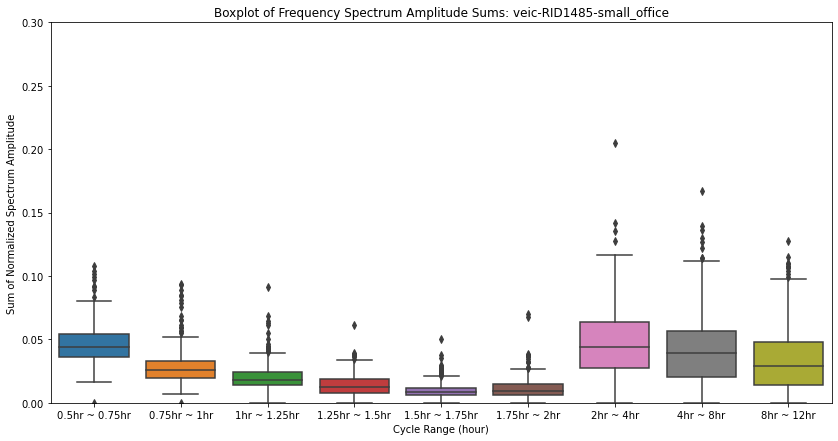

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


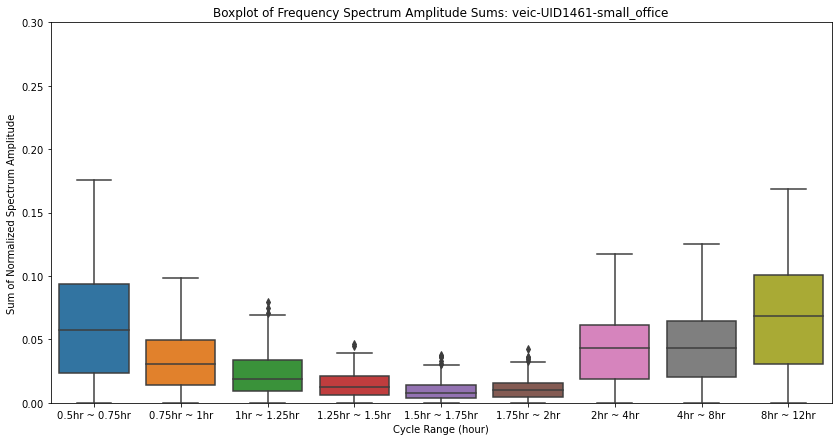

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


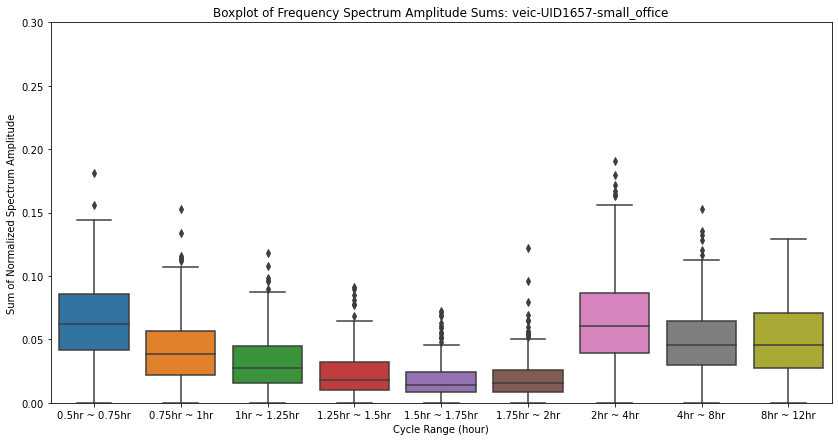

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


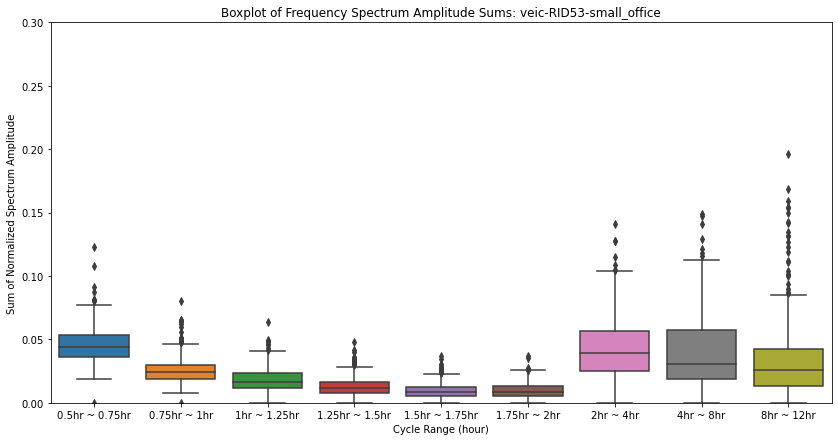

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


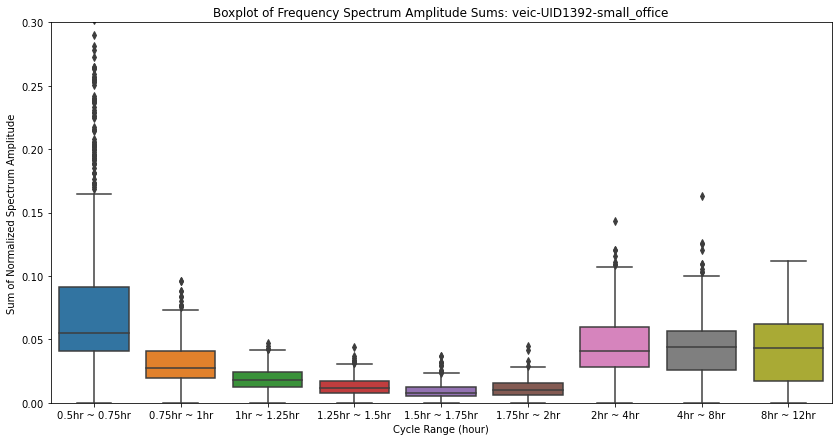

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


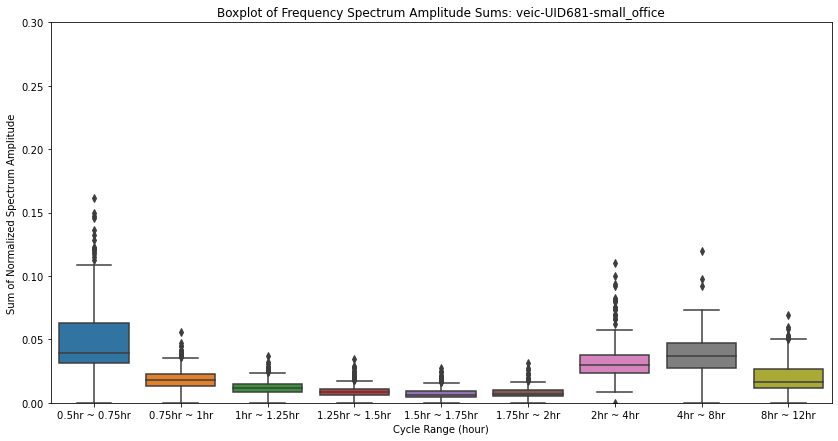

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


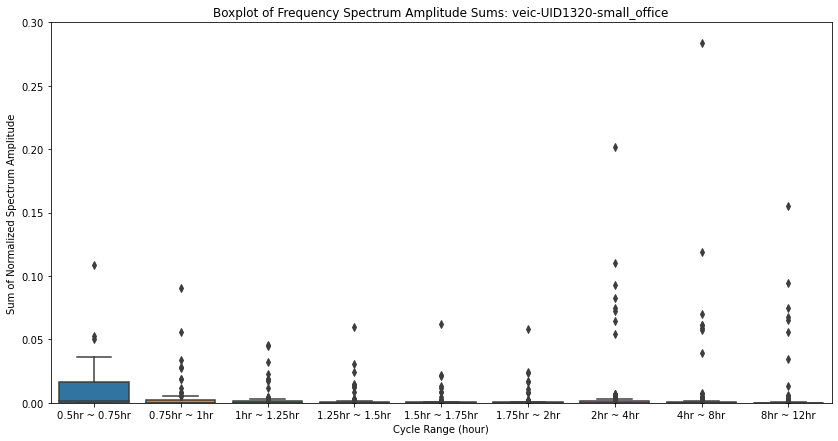

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


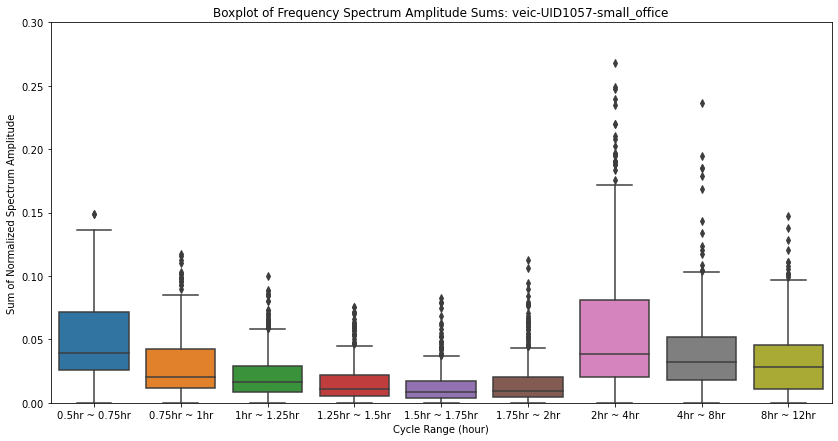

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


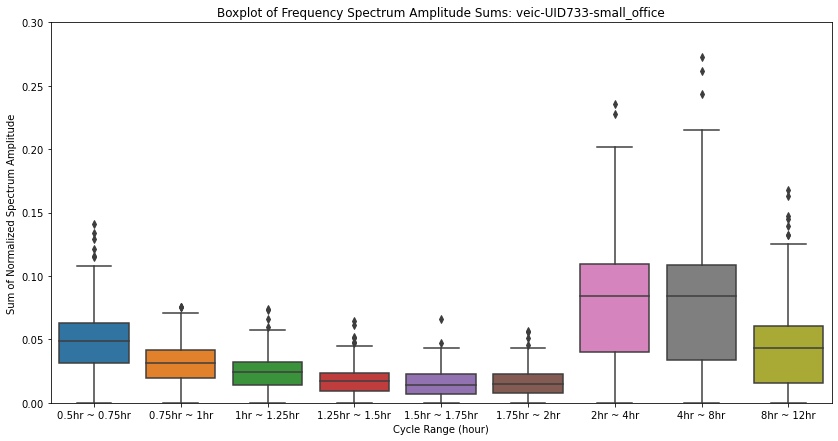

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


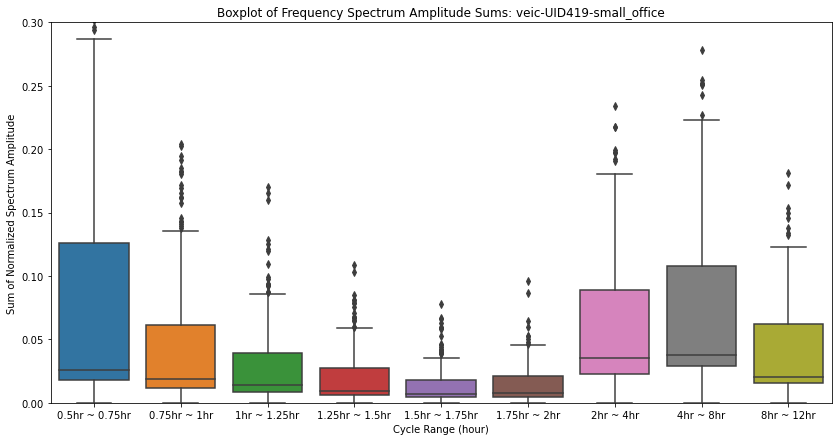

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


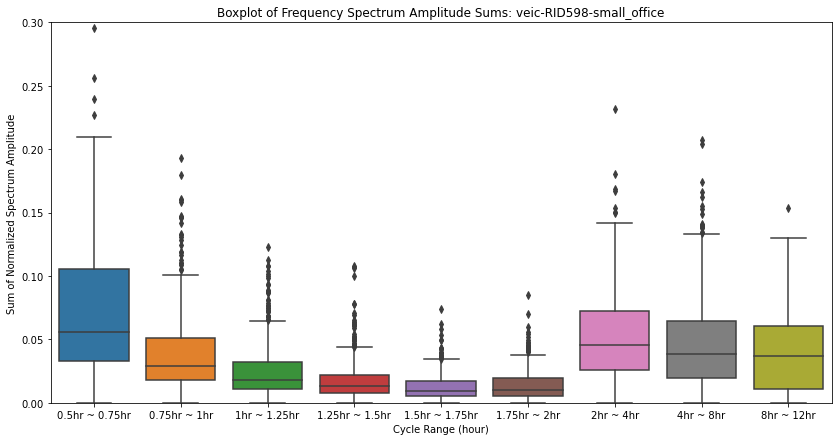

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


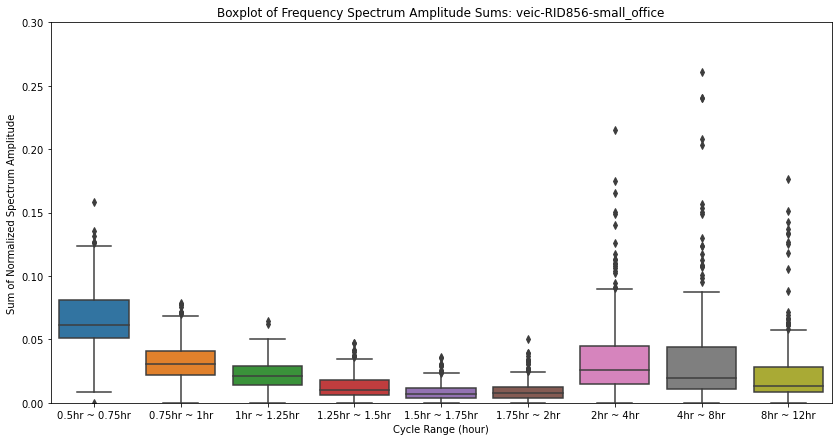

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


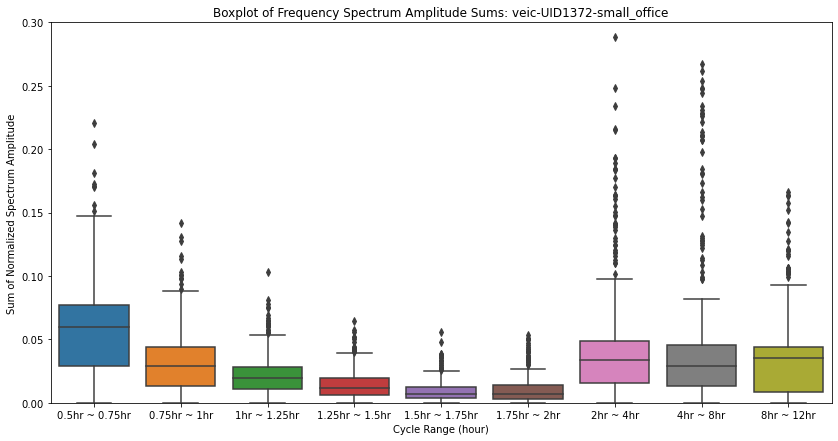

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


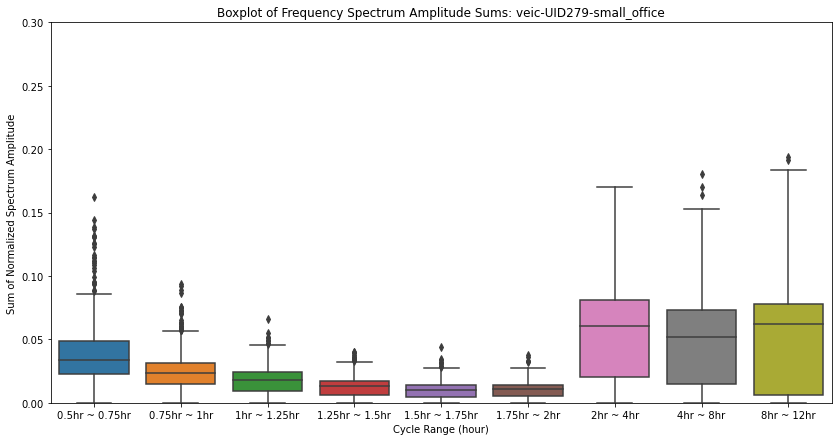

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


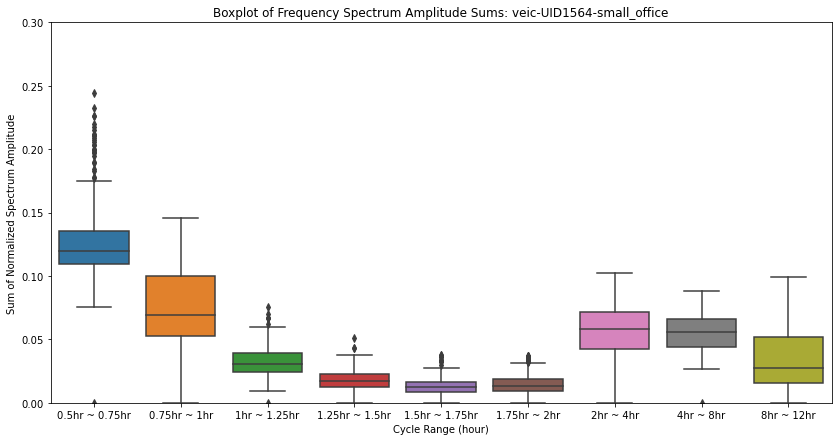

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


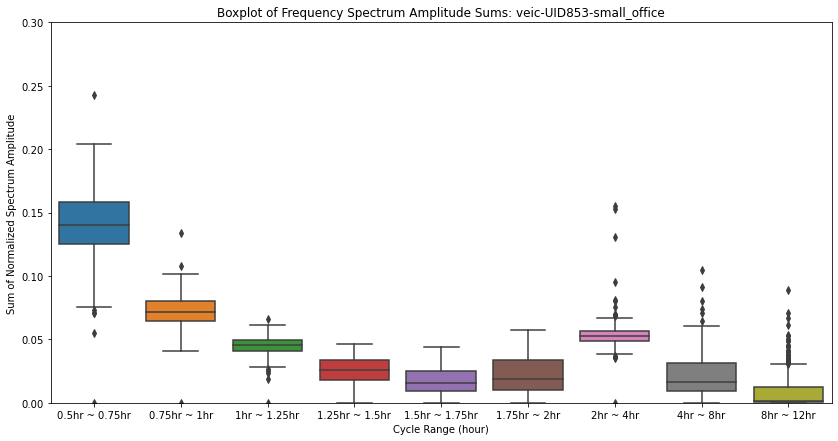

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


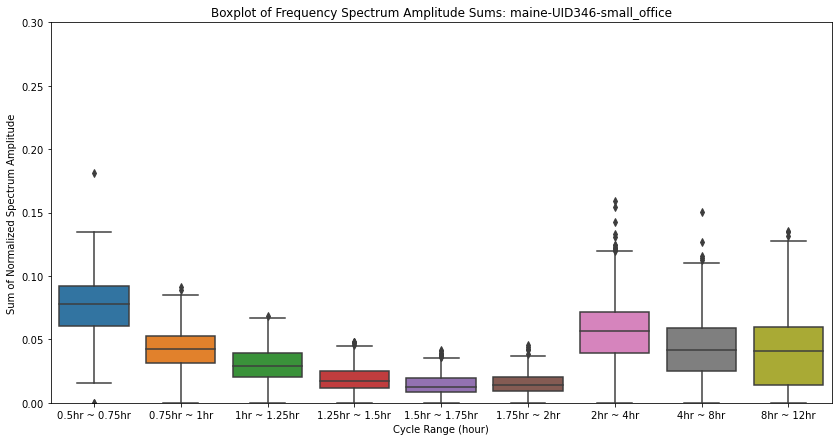

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


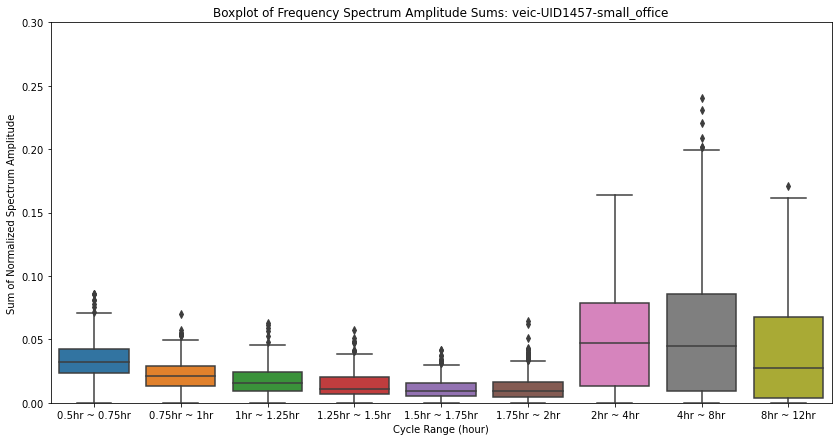

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


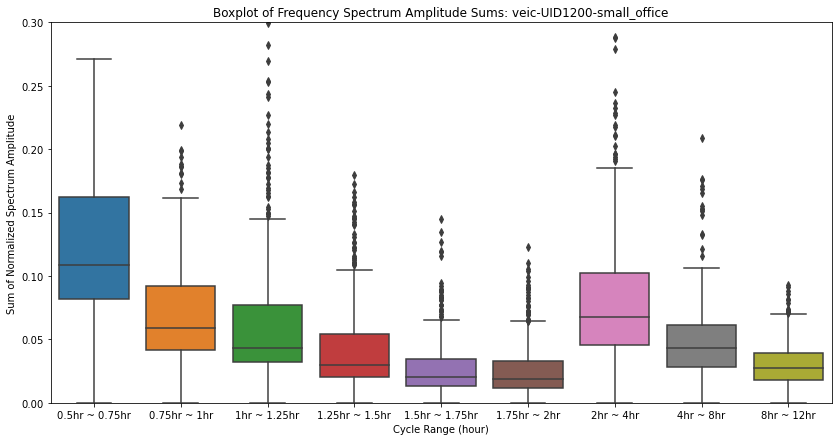

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


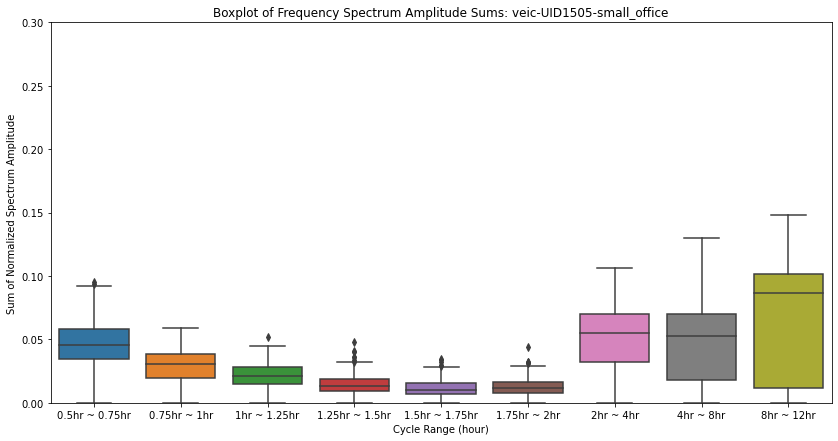

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


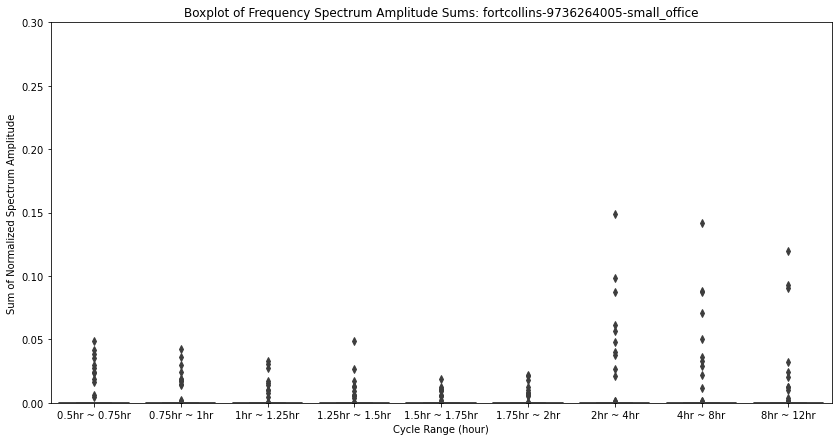

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


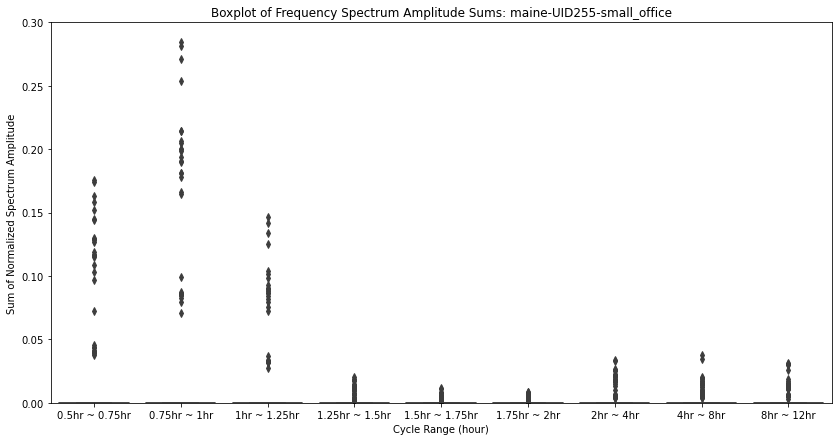

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


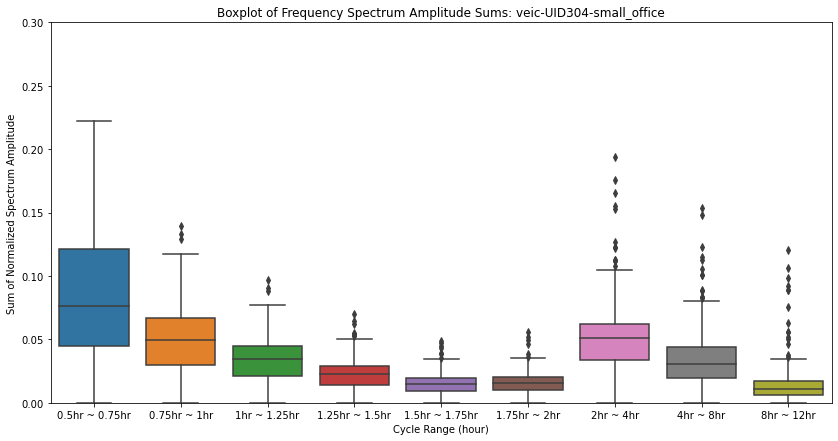

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


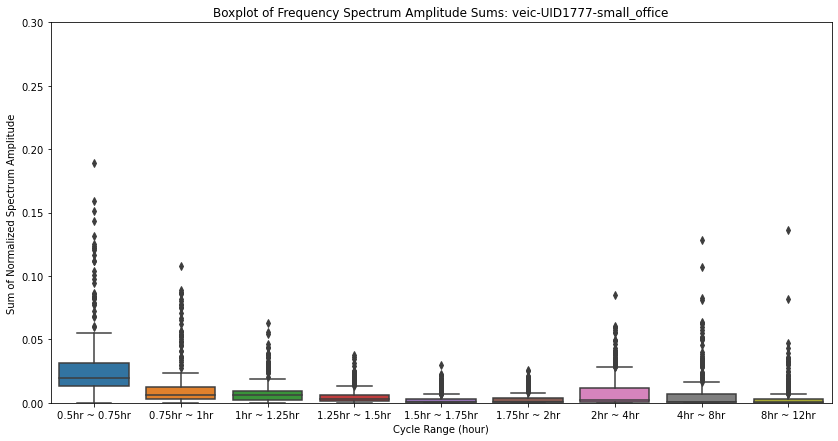

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


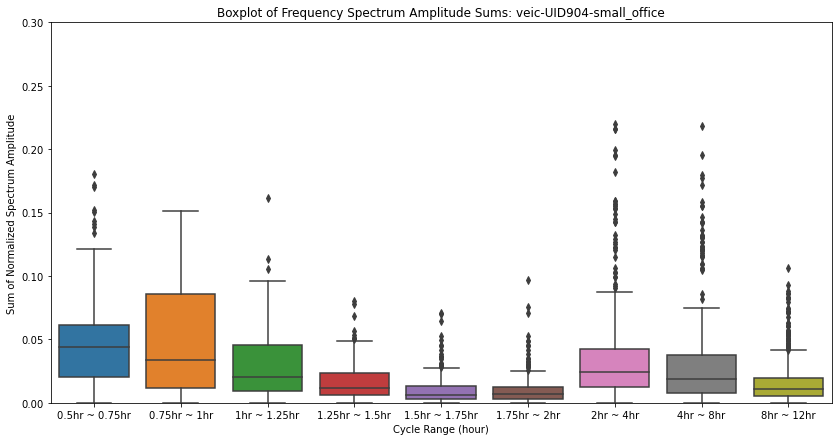

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


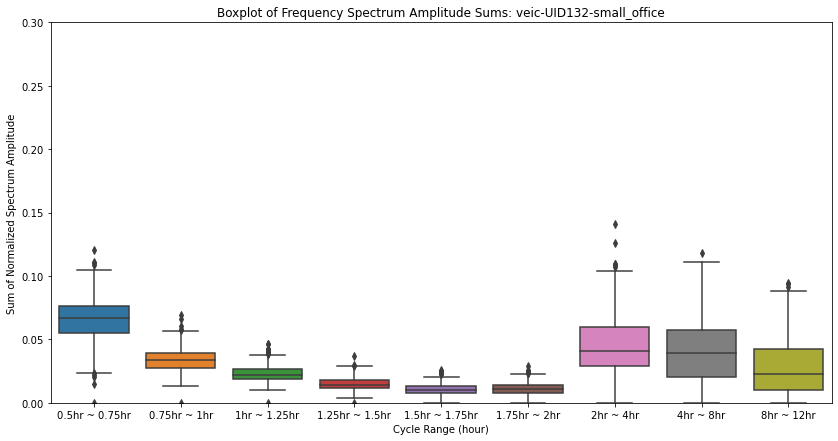

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


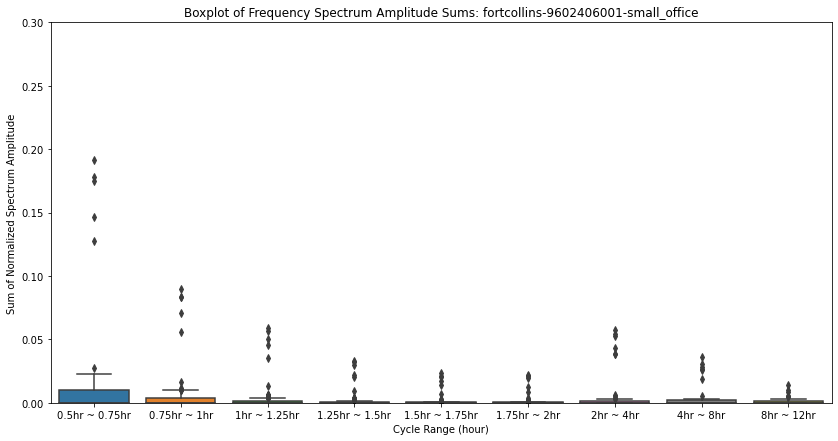

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


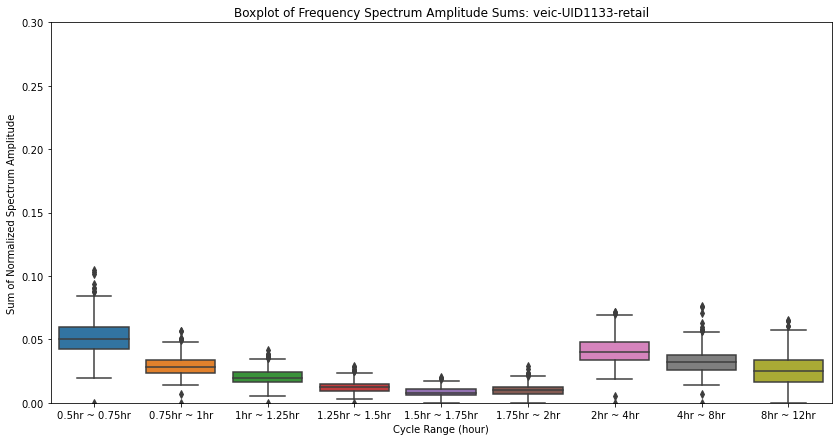

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


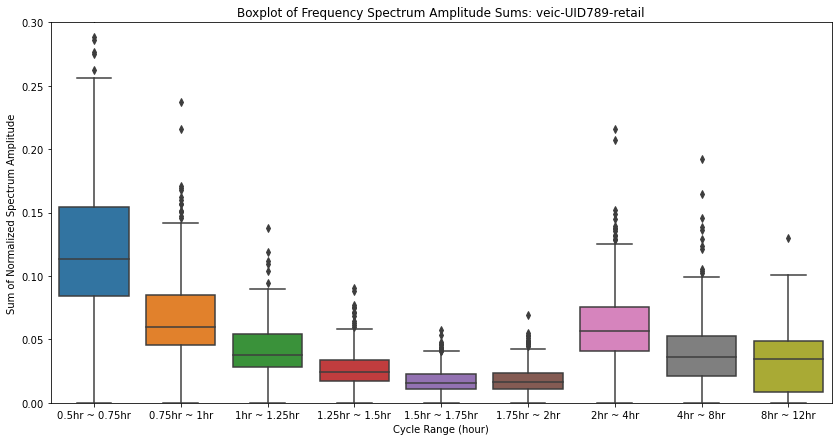

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


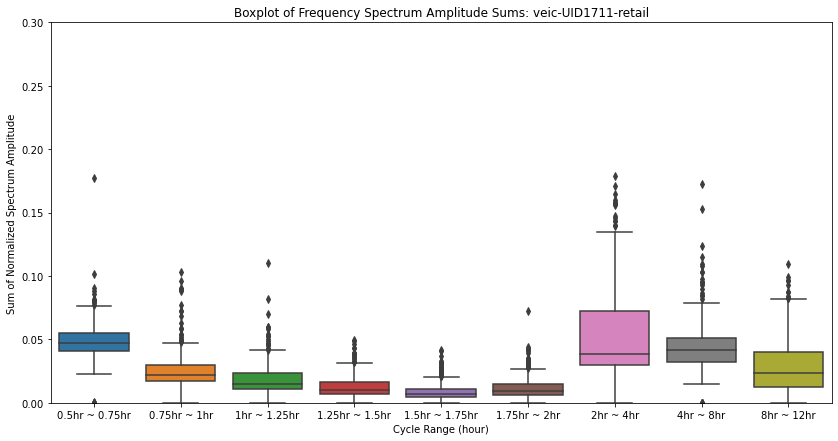

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


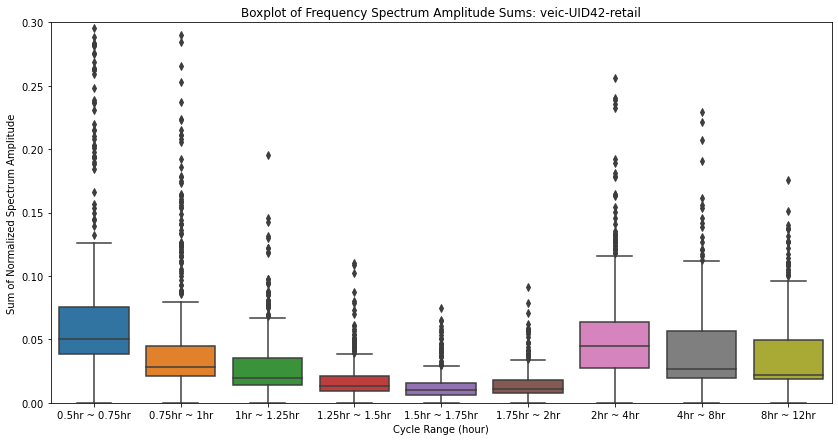

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


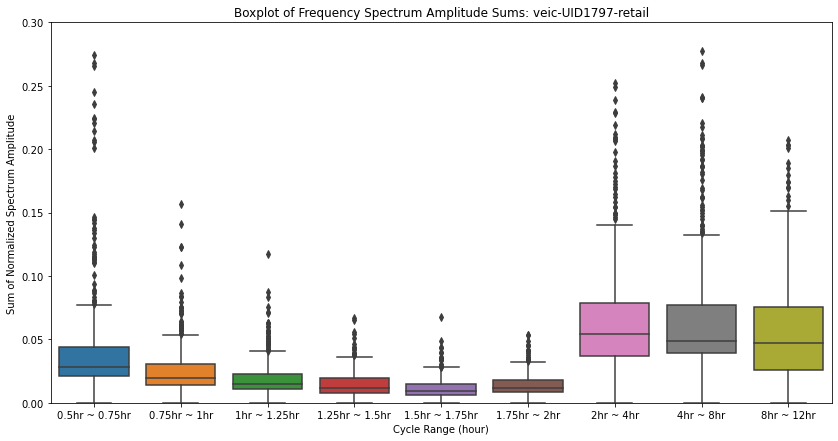

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


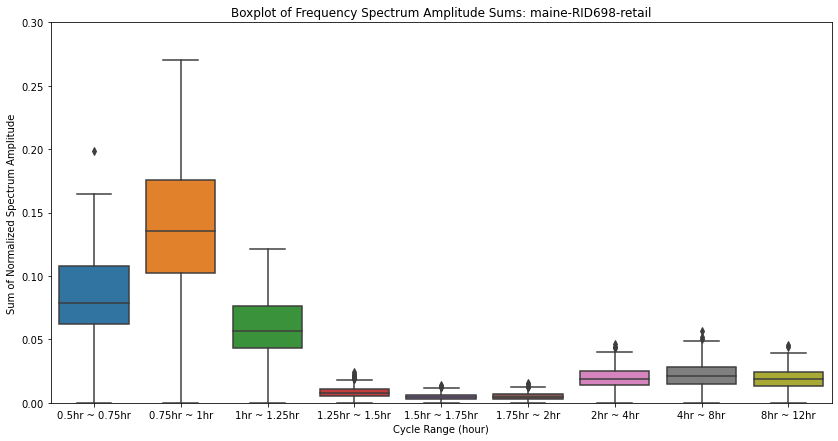

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


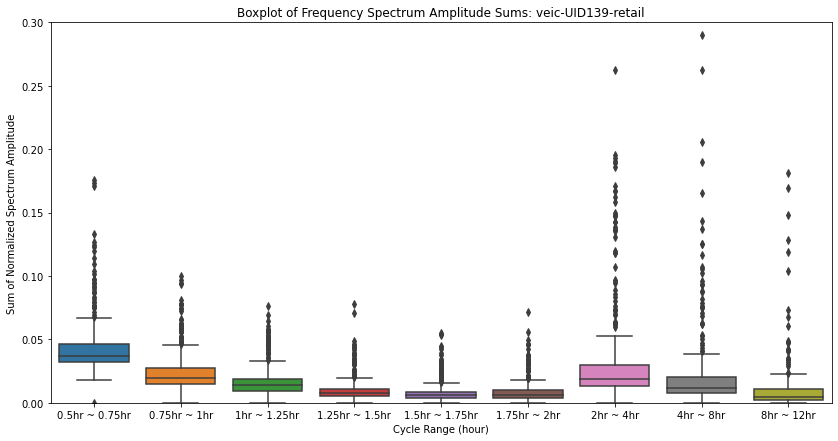

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


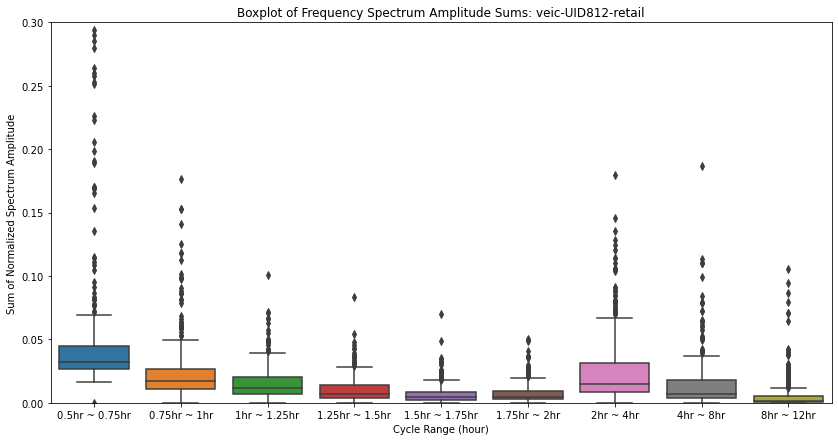

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


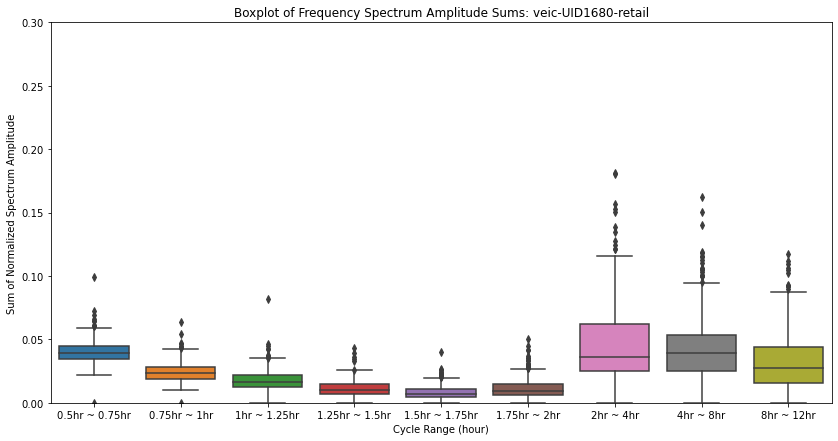

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


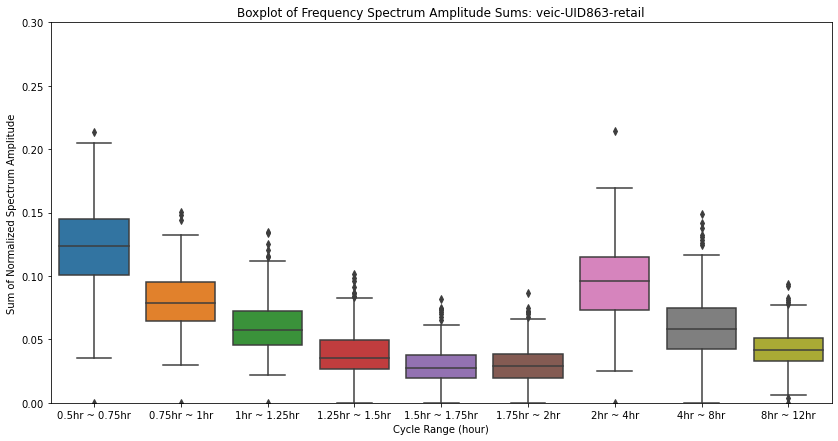

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


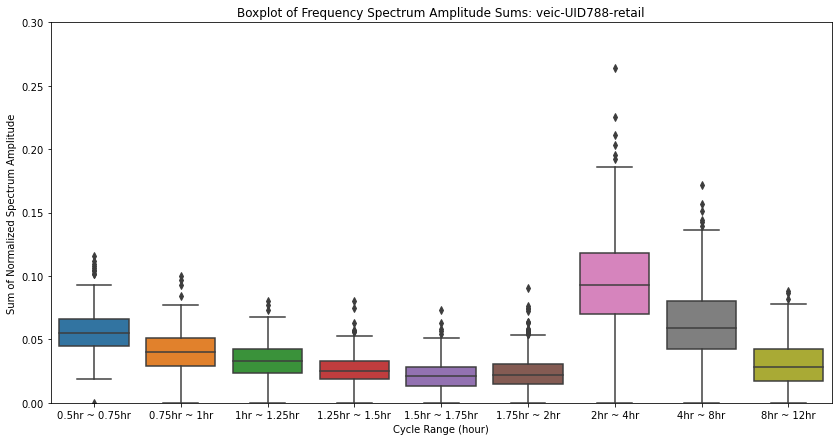

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


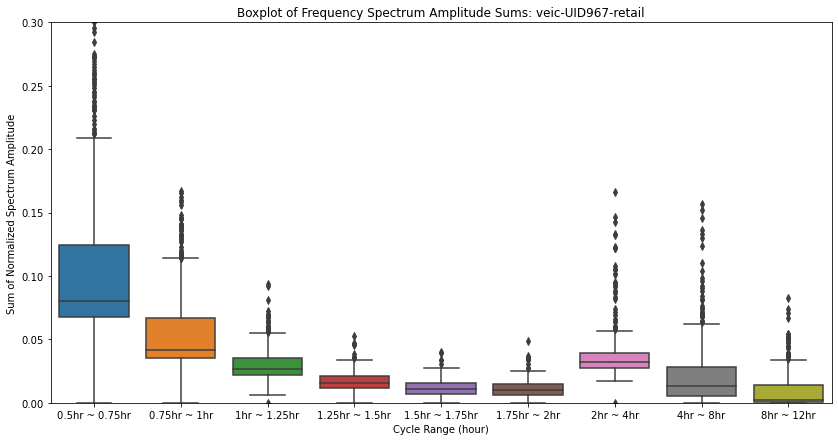

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


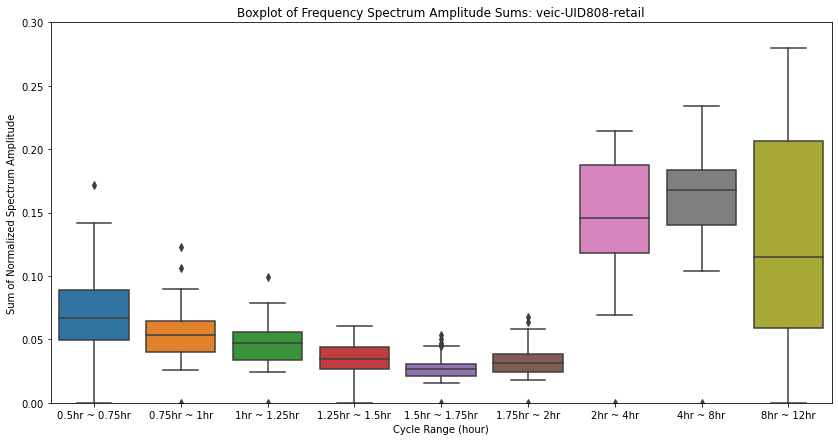

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


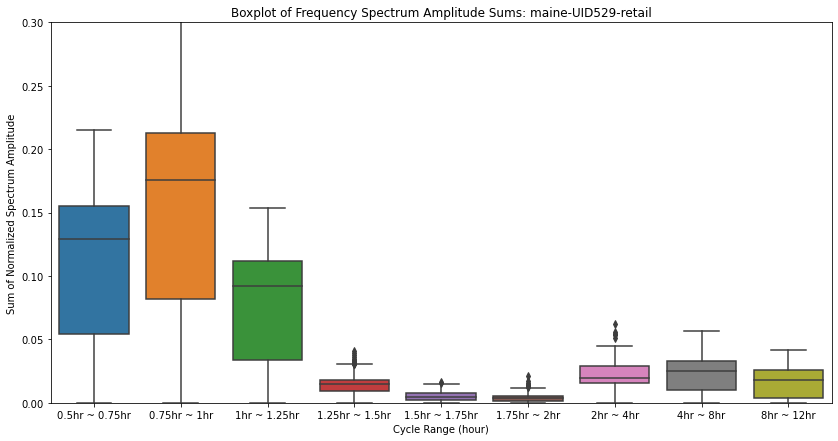

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


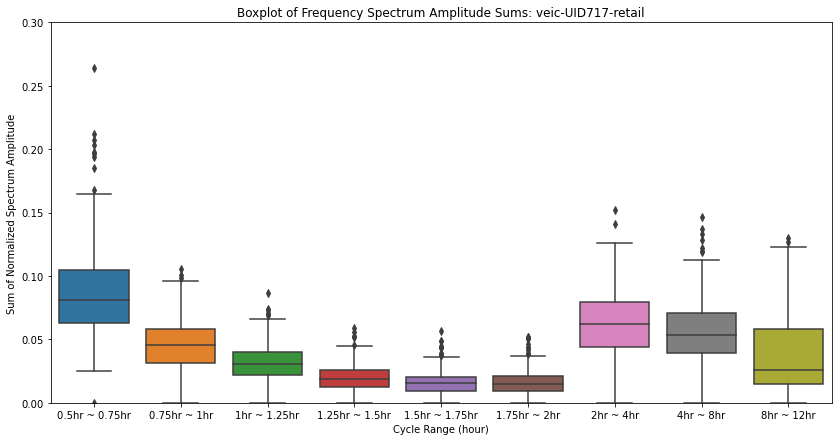

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


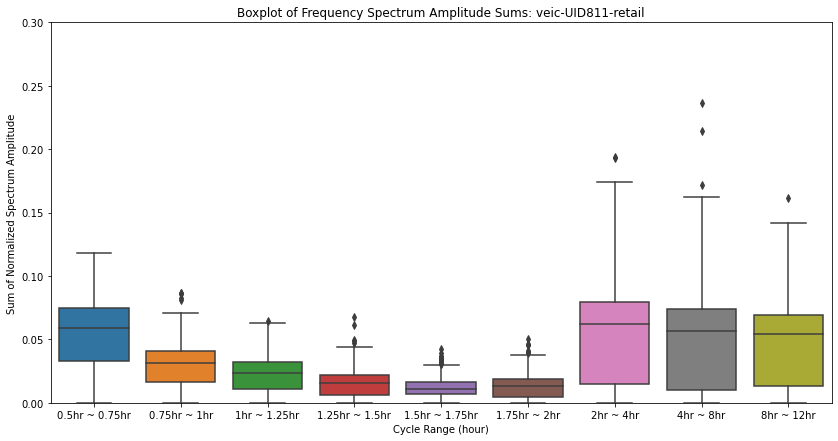

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


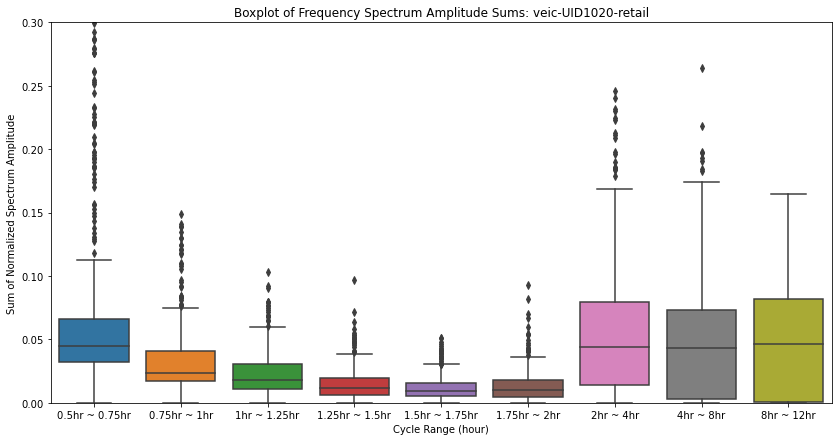

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


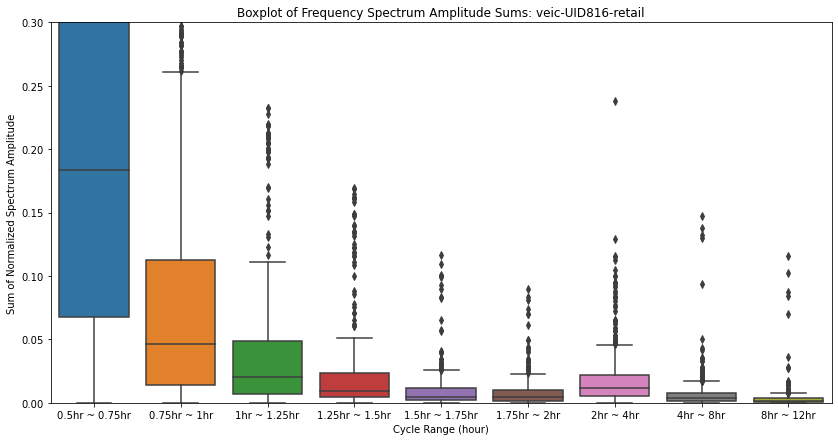

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


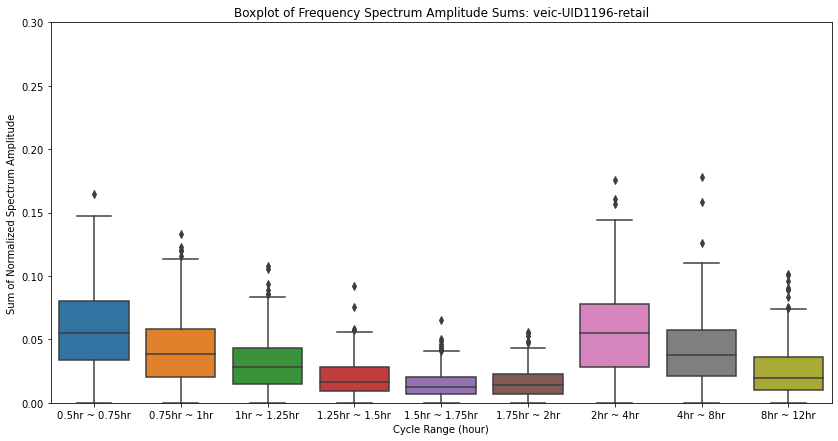

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


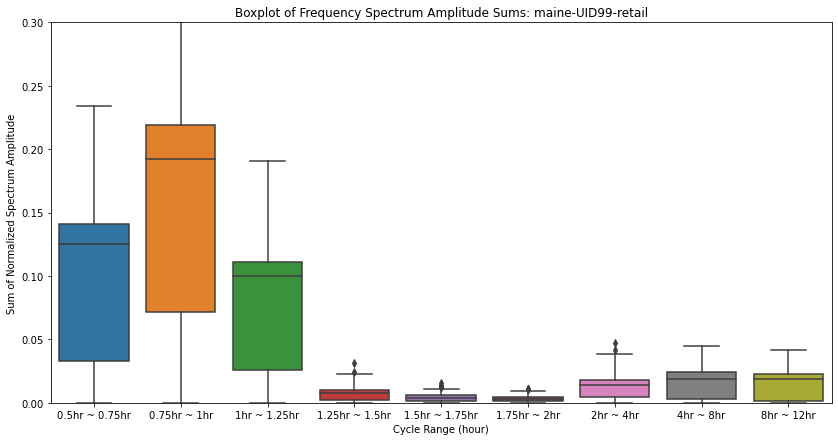

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


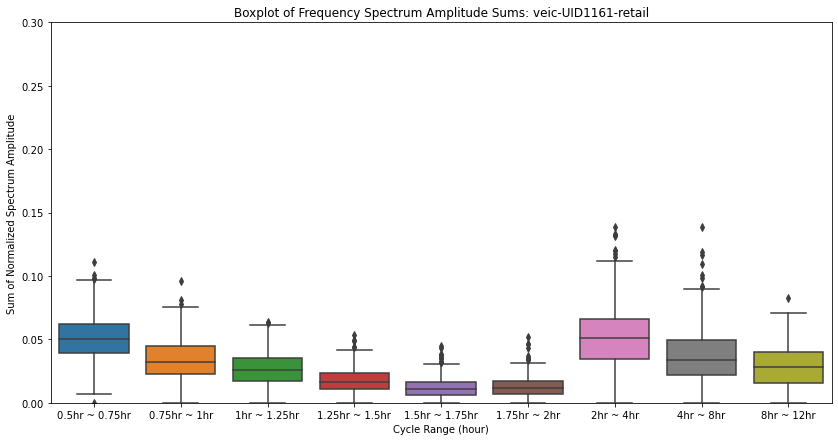

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


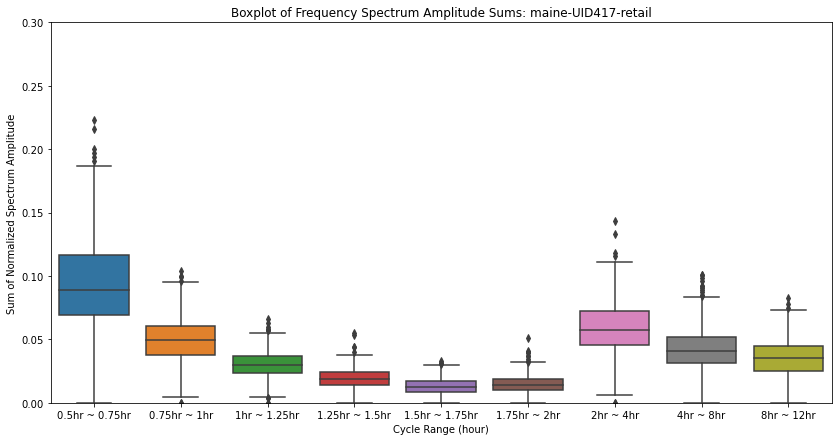

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


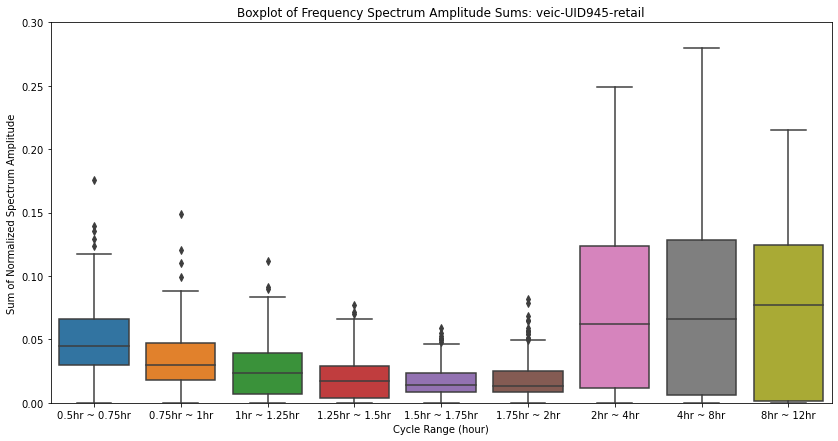

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


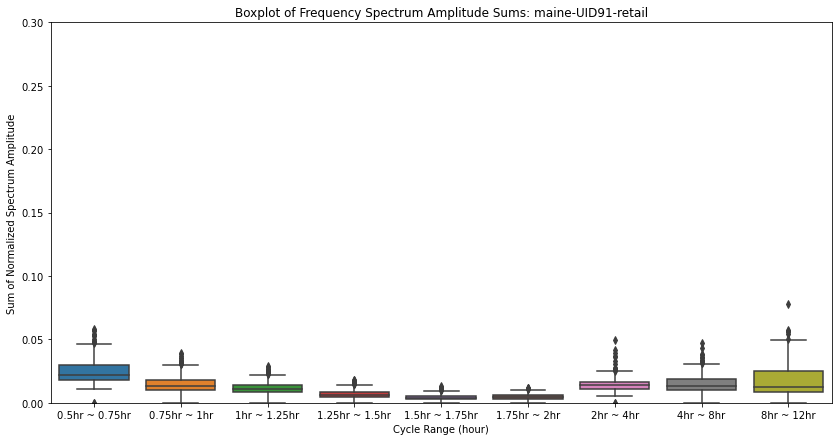

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


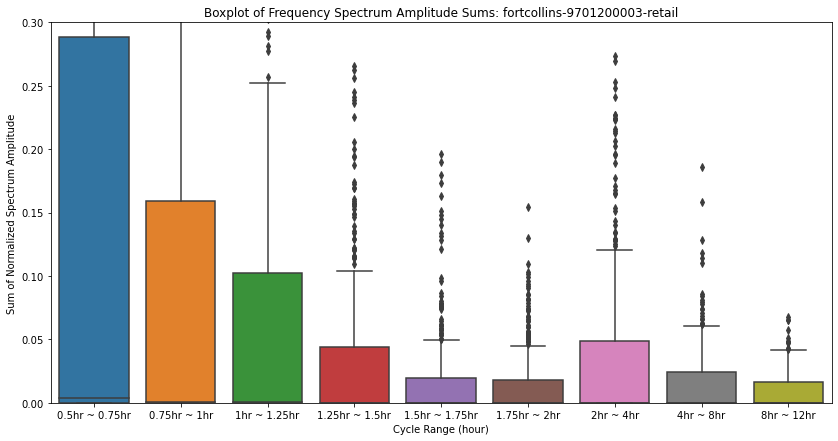

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


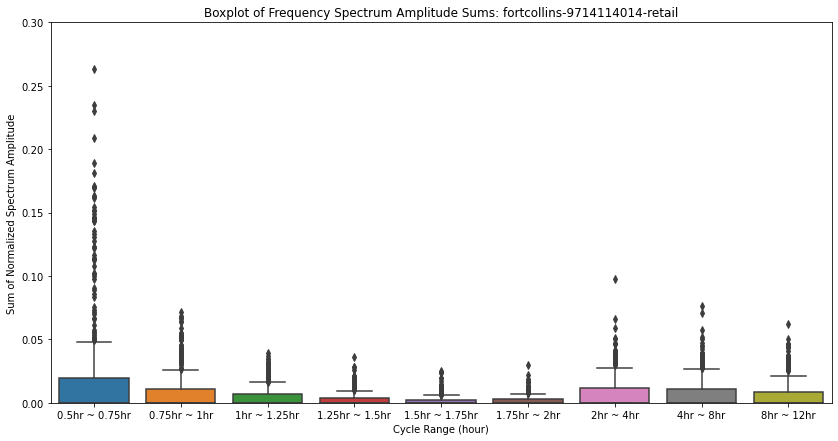

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


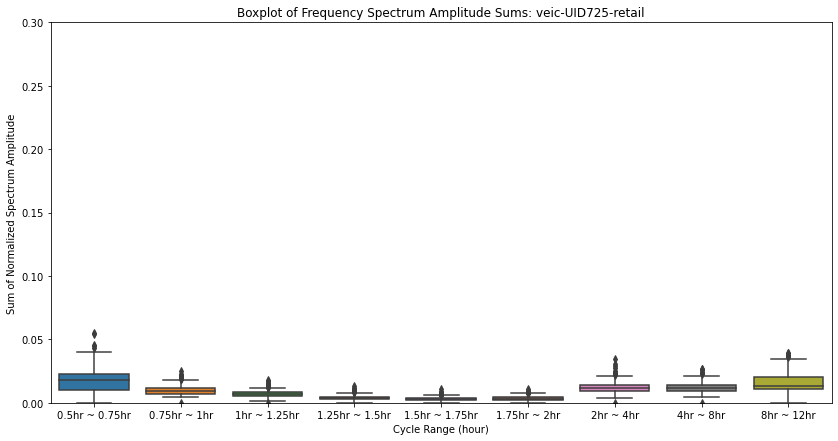

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


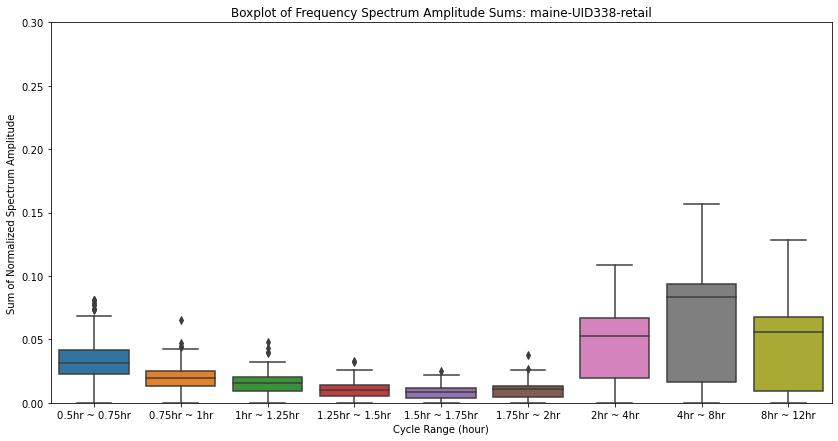

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


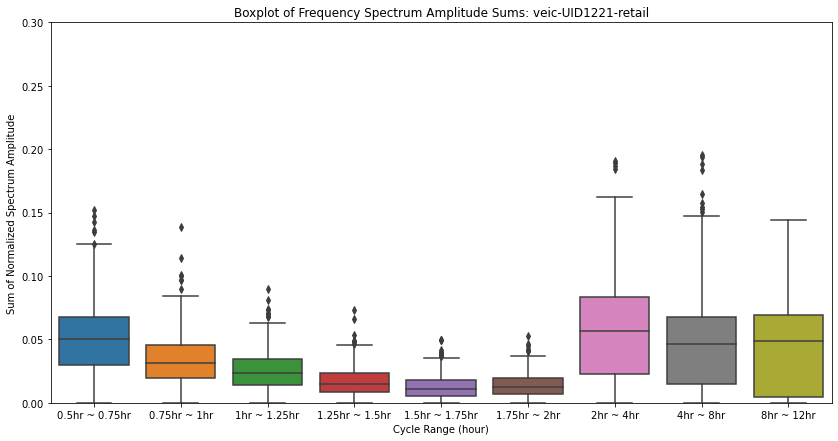

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


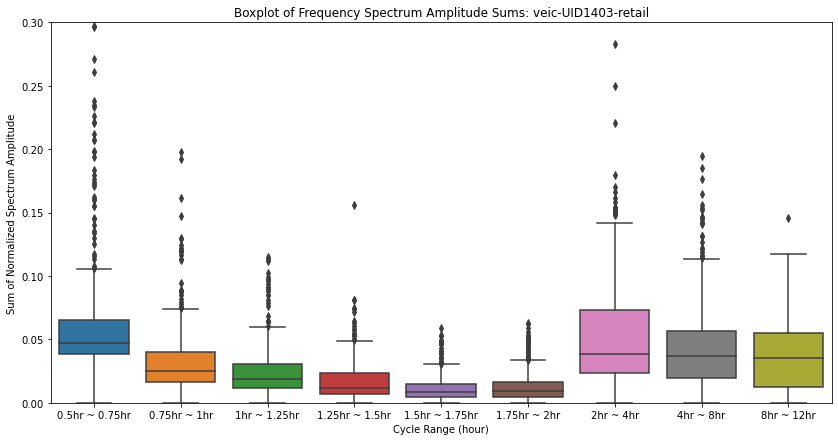

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


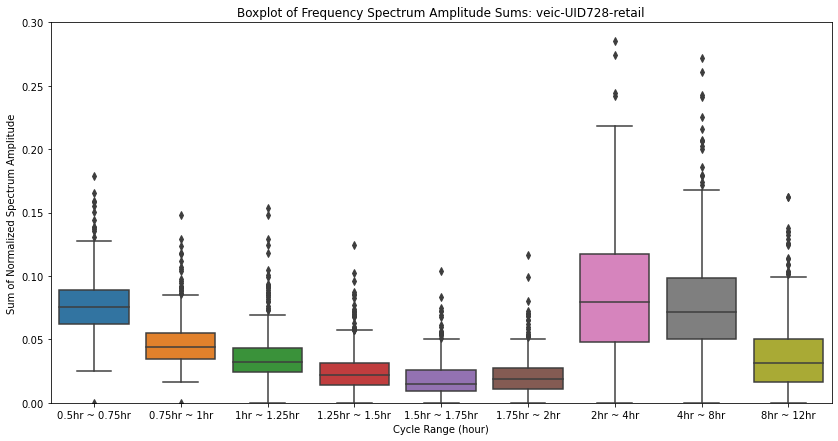

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


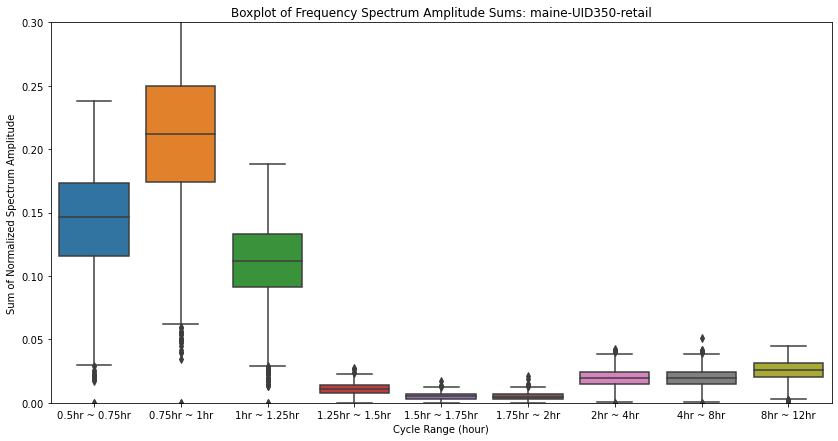

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


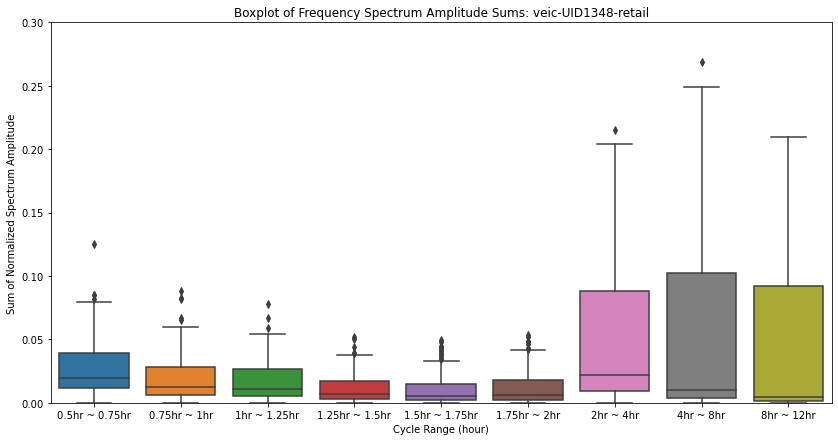

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


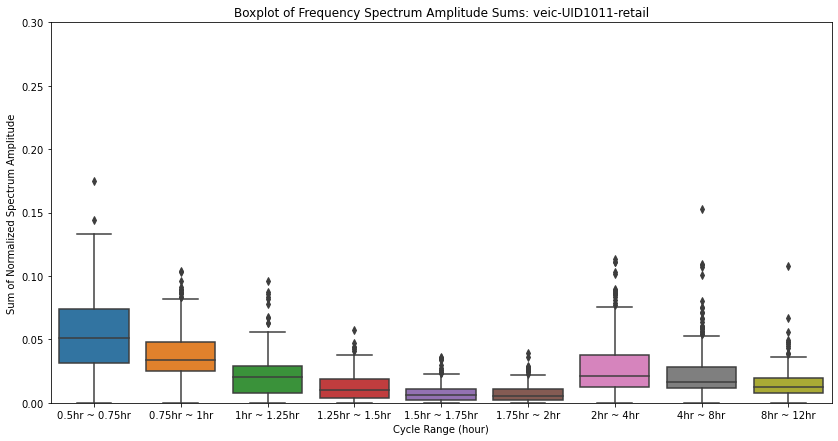

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


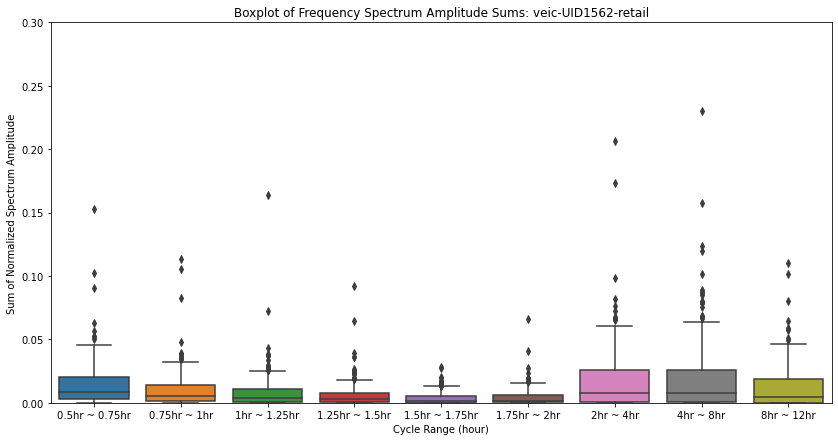

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


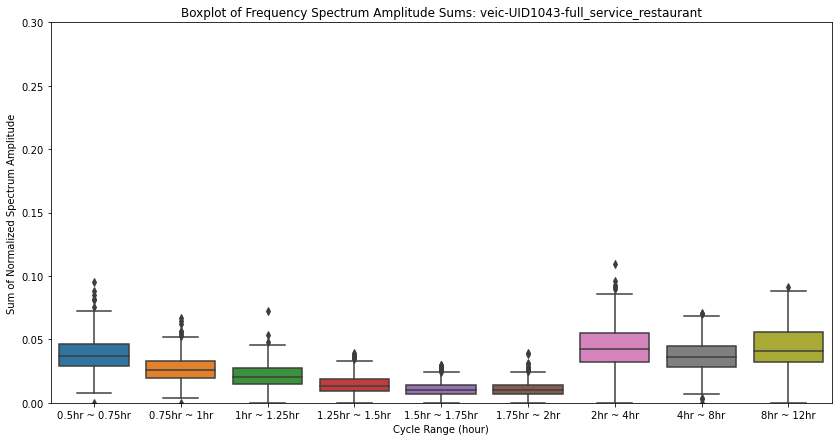

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


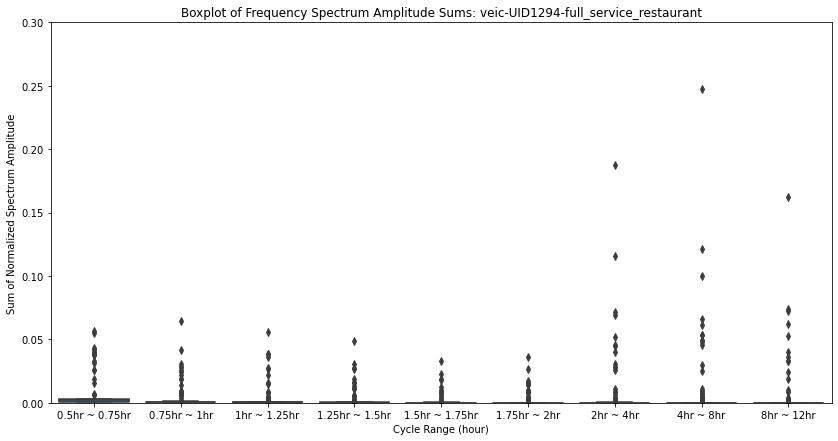

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


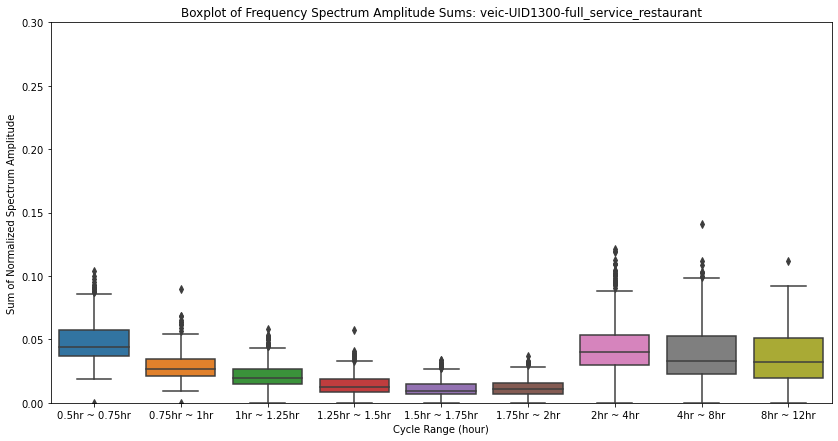

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


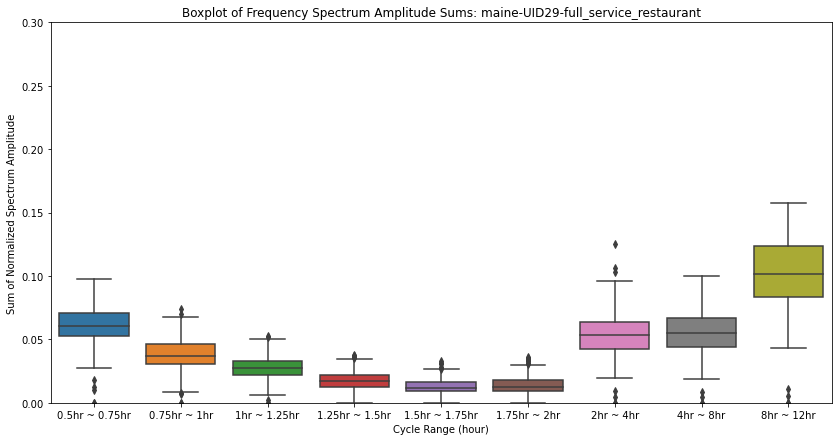

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


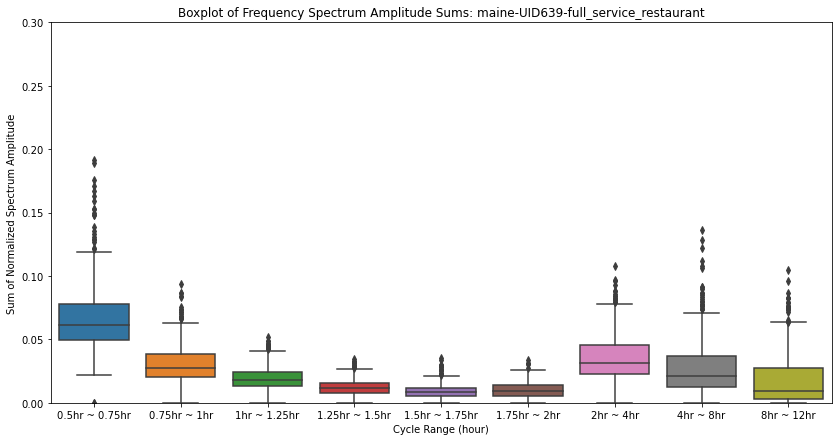

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


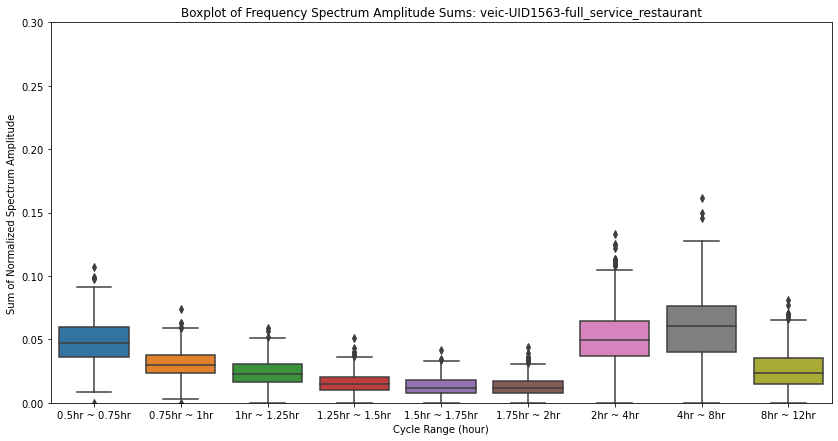

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


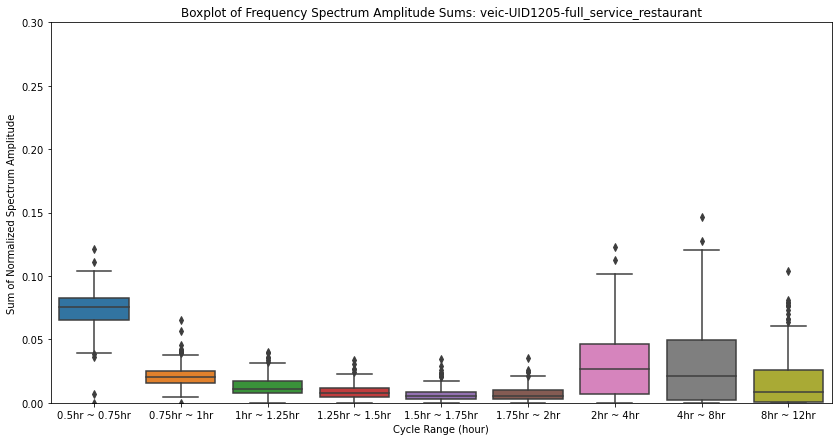

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


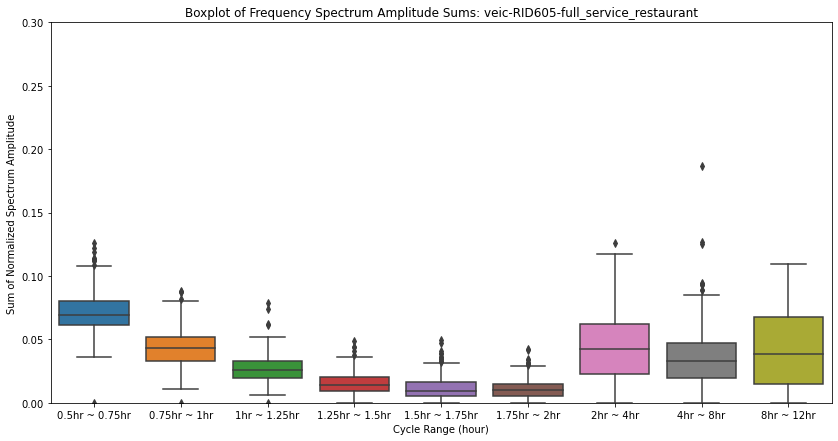

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


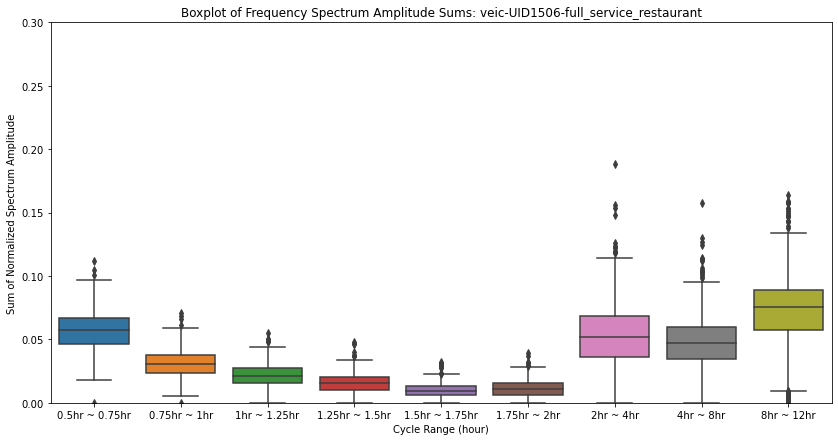

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


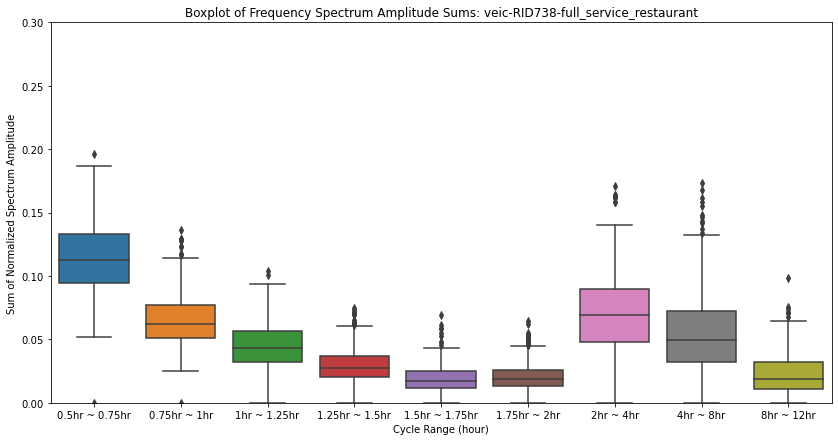

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


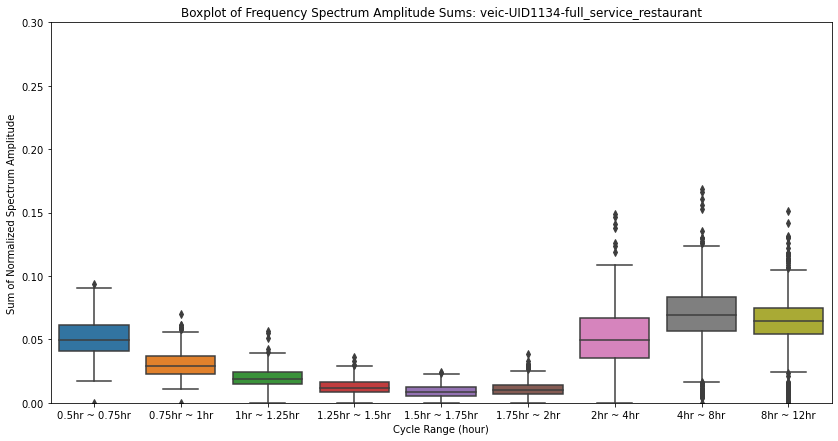

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


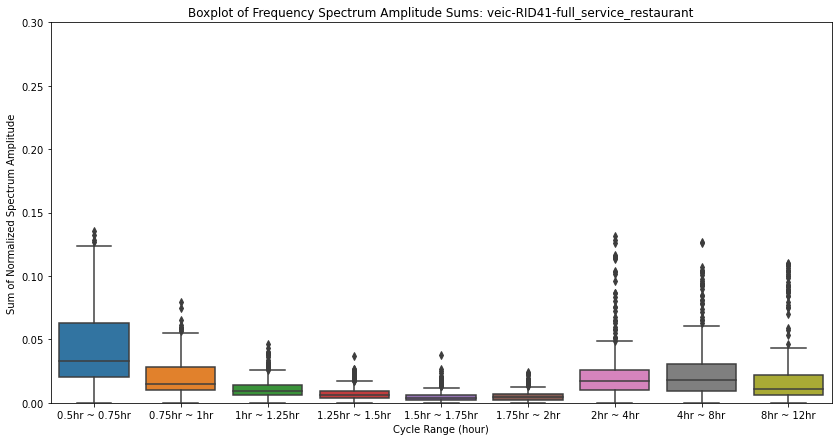

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


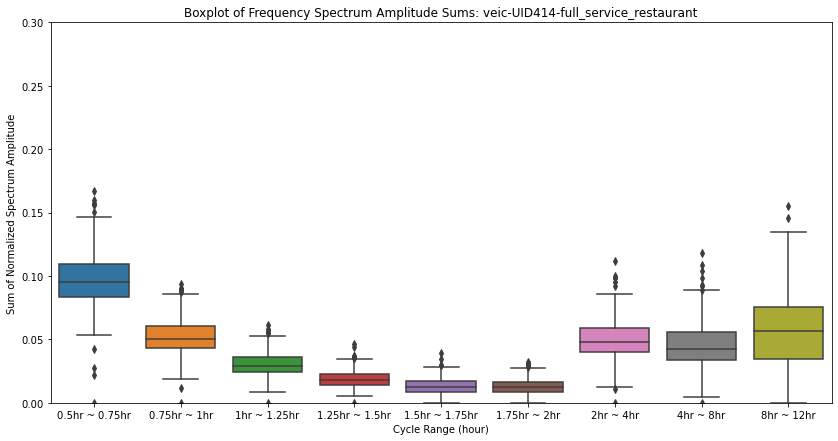

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


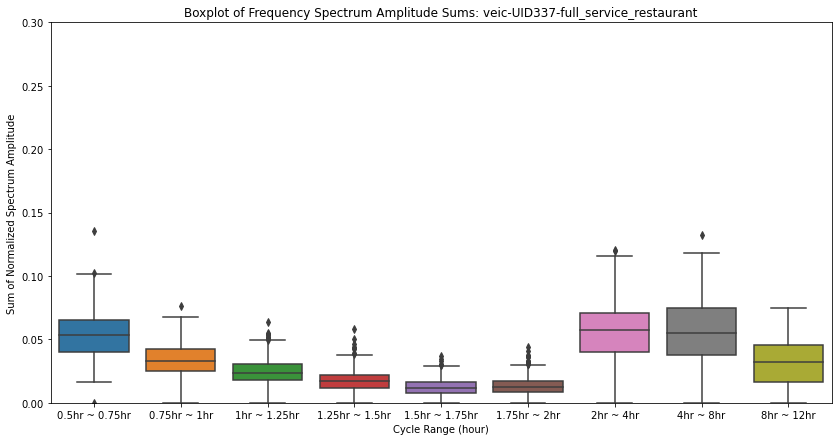

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


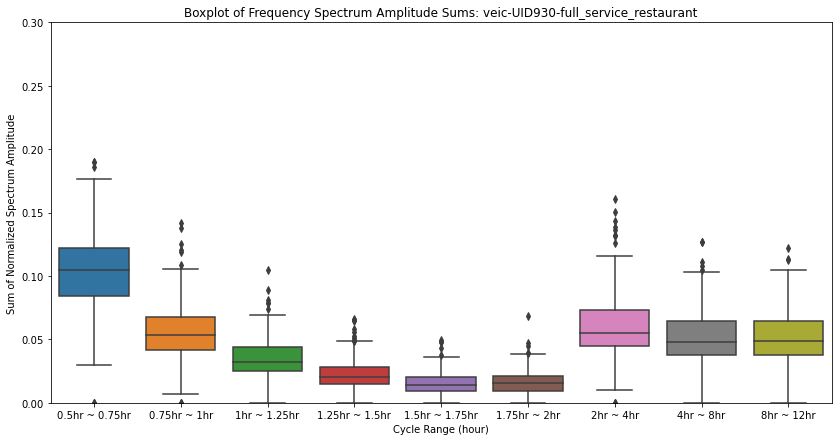

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


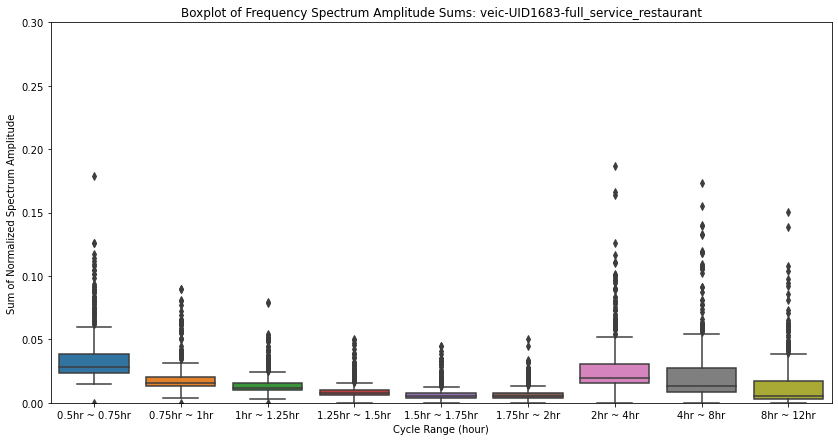

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


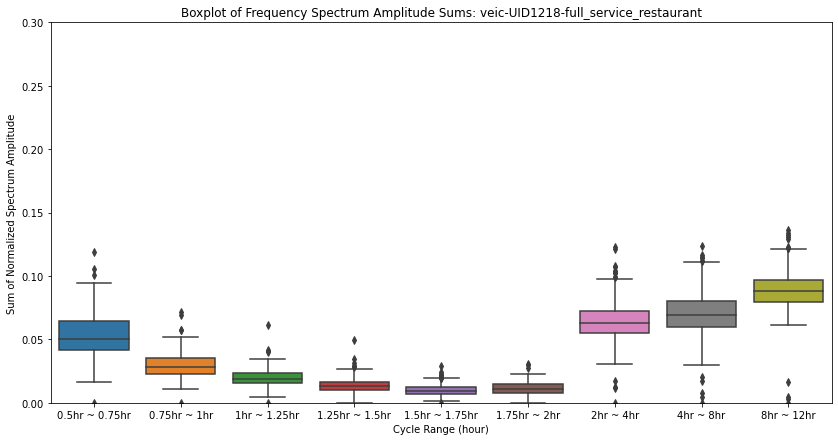

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


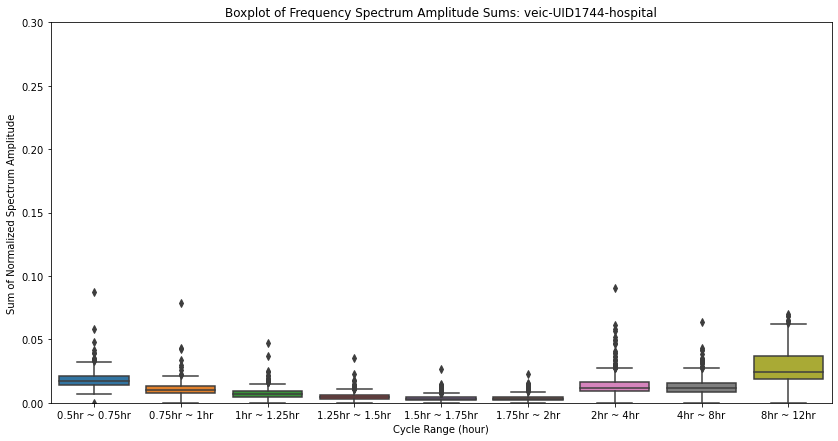

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


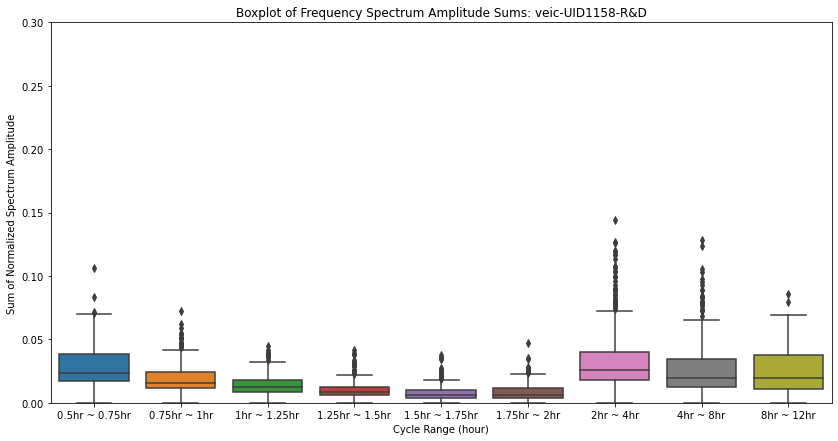

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


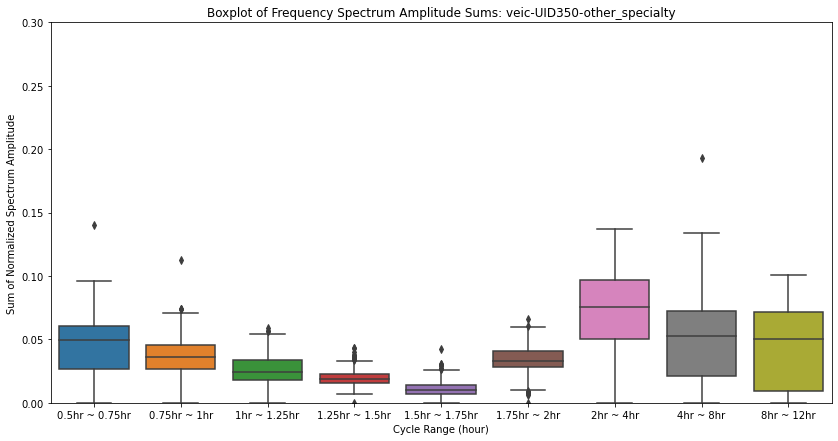

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


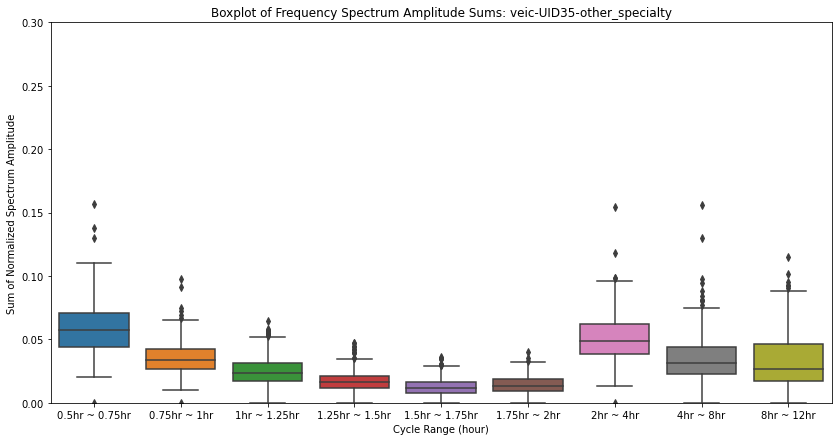

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


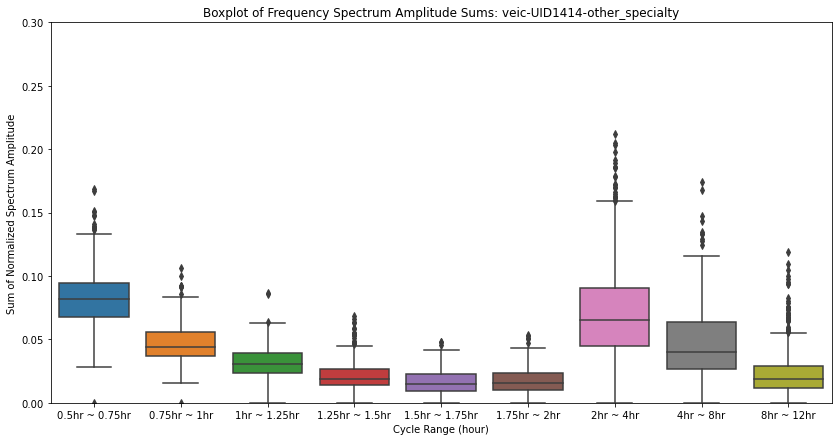

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


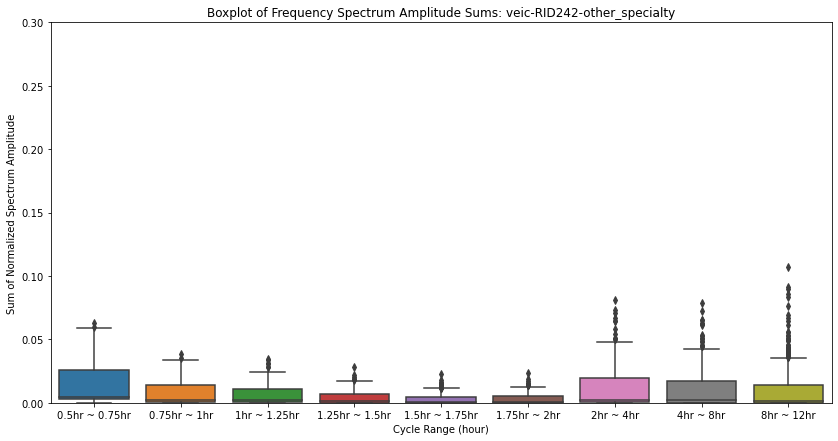

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


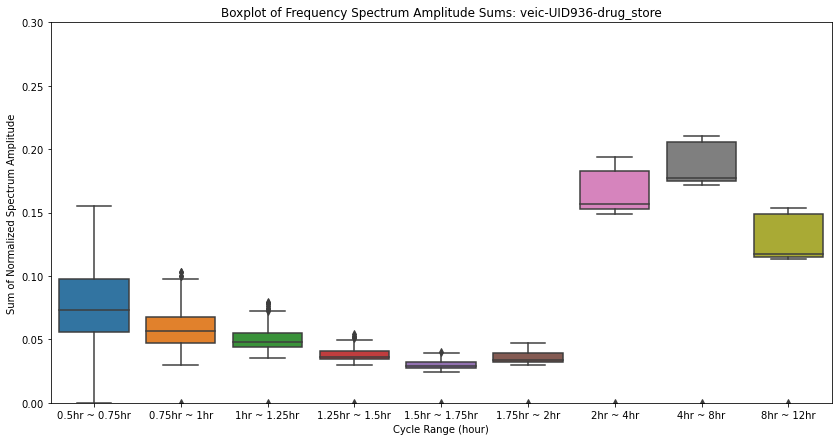

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


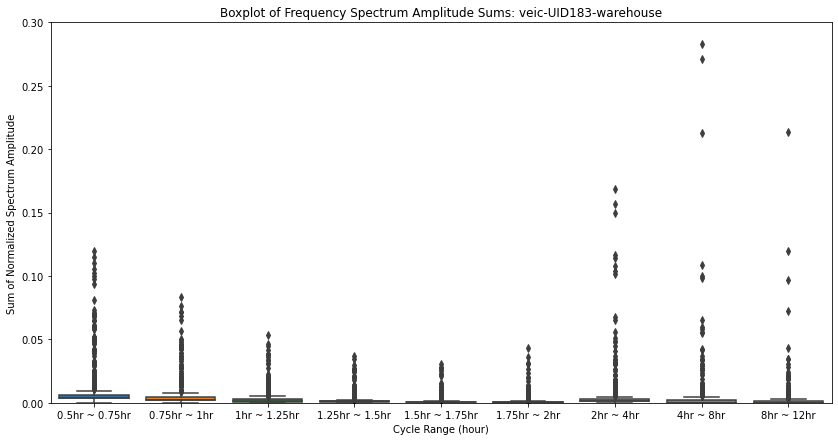

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


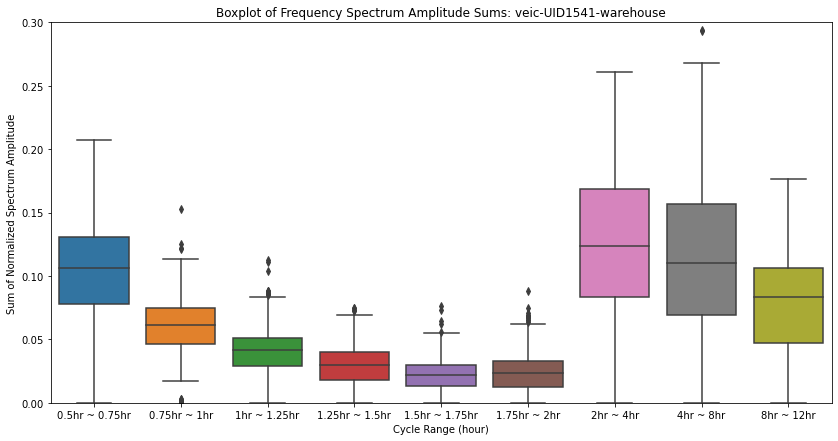

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


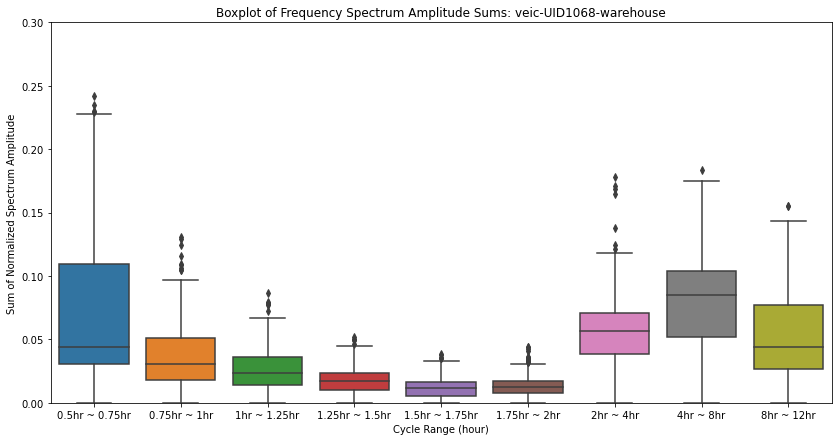

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


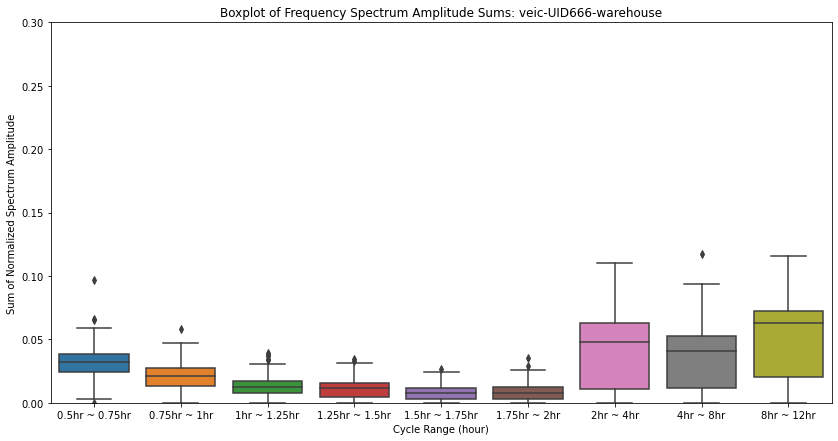

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


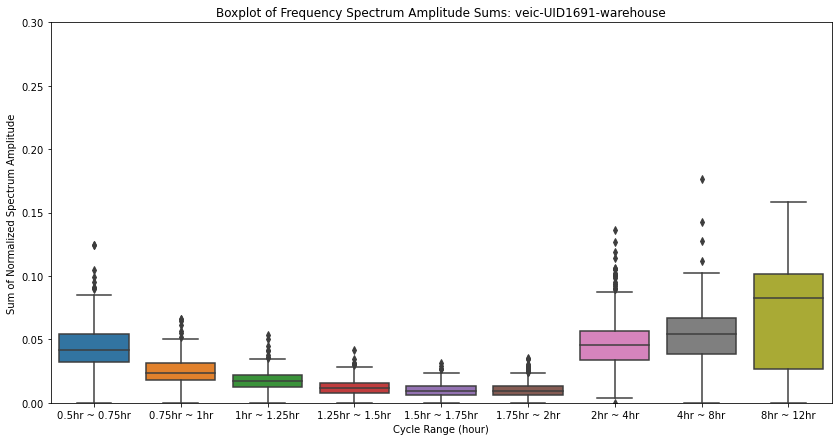

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


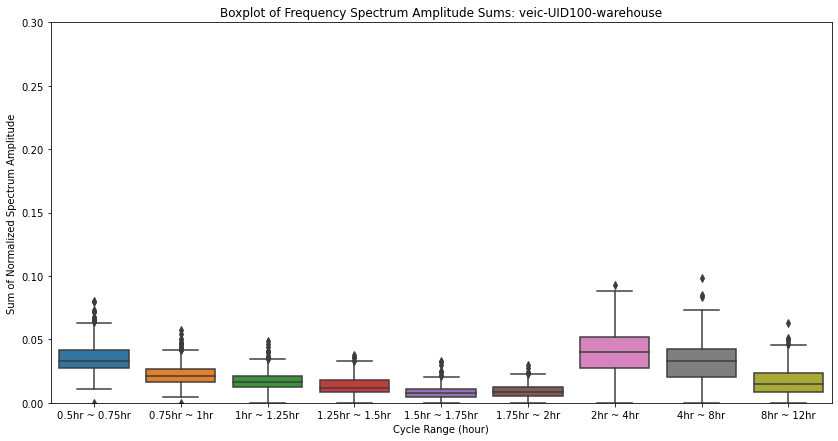

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


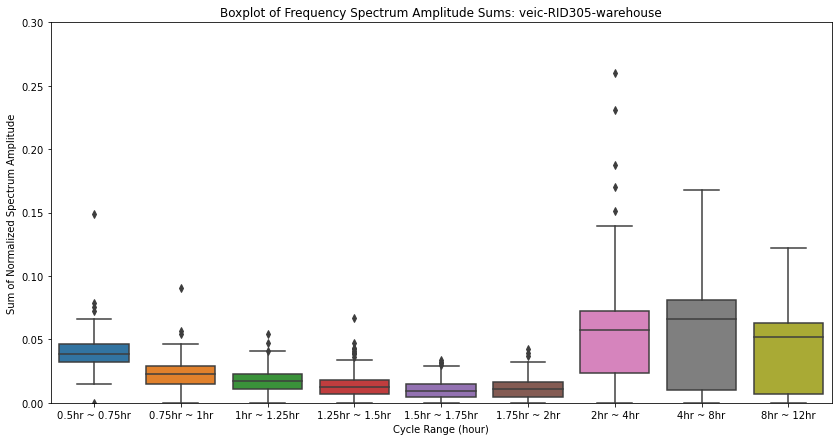

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


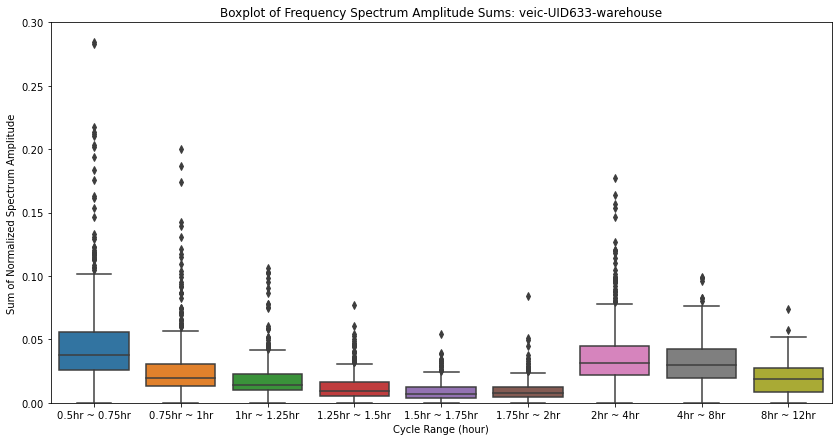

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


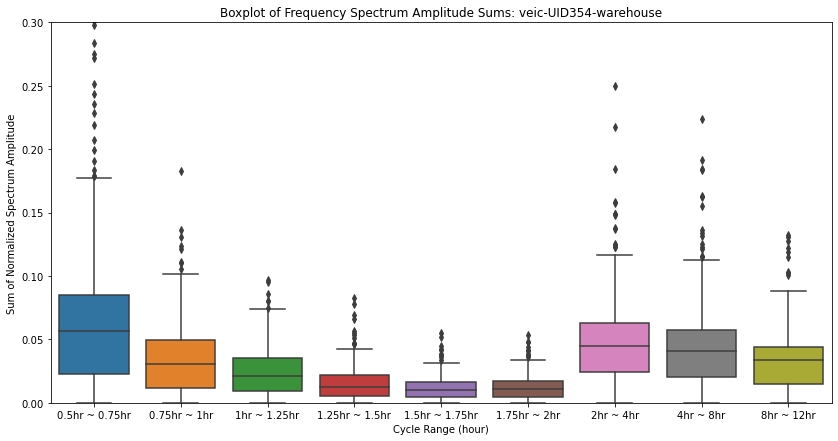

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


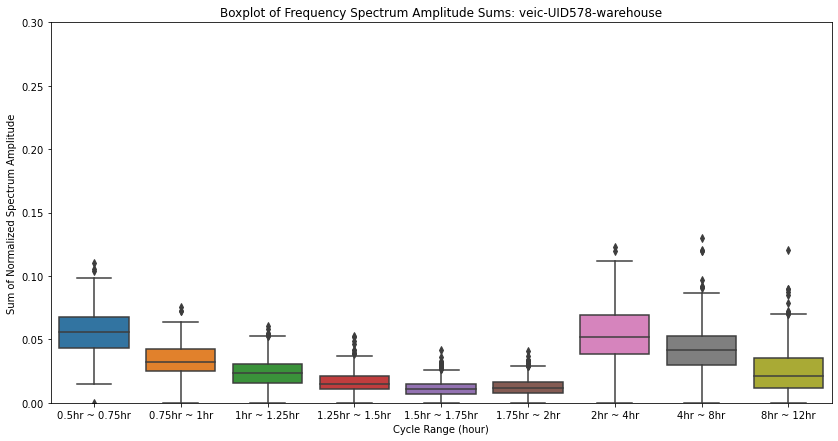

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


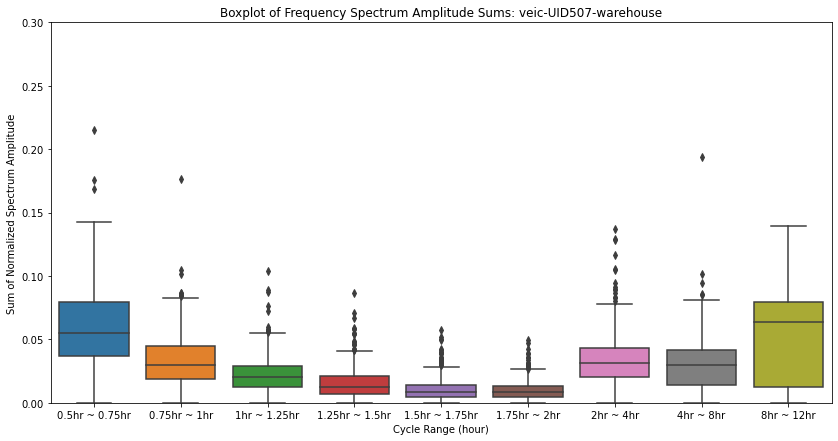

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


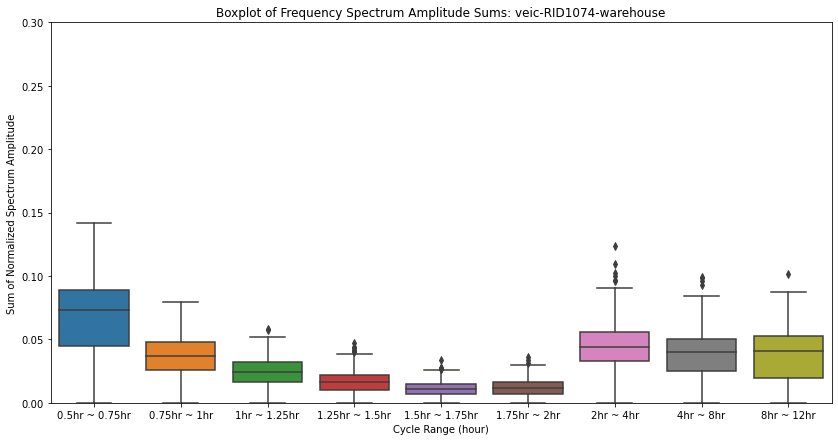

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


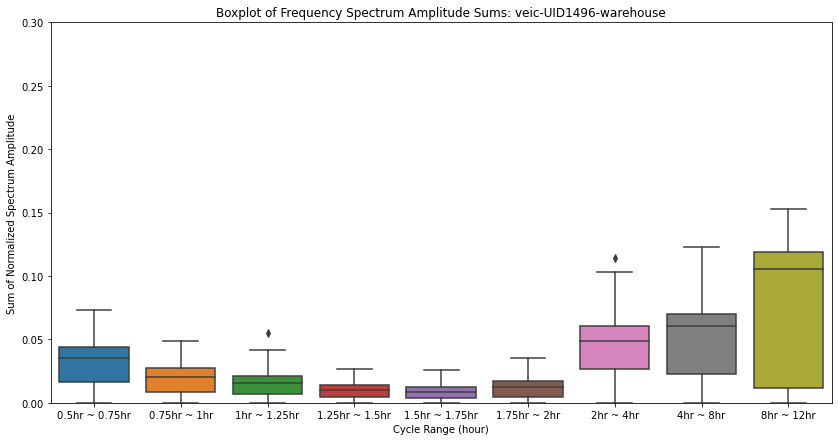

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


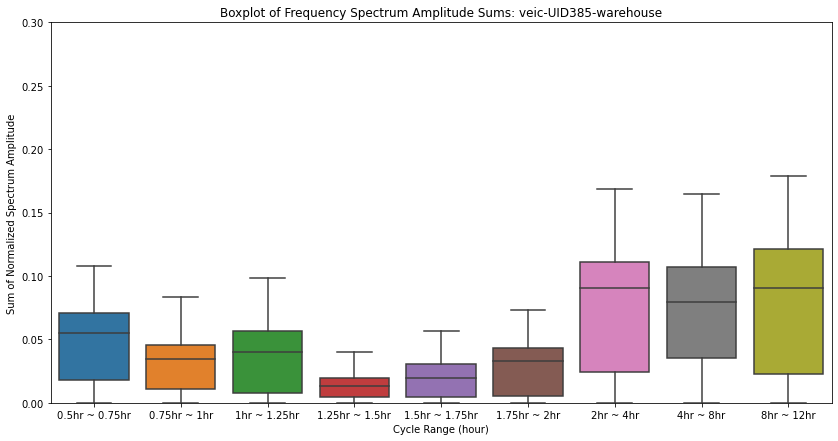

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


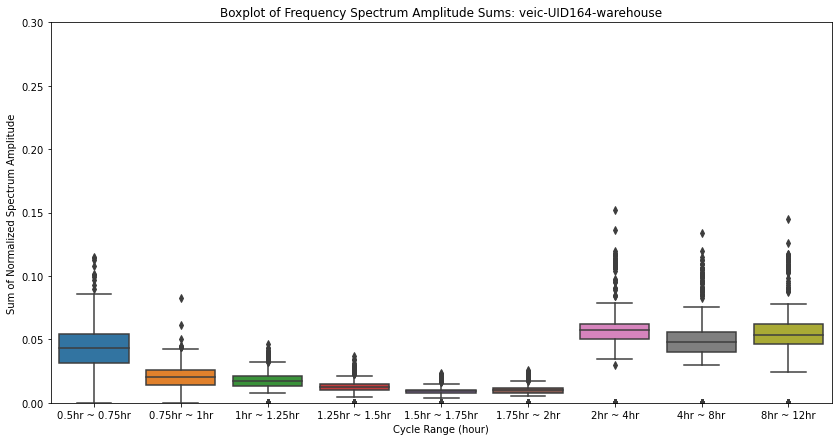

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


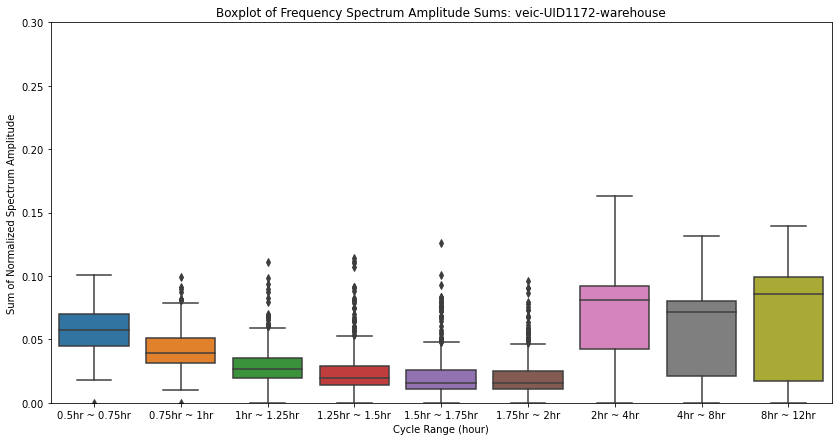

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


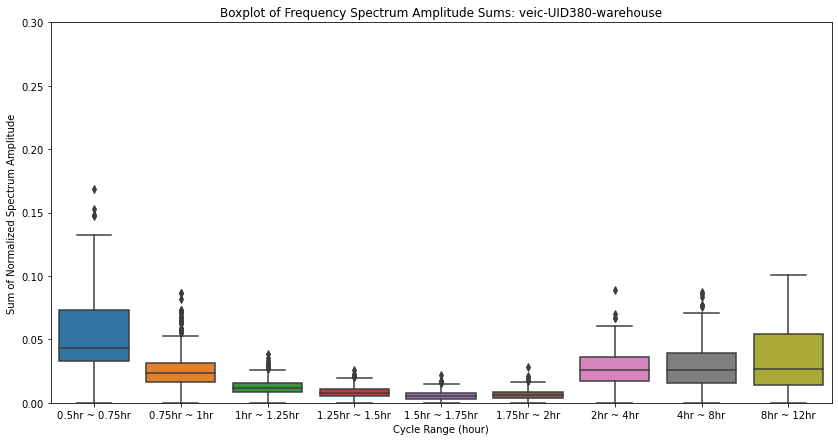

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


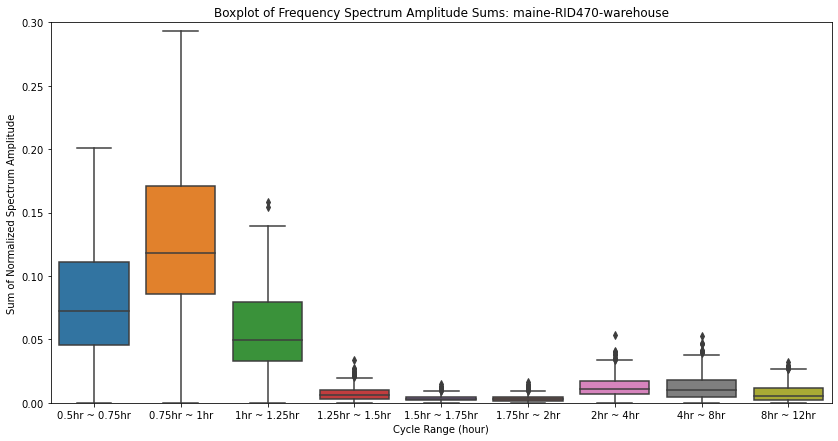

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


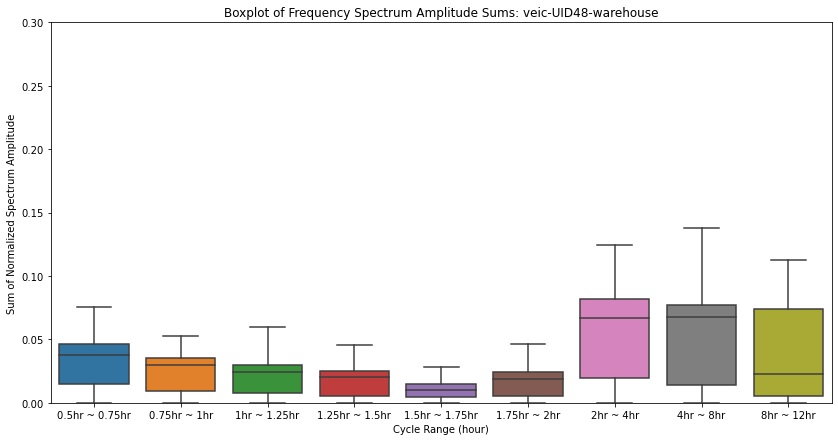

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


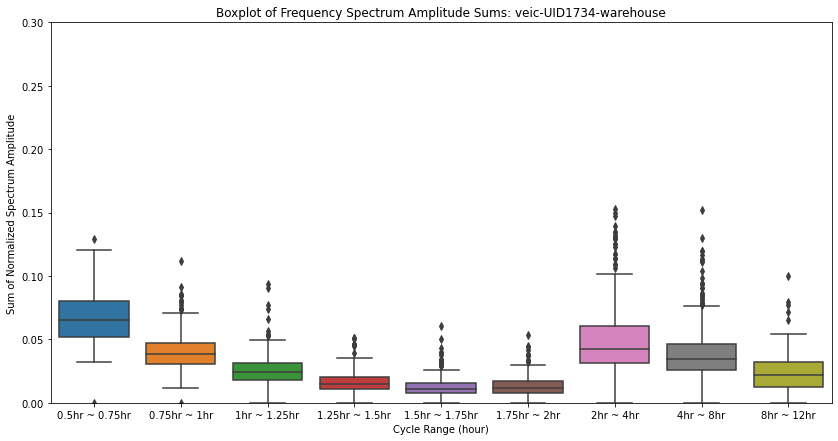

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


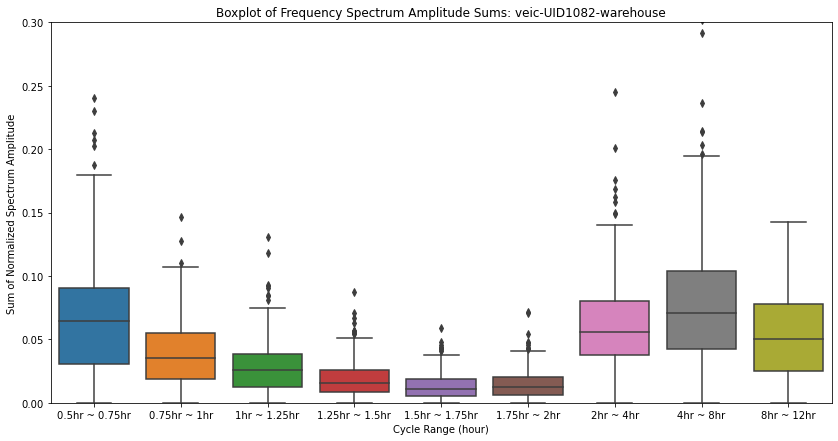

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


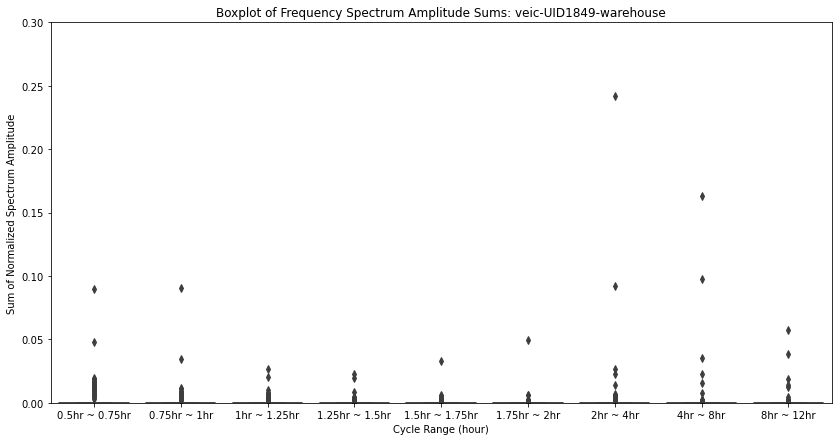

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


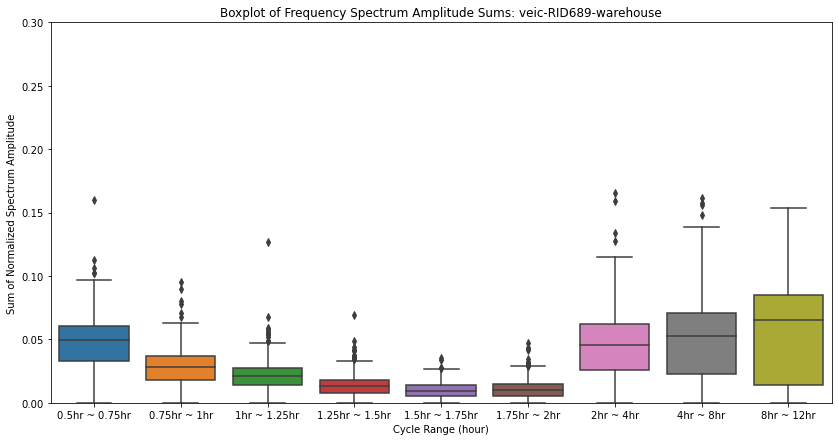

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


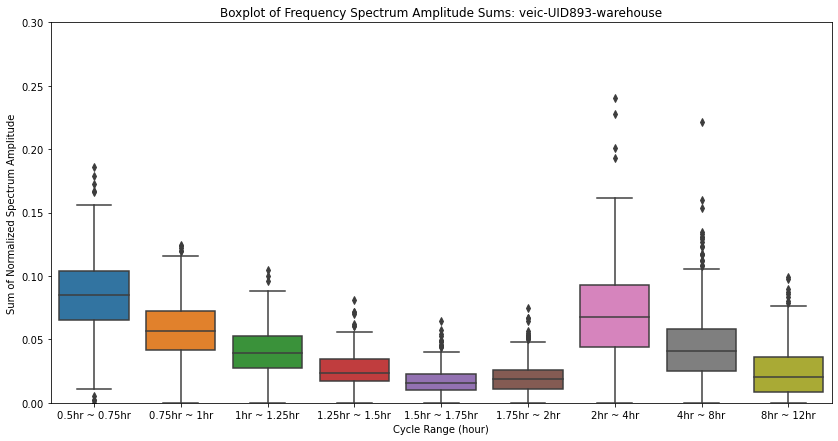

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


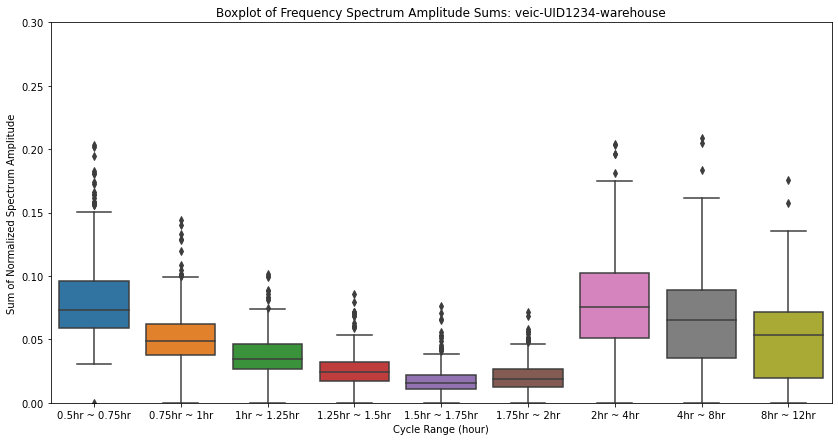

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


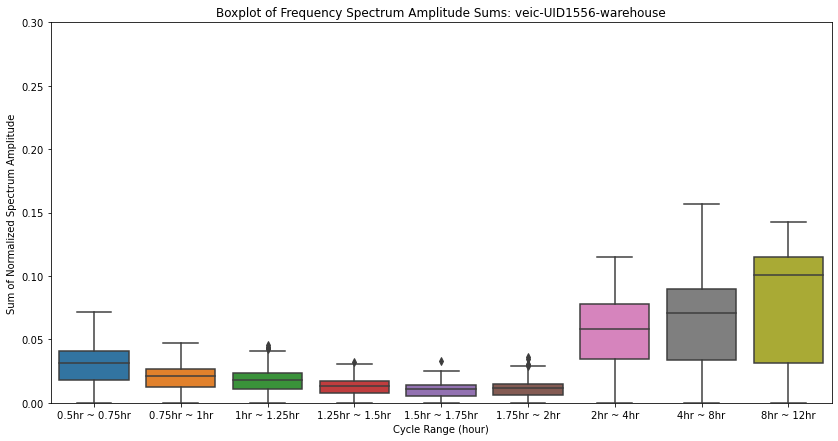

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


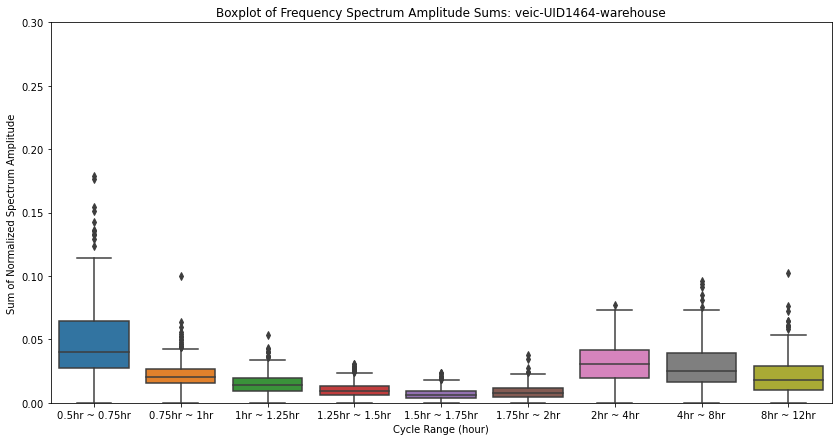

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


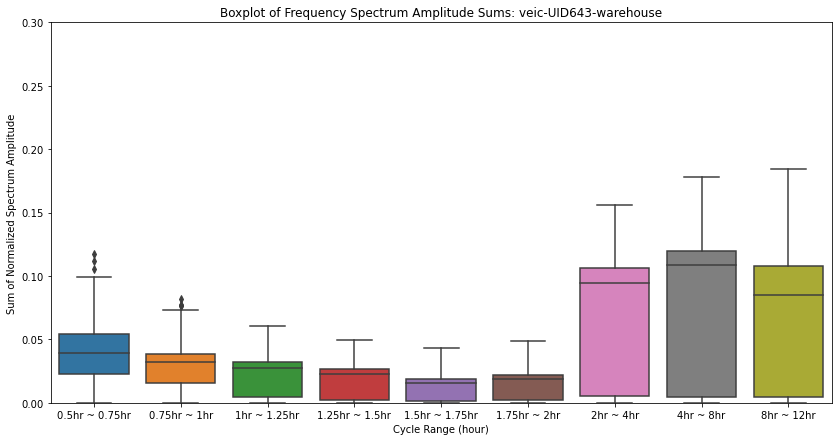

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


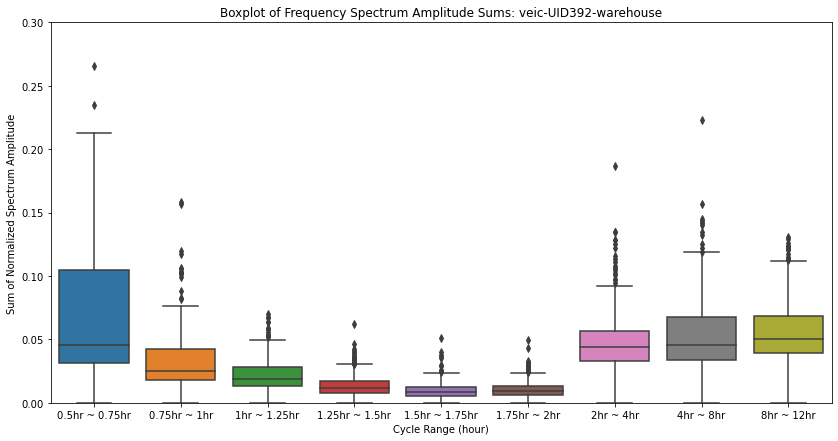

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


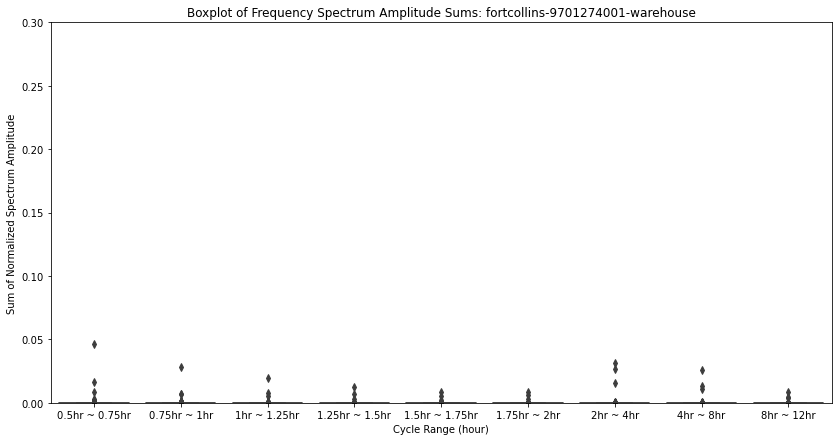

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


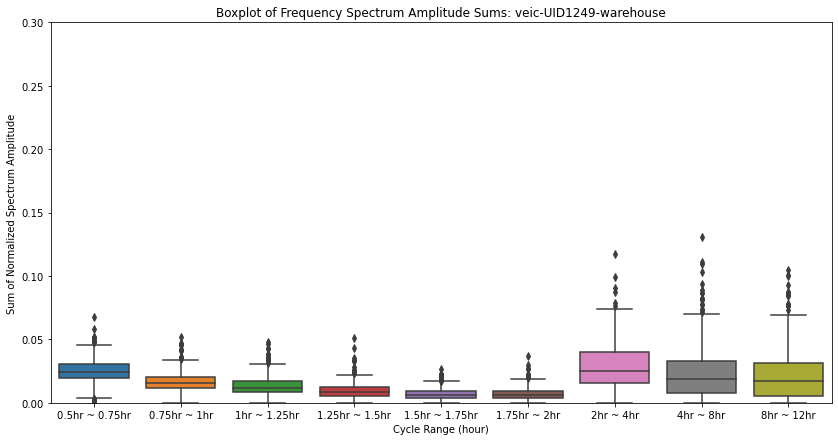

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


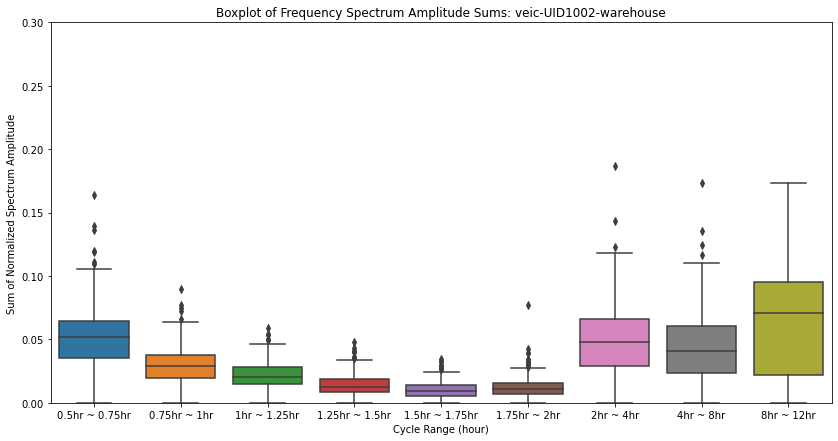

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


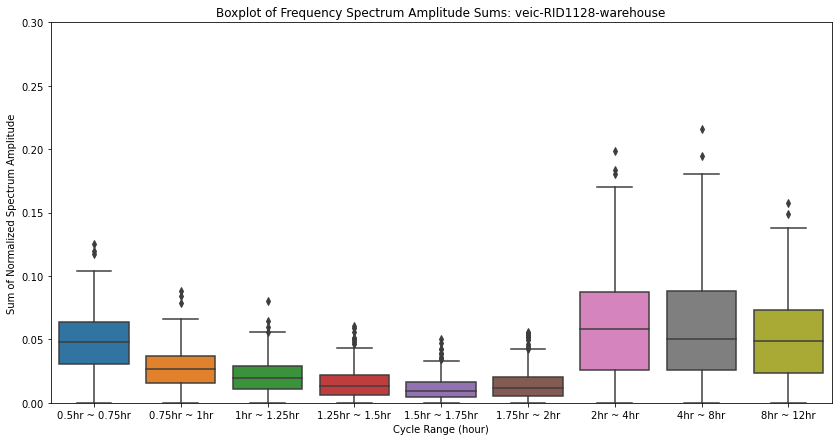

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


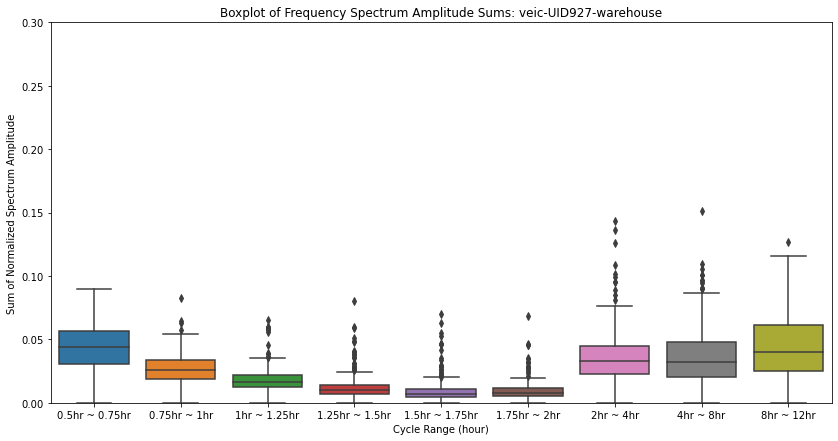

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


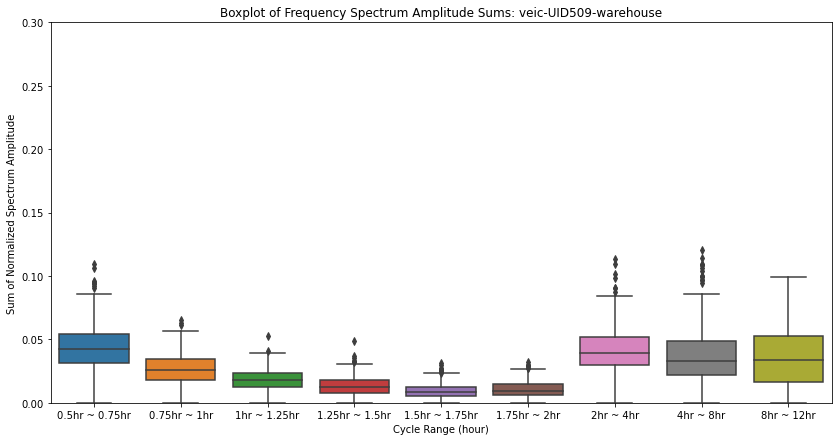

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


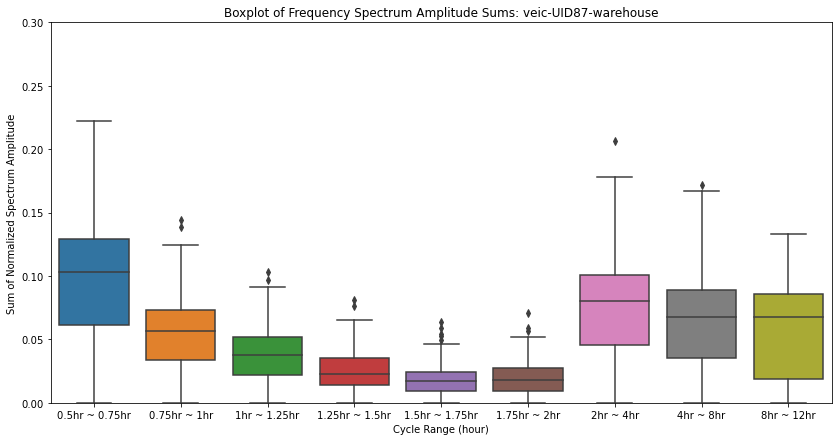

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


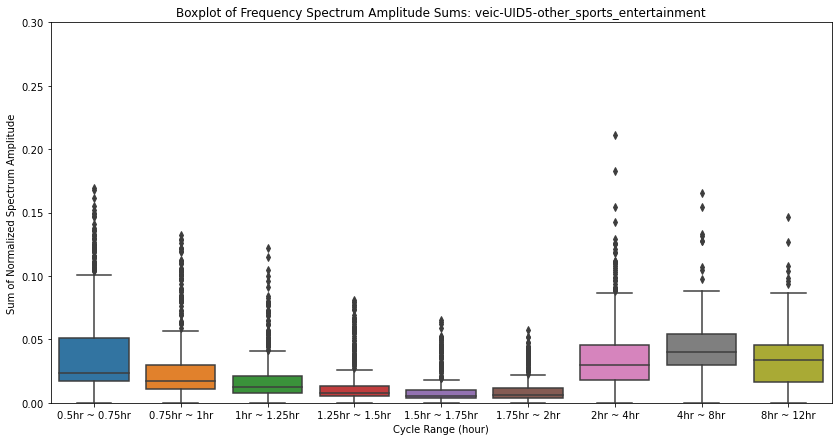

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


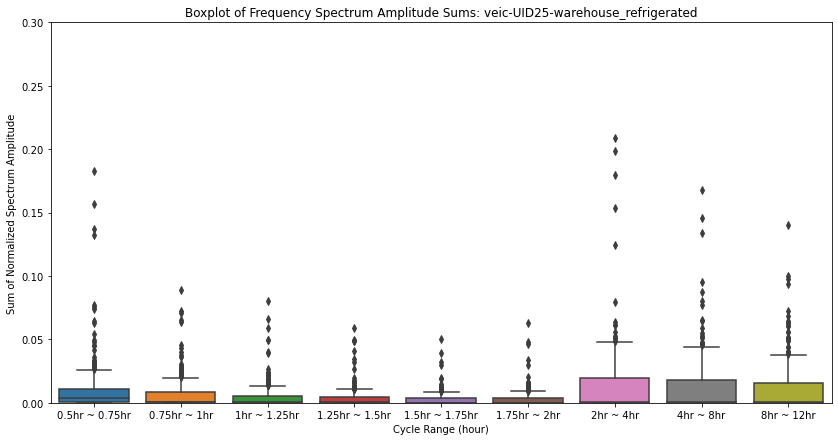

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


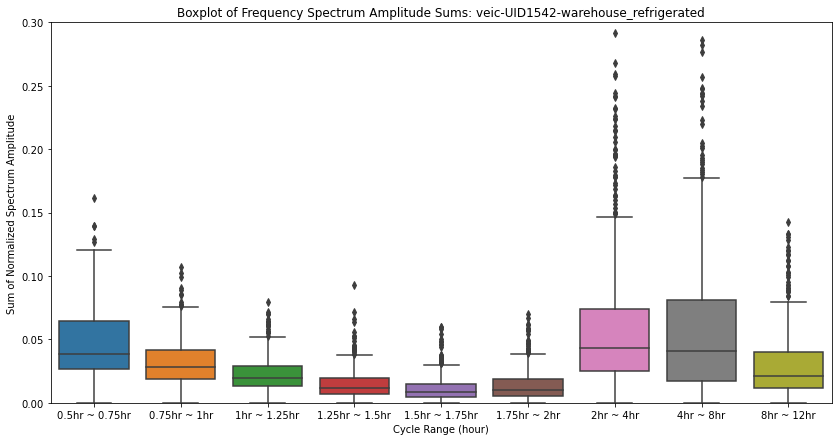

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


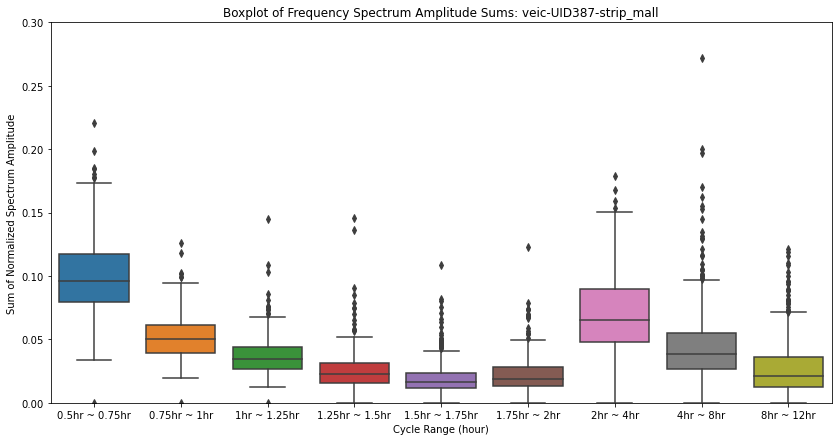

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


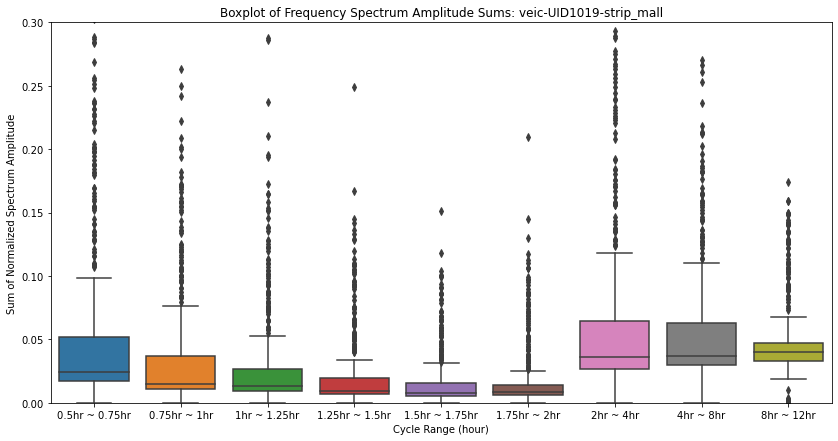

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


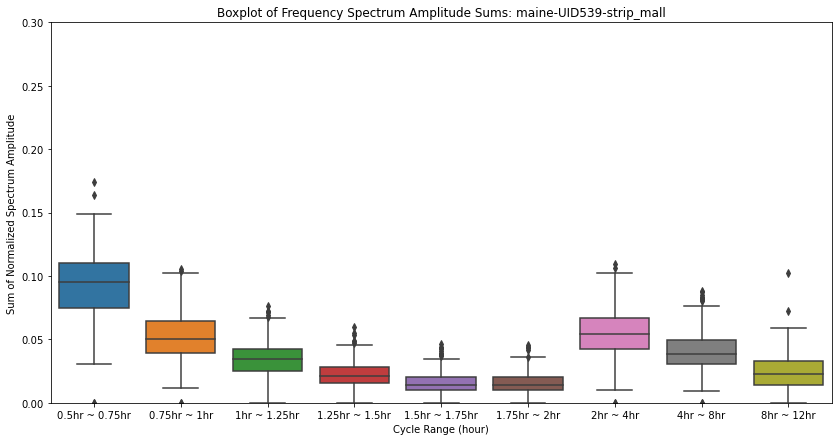

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


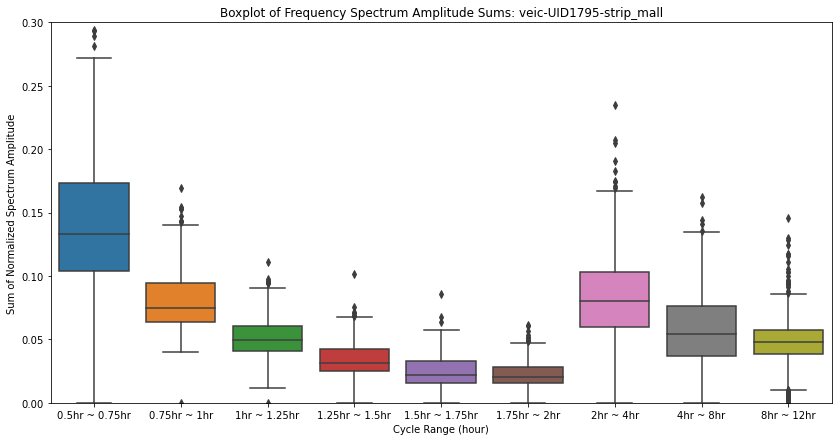

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


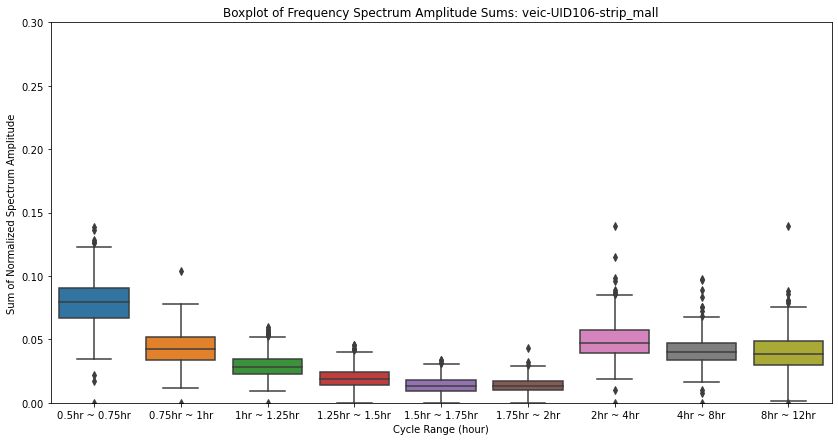

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


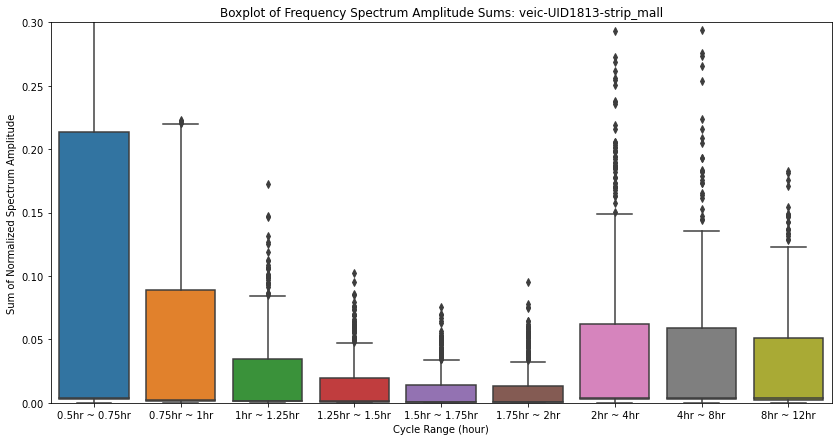

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


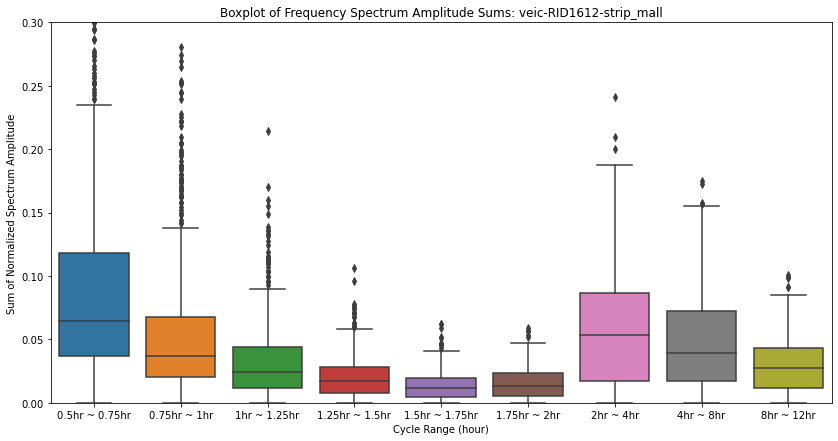

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


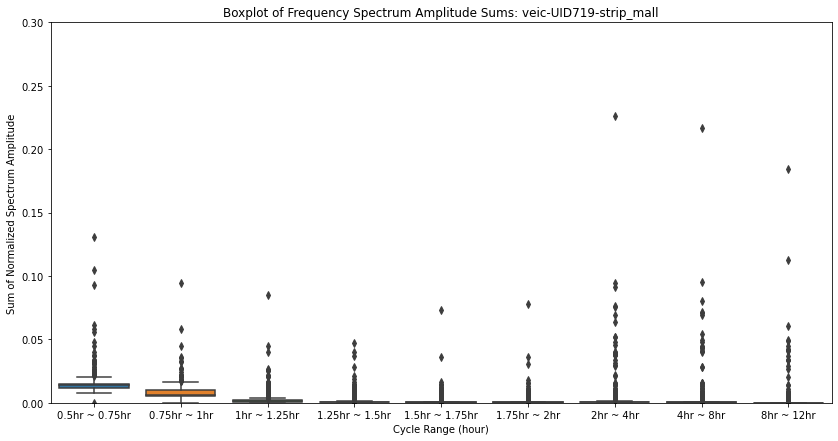

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


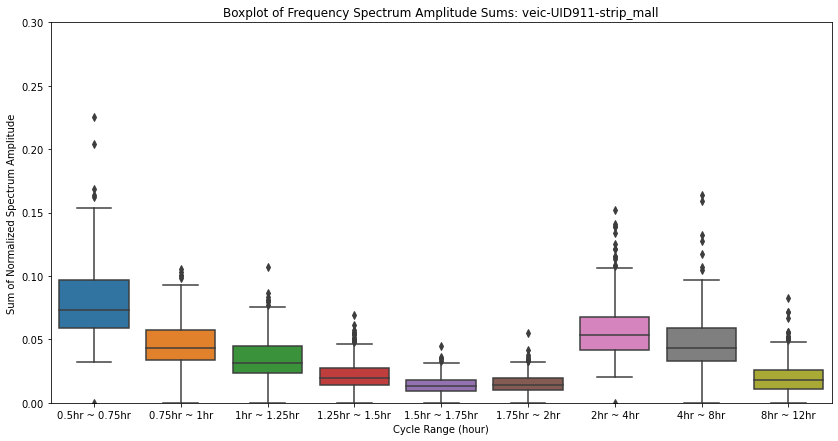

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


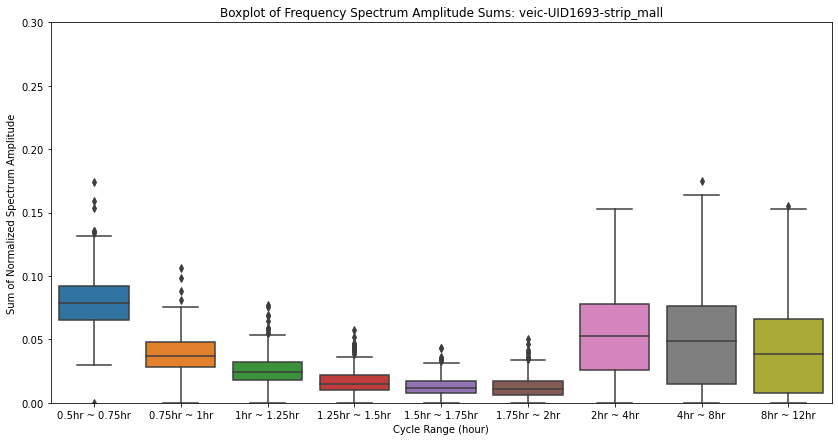

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


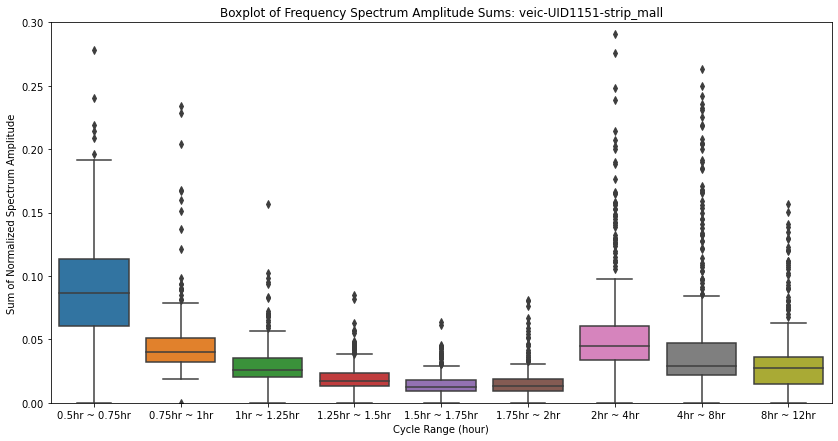

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


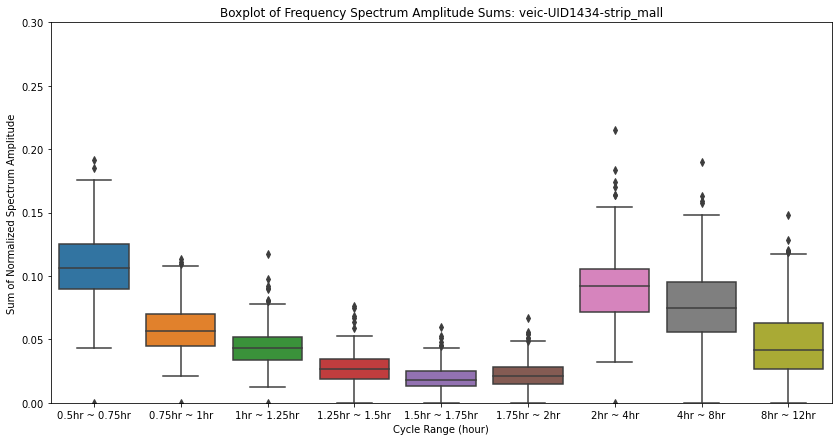

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


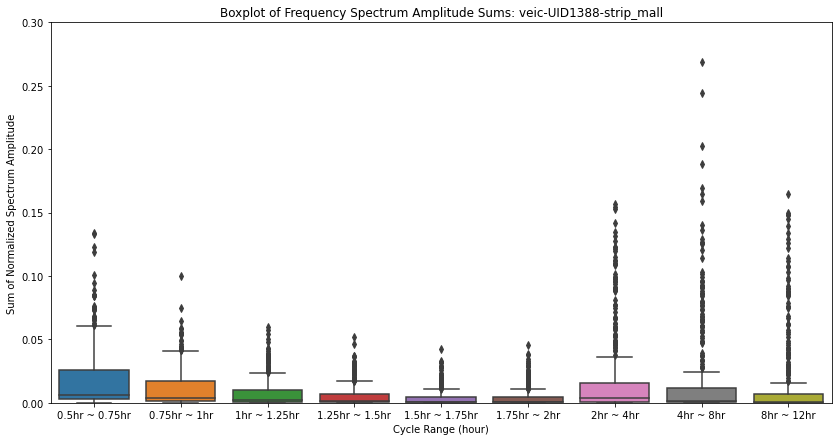

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


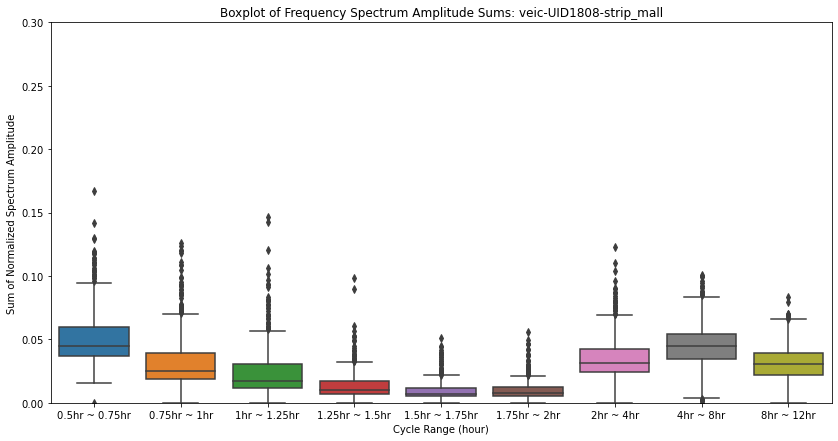

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


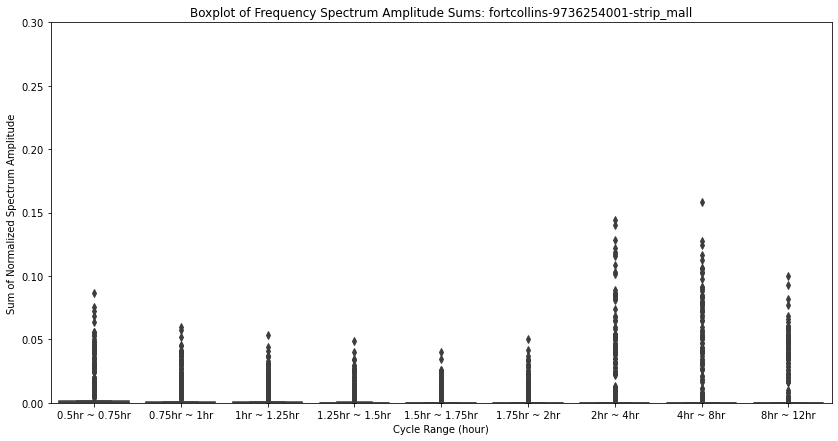

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


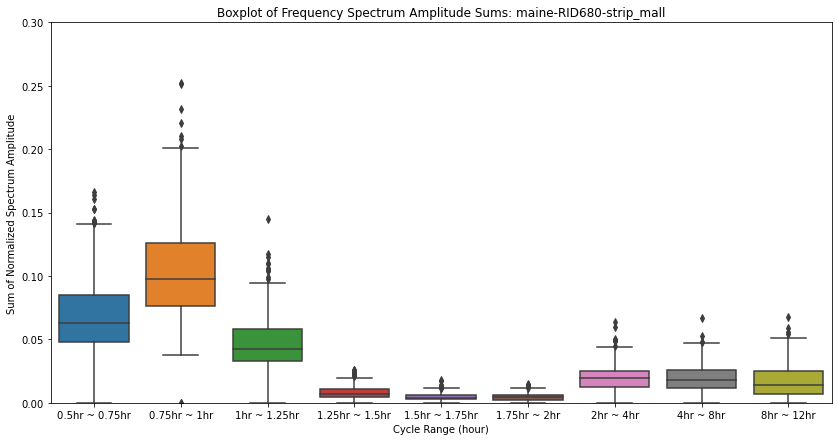

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


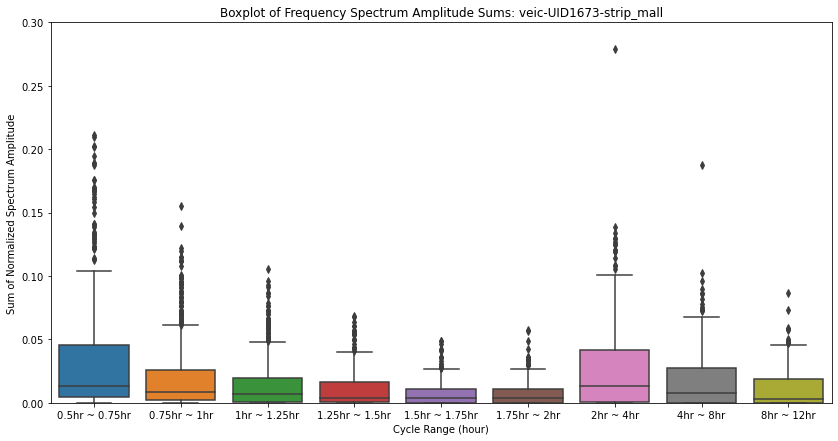

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


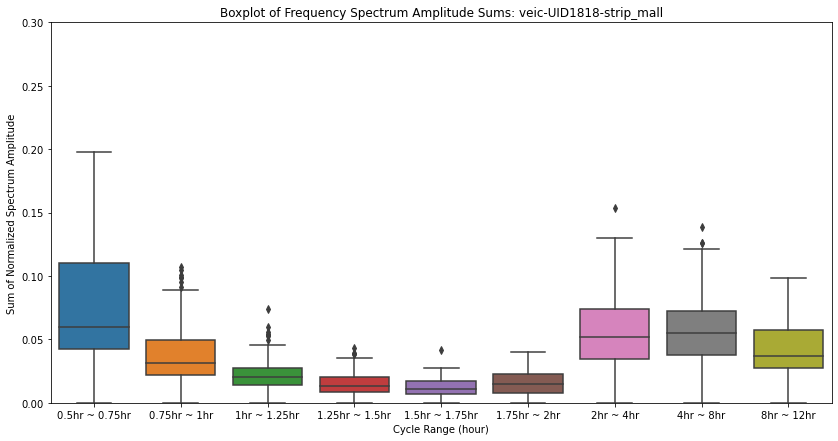

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


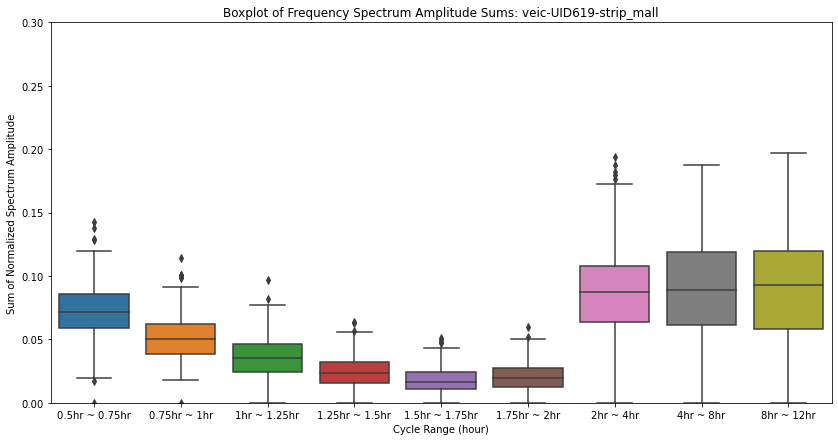

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


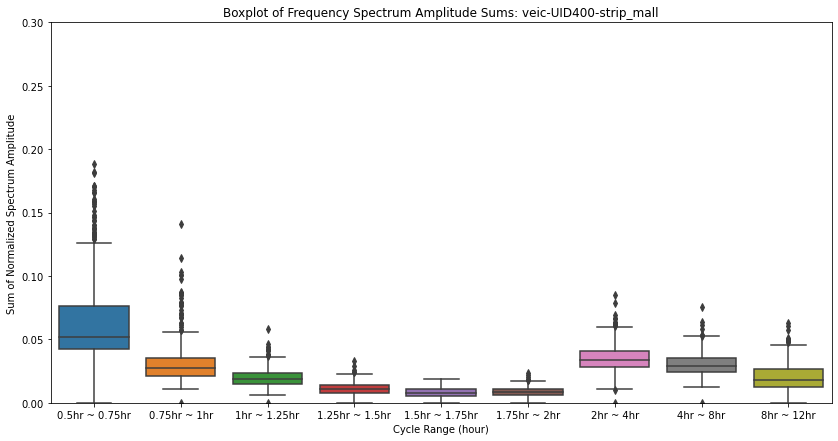

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


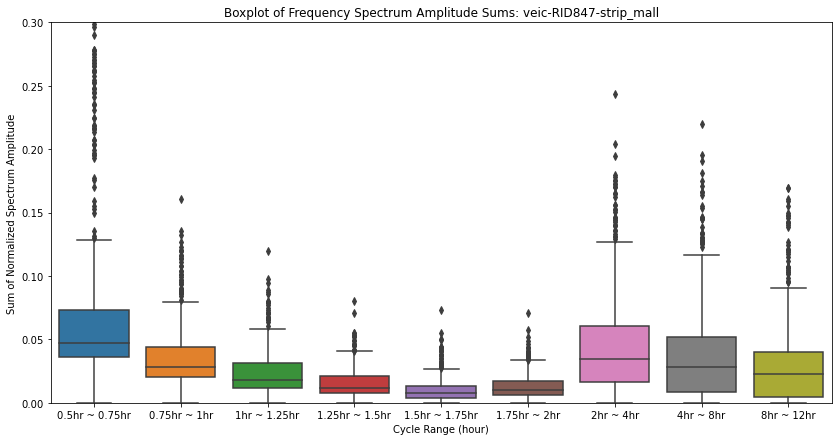

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


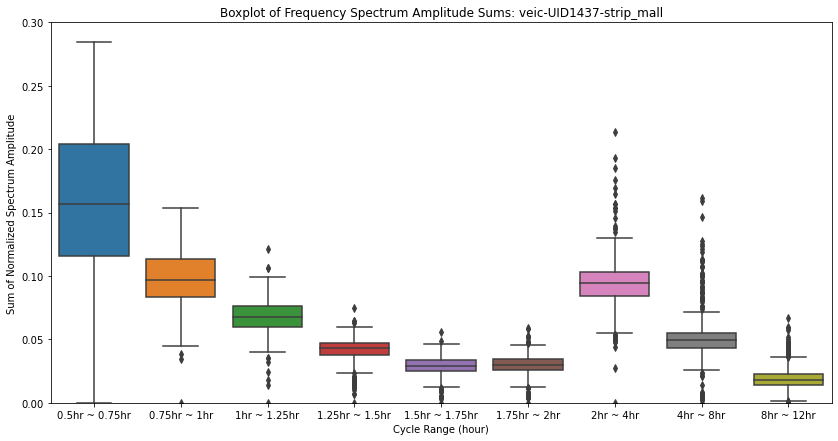

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


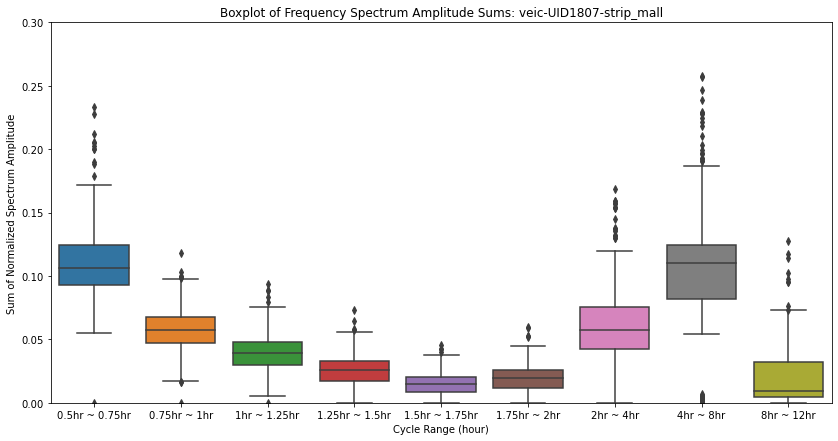

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


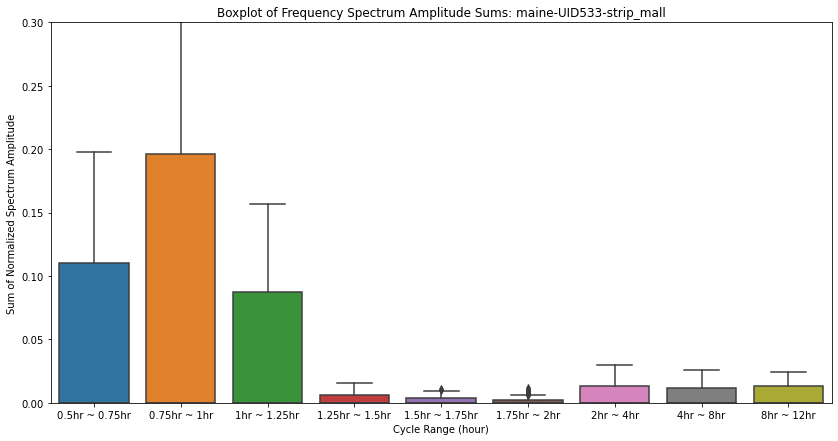

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


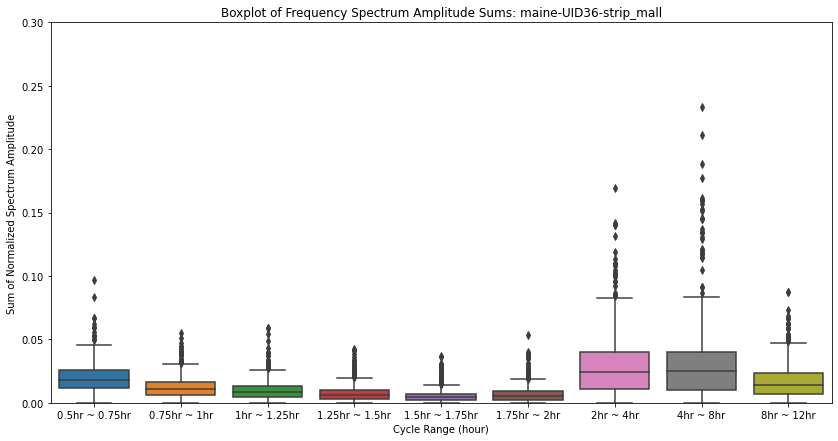

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


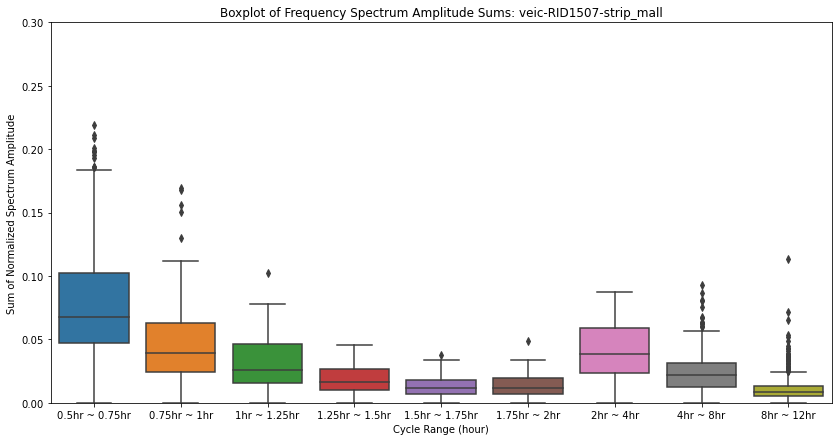

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


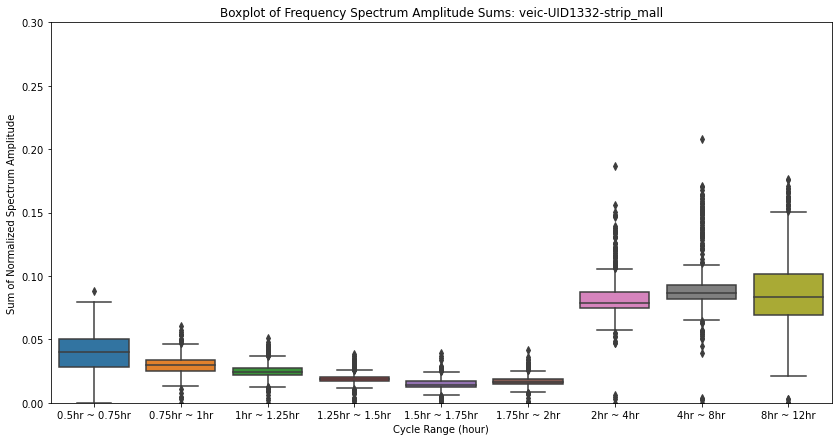

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


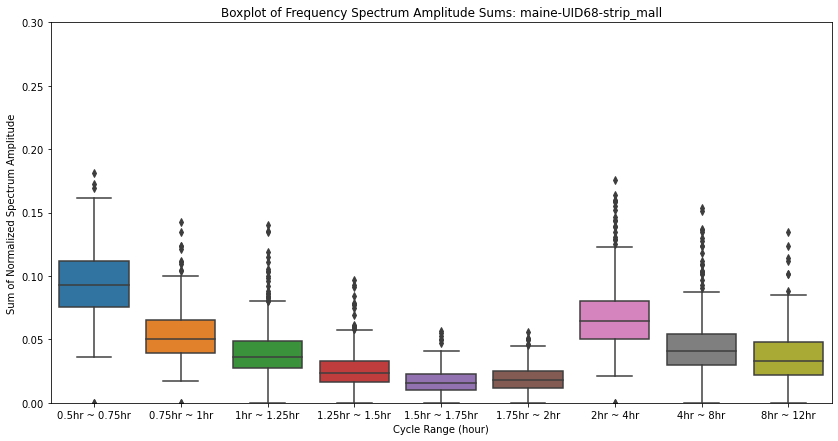

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


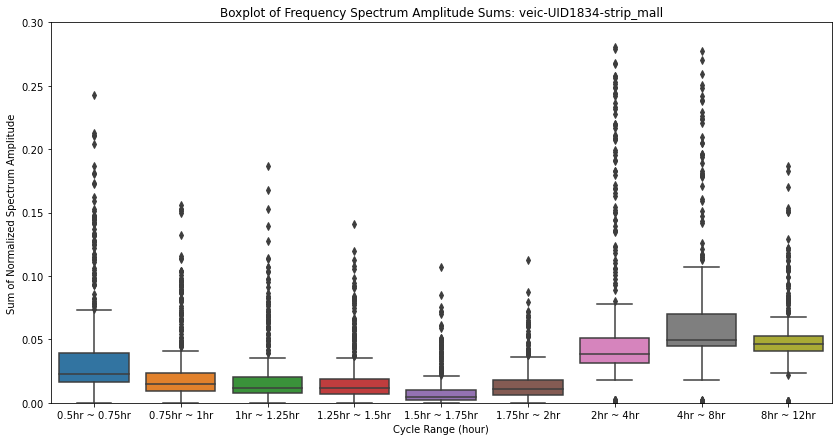

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


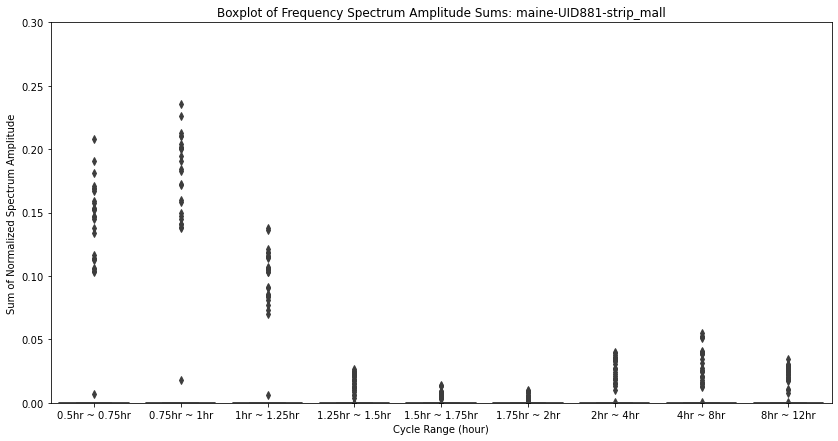

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


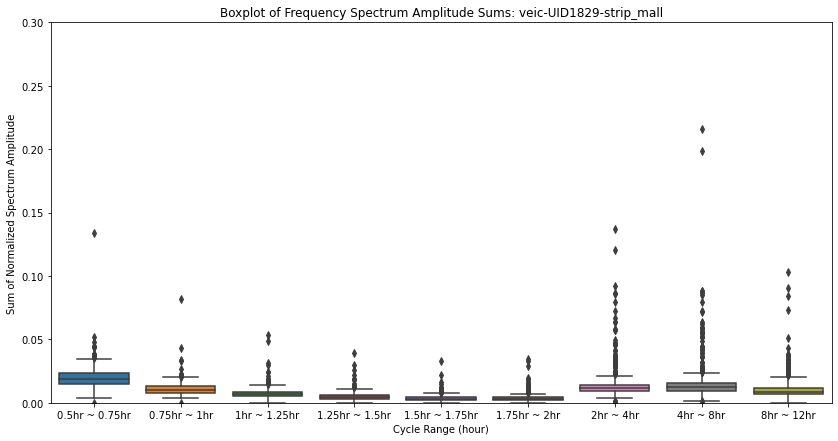

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


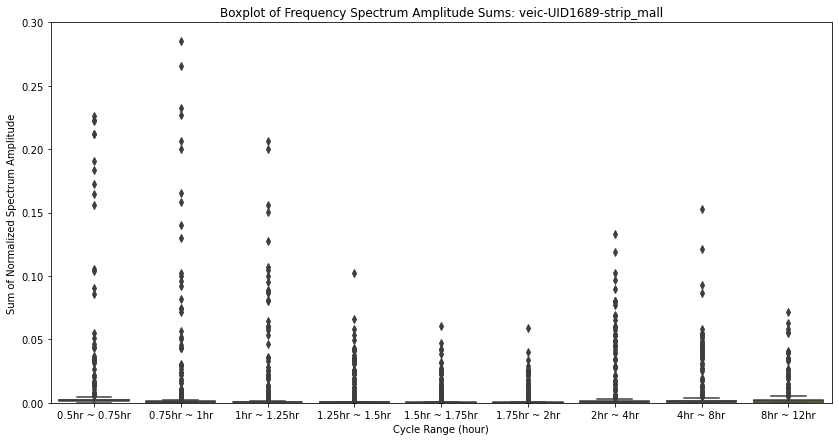

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


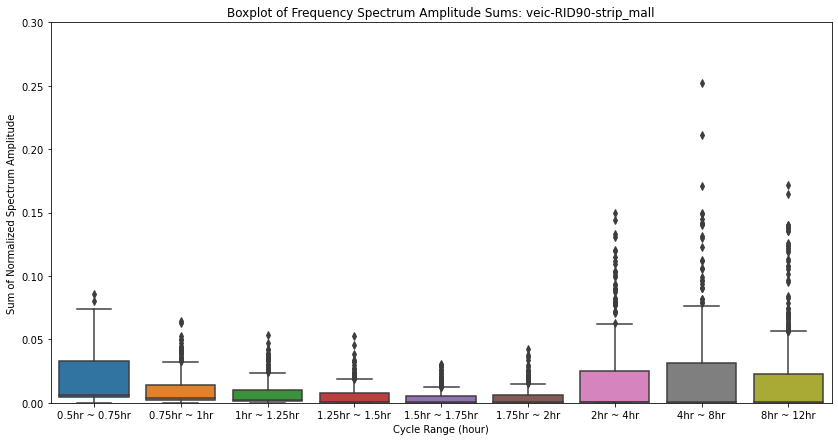

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


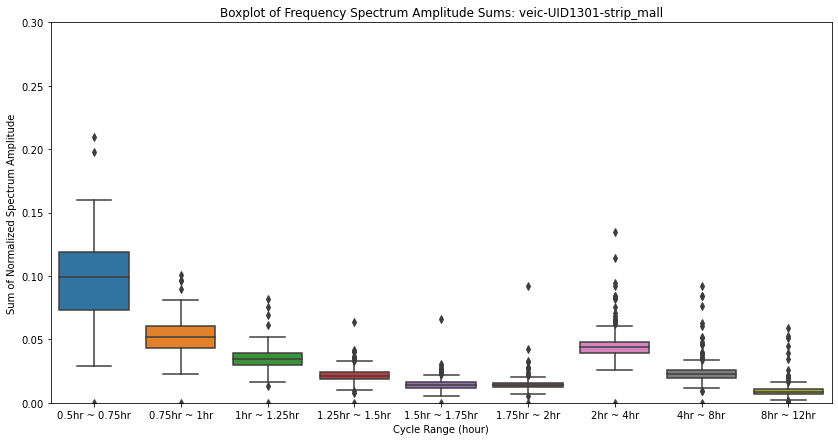

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


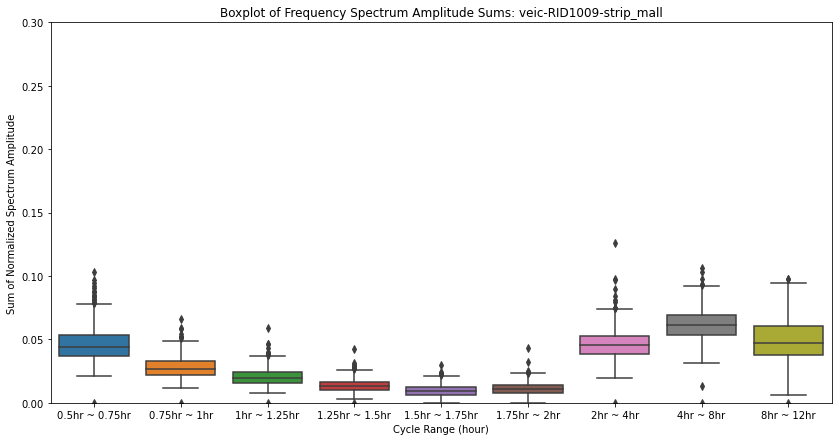

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


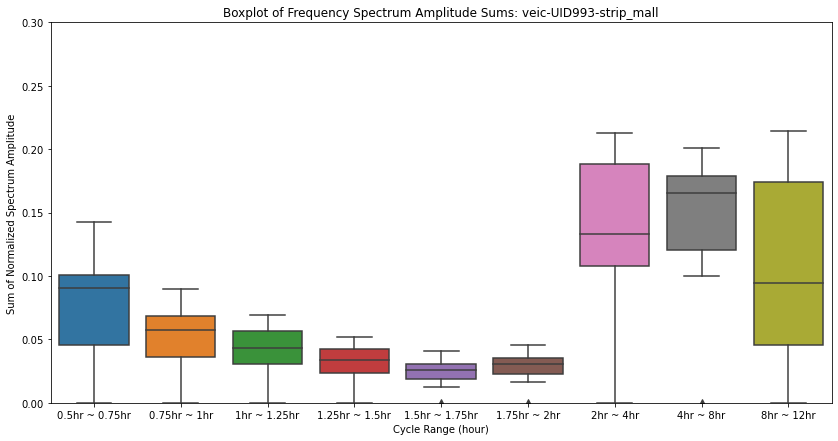

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


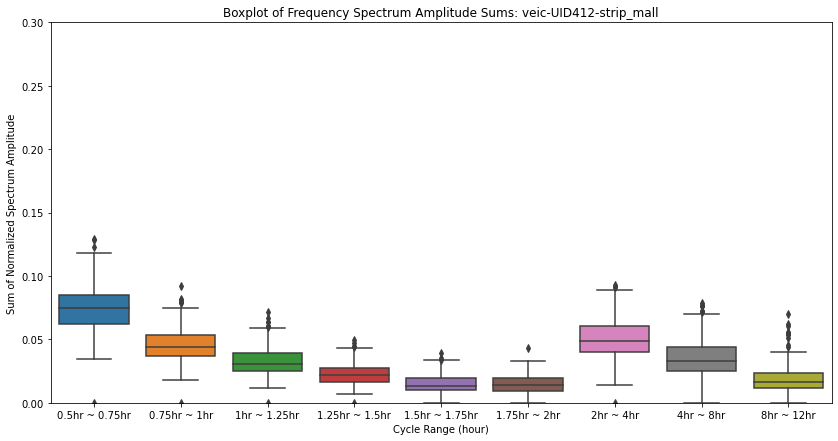

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


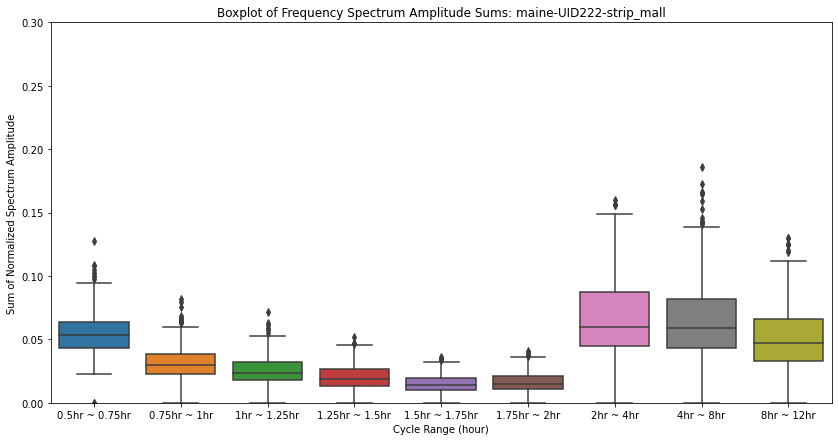

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


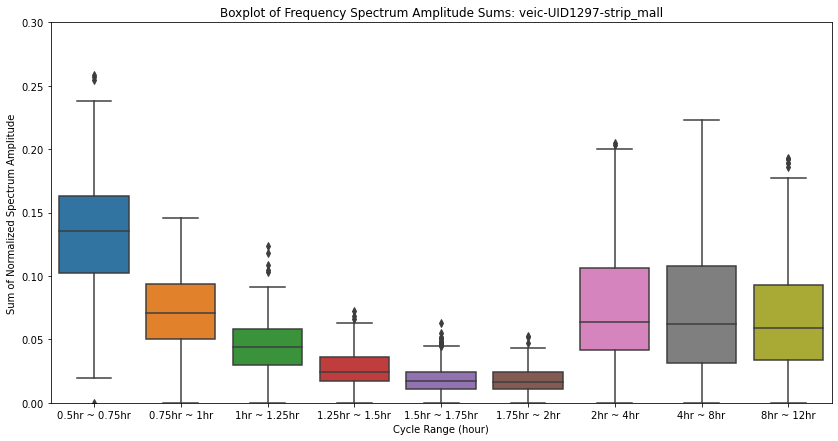

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


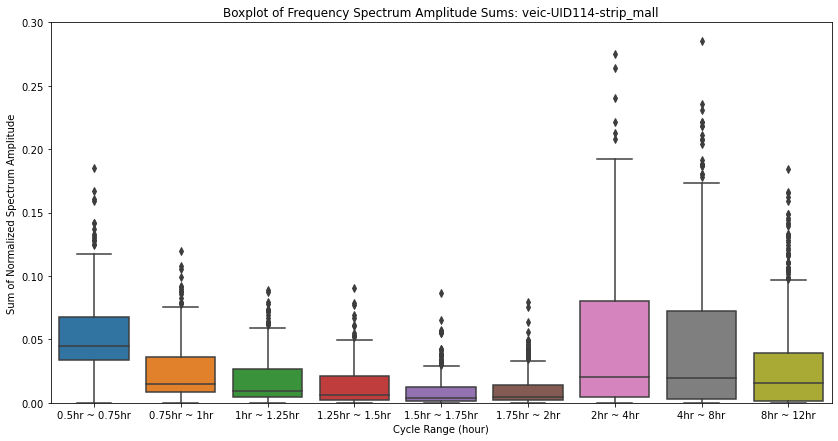

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


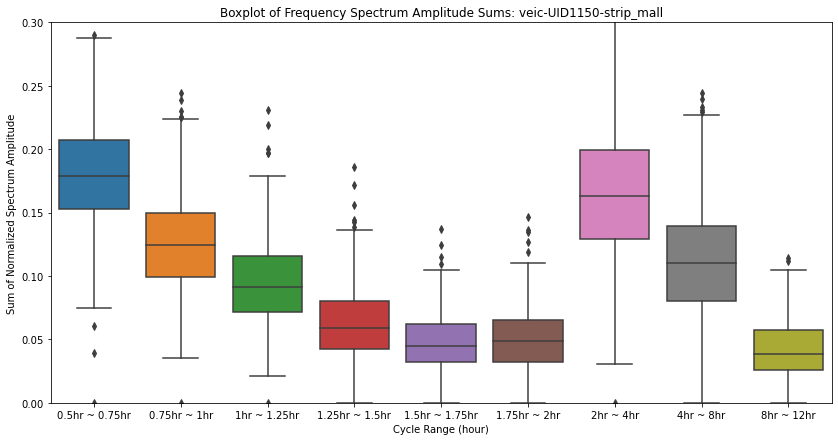

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


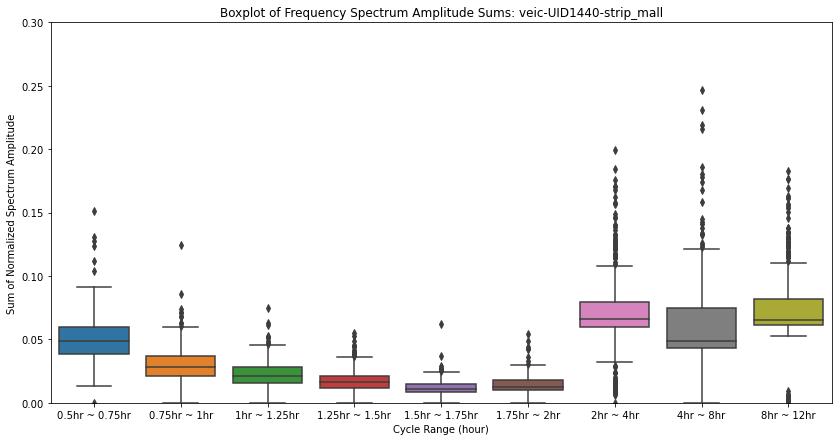

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


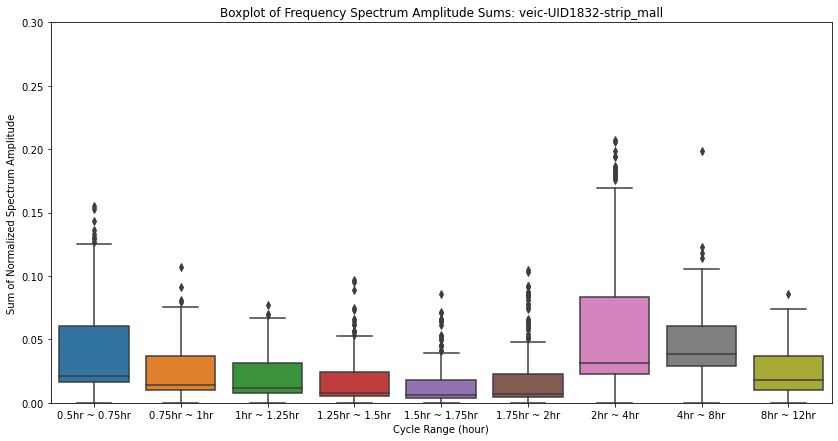

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


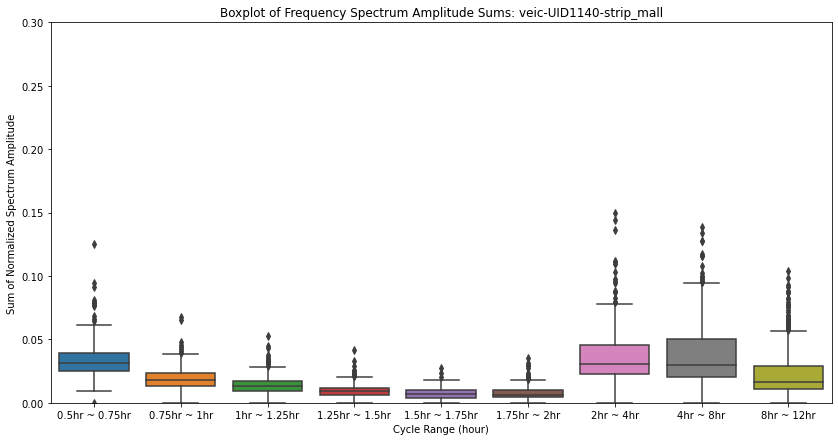

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


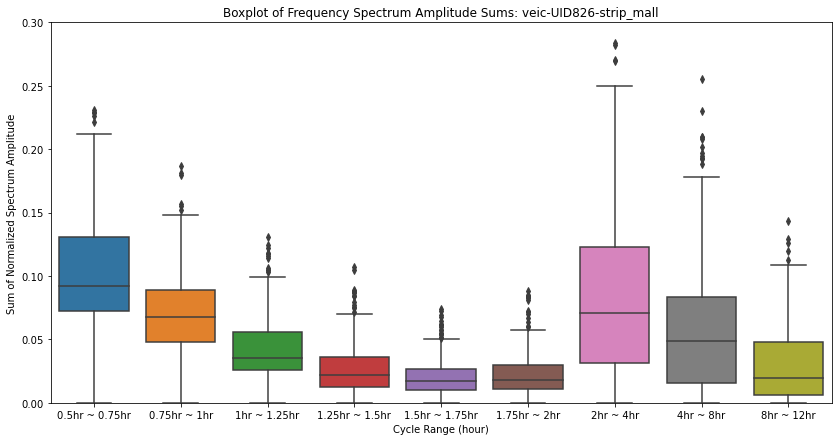

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


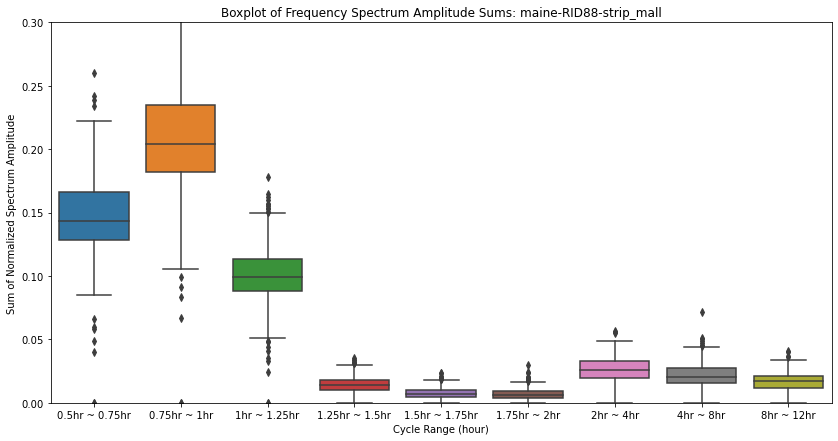

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


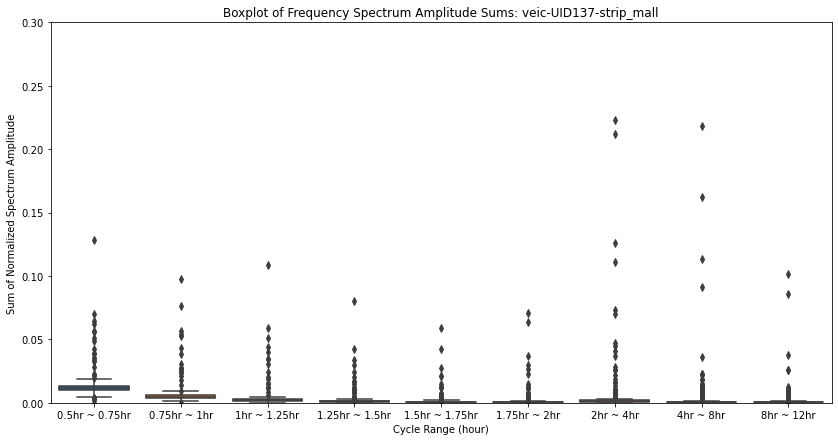

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


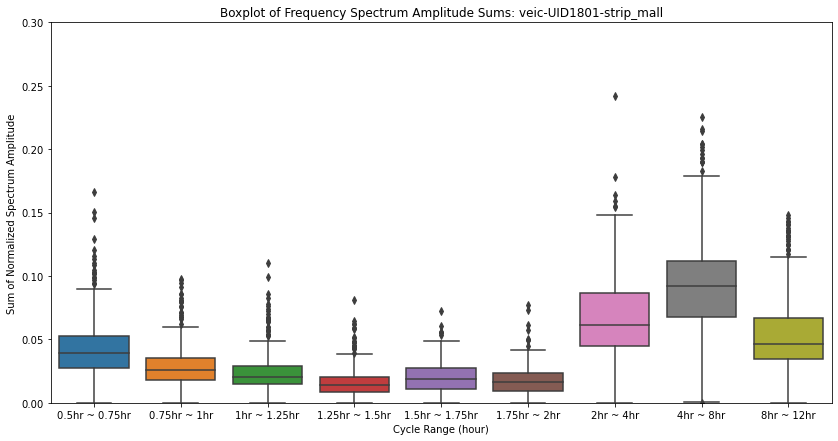

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


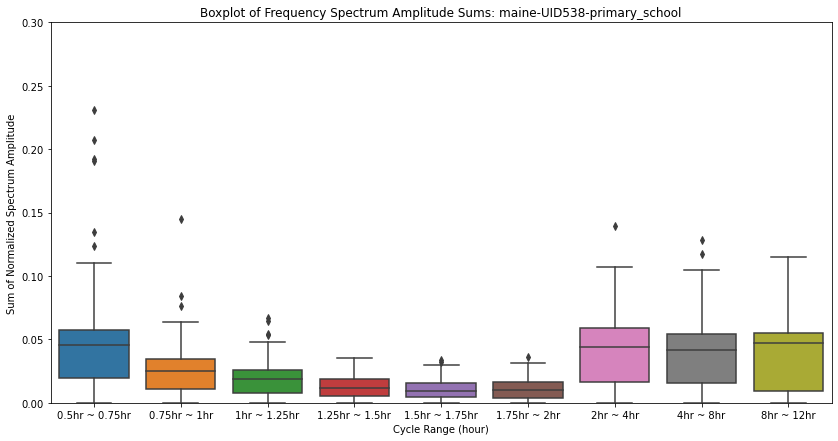

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


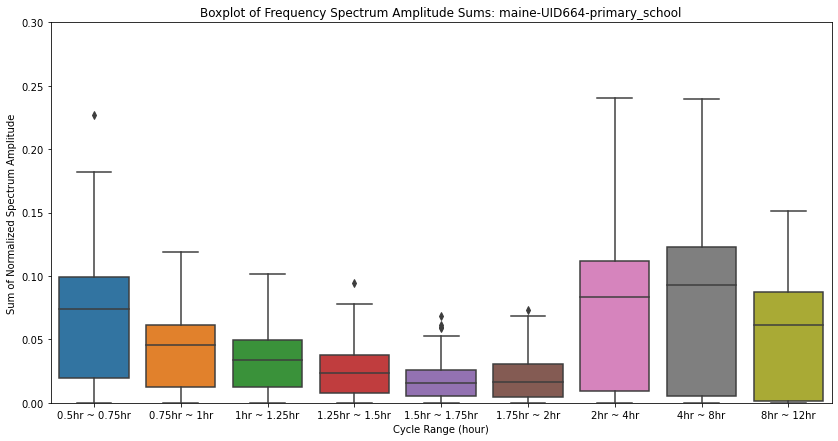

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


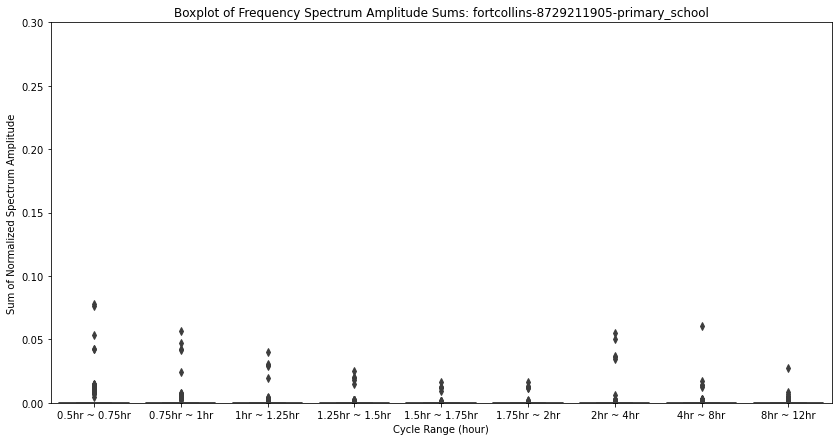

/Users/jgonzal2/EULP/result/frequency_domain/by_building_type/step_2


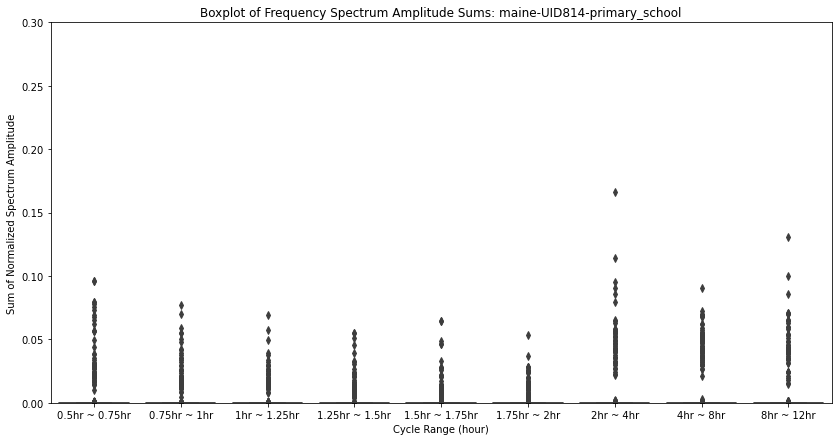

In [20]:
for i, ts_csv in enumerate(v_typical_ts_CSVs):
    print(dir_daily_window_dft_out)
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_ts = ex.clean_pge_df_ts(ts_csv)[0]
    df = fd.get_daily_fft_sum_bins(df_ts, hour_interval_bins)
    fd.daily_fft_sum_bins_boxplot(df, title_key=sp_id, save_path=f"{dir_daily_window_dft_out}/{sp_id}.png")

Next, we can cluster the daily frequency spectrum bins and see how they are distributed in each building.

In [21]:
# Prepare the clustering input

for i, ts_csv in enumerate(v_typical_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_ts = ex.clean_pge_df_ts(ts_csv)[0]
    df = fd.get_daily_fft_sum_bins(df_ts, hour_interval_bins)
    df['sp_id'] = sp_id
    if i == 0:
        df_all = df
    else:
        df_all = df_all.append(df)

In [ ]:
df_all

Find the optimal number of clusters

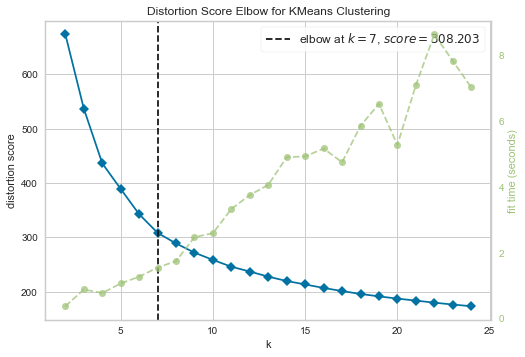

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# Select n
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Whether to standardize features
standard_feature = True
standard_feature = False

scaler = preprocessing.StandardScaler()
if standard_feature:
    fft_data = scaler.fit_transform(df_all.iloc[:, 0:-1])
else:
    fft_data = df_all.iloc[:, 0:-1].to_numpy()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))
visualizer.fit(fft_data) # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Run K-Means clustering with the selected k 

In [23]:
# Actual clustering
kmeans = KMeans(n_clusters=6, init='random', n_init=5)
KM_model = kmeans.fit(fft_data)
kmeans.fit_predict(fft_data)
kmeans_labels = kmeans.labels_
kmeans_labels.shape

(119692,)

Count the each cluster's appearance in each building 

In [24]:
v_sp_ids = df_all['sp_id']

dict_cluster_count = {}
for c in np.unique(kmeans_labels):
    ls_c = []
    arr_temp = np.take(np.array(v_sp_ids), np.where(kmeans_labels==c))[0]
    for sp_id in np.unique(v_sp_ids):
        ls_c.append(np.count_nonzero(arr_temp == sp_id))
    dict_cluster_count[f"Cluster {c}"] = ls_c

df_cluster_count = pd.DataFrame(dict_cluster_count)
df_cluster_count.index = np.unique(v_sp_ids)

# pd.set_option('display.max_rows', None, 'display.max_columns', None)
df_cluster_count

Cluster 0  Cluster 1  Cluster 2  \
fortcollins-8604207001-outpatient            342          0         20   
fortcollins-8718318010-outpatient            363          0          0   
fortcollins-8719144003-small_office          359          0          5   
fortcollins-8729211905-primary_school        362          0          5   
fortcollins-9602406001-small_office          361          0          1   
...                                          ...        ...        ...   
veic-UID945-retail                           137          0          3   
veic-UID966-small_office                     273          0         31   
veic-UID967-retail                             8          9        244   
veic-UID989-medium_office                    245          0        109   
veic-UID993-strip_mall                         1          0          0   

                                       Cluster 3  Cluster 4  Cluster 5  
fortcollins-8604207001-outpatient              4          1          0  
fortcollins-8718318010-outpatient              1          0          3  
fortcollins-8719144003-small_office            3          0          0  
fortcollins-8729211905-primary_school          0          0          0  
fortcollins-9602406001-small_office            0          0          5  
...                                          ...        ...        ...  
veic-UID945-retail                           127         99          0  
veic-UID966-small_office                      57          4          1  
veic-UID967-retail                             6          7         92  
veic-UID989-medium_office                     12          0          0  
veic-UID993-strip_mall                       143        222          0  

[327 rows x 6 columns]

Visualize cluster centers

Text(0, 0.5, 'Sum of Amplitudes')

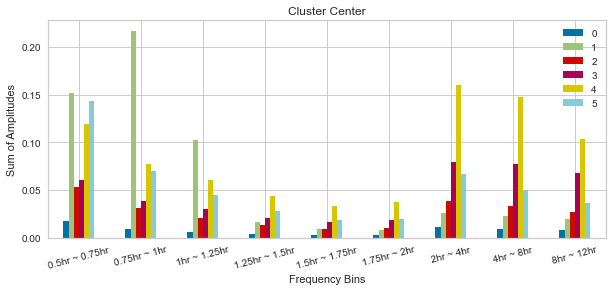

In [25]:
import matplotlib.pyplot as plt

df_cluster_center = pd.DataFrame(kmeans.cluster_centers_, columns=df_all.columns[:-1], dtype = float)

plt.figure(figsize=(10,4))
df_cluster_center.T.plot.bar(ax = plt.gca(), rot=15)
plt.title('Cluster Center')
plt.xlabel('Frequency Bins')
plt.ylabel('Sum of Amplitudes')

Visualize cluster counts

Text(0, 0.5, 'Count')

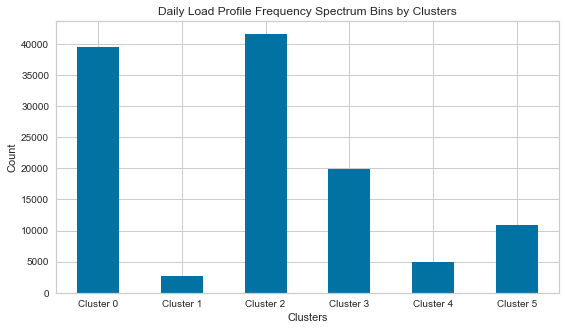

In [26]:
plt.figure(figsize=(9,5))
# df_cluster_count.T.plot.bar(ax = plt.gca(), rot=0, legend=False)
df_cluster_count.sum(axis=0).plot.bar(ax = plt.gca(), rot=0, legend=False)
plt.title('Daily Load Profile Frequency Spectrum Bins by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Count')

Save the session if we want to use the clustering result next time.

In [ ]:
import dill
dill.dump_session('dft_env.db')
# dill.load_session('dft_env.db') # load it